In [1]:
%matplotlib inline
import matplotlib
matplotlib.style.use(['dark_background','classic'])
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%config InlineBackend.figure_format = 'retina'
from numpy import *
from Module_PDE import *
from IPython.display import Image
from IPython.display import display
from scipy.stats import kde
from scipy.optimize import curve_fit
from scipy import stats
def line(x, a, b):
    return a * x + b

In [1]:
1+2

3

# 1. Fit curve Bode/Current define probe parameters

We use: $$G_{k}=\frac{kS}{L}; R_{f}=\frac{\sigma_0L}{S}; r=\frac{R_j}{R_f}$$
And:  $$M=\frac{th(mL)}{mL}; M_{1/2}=\frac{th(mL/2)}{mL/2}=\frac{2}{mL}\frac{(ch(mL)-1)}{sh(mL)}$$
Solve thermal equation for 1 simple wire at $2\omega$, we have:$$\theta=\frac{R_fi_0^2}{2G_k(mL)^2}+Ae^{mx}+Be^{-mx}$$
Boundary condition at x=0:

Boundary condition at x=L:

Temperature at x=0:
$$\theta_j=\frac{R_fi_0^2}{2}\frac{r+M_{1/2}}{G_{eq}+\frac{2G_k}{M}}$$

Out of contact:
$$\theta_{jnc}=\frac{R_fi_0^2}{4G_k}M(r+M_{1/2})$$
$$\overline{\theta_{jnc}}=\frac{R_fi_0^2}{4G_k}\left(\frac{r}{2}MM_{1/2}+\frac{2(1-M)}{(mL)^2}\right)$$

In [2]:
k1 = 71.6; k2 = 52.0; k = (k1 + k2)/2 #thermal conductivity (W/mK)
rhoc1 = 21500.0*133.0; rhoc2 = 19970.0*144.1; rhoc = (rhoc1+rhoc2)/2 #rho*c 
rho = (21500.0+19970.0)/2; c = (133.0+144.1)/2
sigma1 = 9.81e-8; sigma2 = 19.0e-8; sigma = (sigma1+sigma2)/2
a1 = k1/rhoc1; a2 = k2/rhoc2; a = (a1+a2)/2
L = 360e-6; R = 0.64e-6; d = 2*R; S = pi*R**2; p = 2*pi*R
f = 9; w_const = 2*pi*f; I0_air = 3.1e-3; I0_vide = 1.4e-3 # excitation
G = 1e-6; Rj = 6; T_amb = 23; alpha = 0.0028; h_vide = 0.001; h_air = 6500
Rf = sigma*L/S; Gk = k*S/L; r = Rj/Rf

#fuction calculate V2w and V3w values:
def T2wnc(Rf,I0,Gk,r,mL):
    M = tanh(mL)/(mL)
    M12 = tanh(mL/2)/(mL/2)
    return Rf*I0**2/(4*Gk)*M*(r+M12)

def T3wnc(Rf,I0,Gk,r,mL):
    M = tanh(mL)/(mL)
    M12 = tanh(mL/2)/(mL/2)
    return Rf*I0**2/(4*Gk)*(r*M*M12/2+2*(1-M)/(mL)**2)

def V2wnc(I,f,h):
    w = 2*pi*f
    mL = sqrt((h*p)/(k*S)+2*1.j*(w*rho*c)/k)*L
    return polynome_S(T_amb+abs(T2wnc(Rf,I,Gk,r,mL)))-polynome_S(T_amb)
    
def V3wnc(I,f,h):
    w = 2*pi*f
    mL = sqrt((h*p)/(k*S)+2*1.j*(w*rho*c)/k)*L
    return alpha*Rf*I/2*abs(T3wnc(Rf,I,Gk,r,mL))*1e6

print(k,rho,c,sigma)

61.8 20735.0 138.55 1.4405e-07


In [3]:
#Bode curve, courant variation
Bode_air = readDataFile_2('2017_7_10_1039\Bode_T1_air.txt'); I_air = readDataFile_2('2017_7_10_1358\I_T1_air.txt')
Bode_vide = readDataFile_2('2017_7_4_833\Bode_sonde_2606_1.txt'); I_vide = readDataFile_2('2017_7_4_855\I_sonde_2606_1.txt')
Bode_400 = readDataFile_2('2017_7_11_1731\Bode_T1_400Pa.txt'); I_400 = readDataFile_2('2017_7_11_1755\Bode_T1_400Pa.txt')
Ivide=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2])

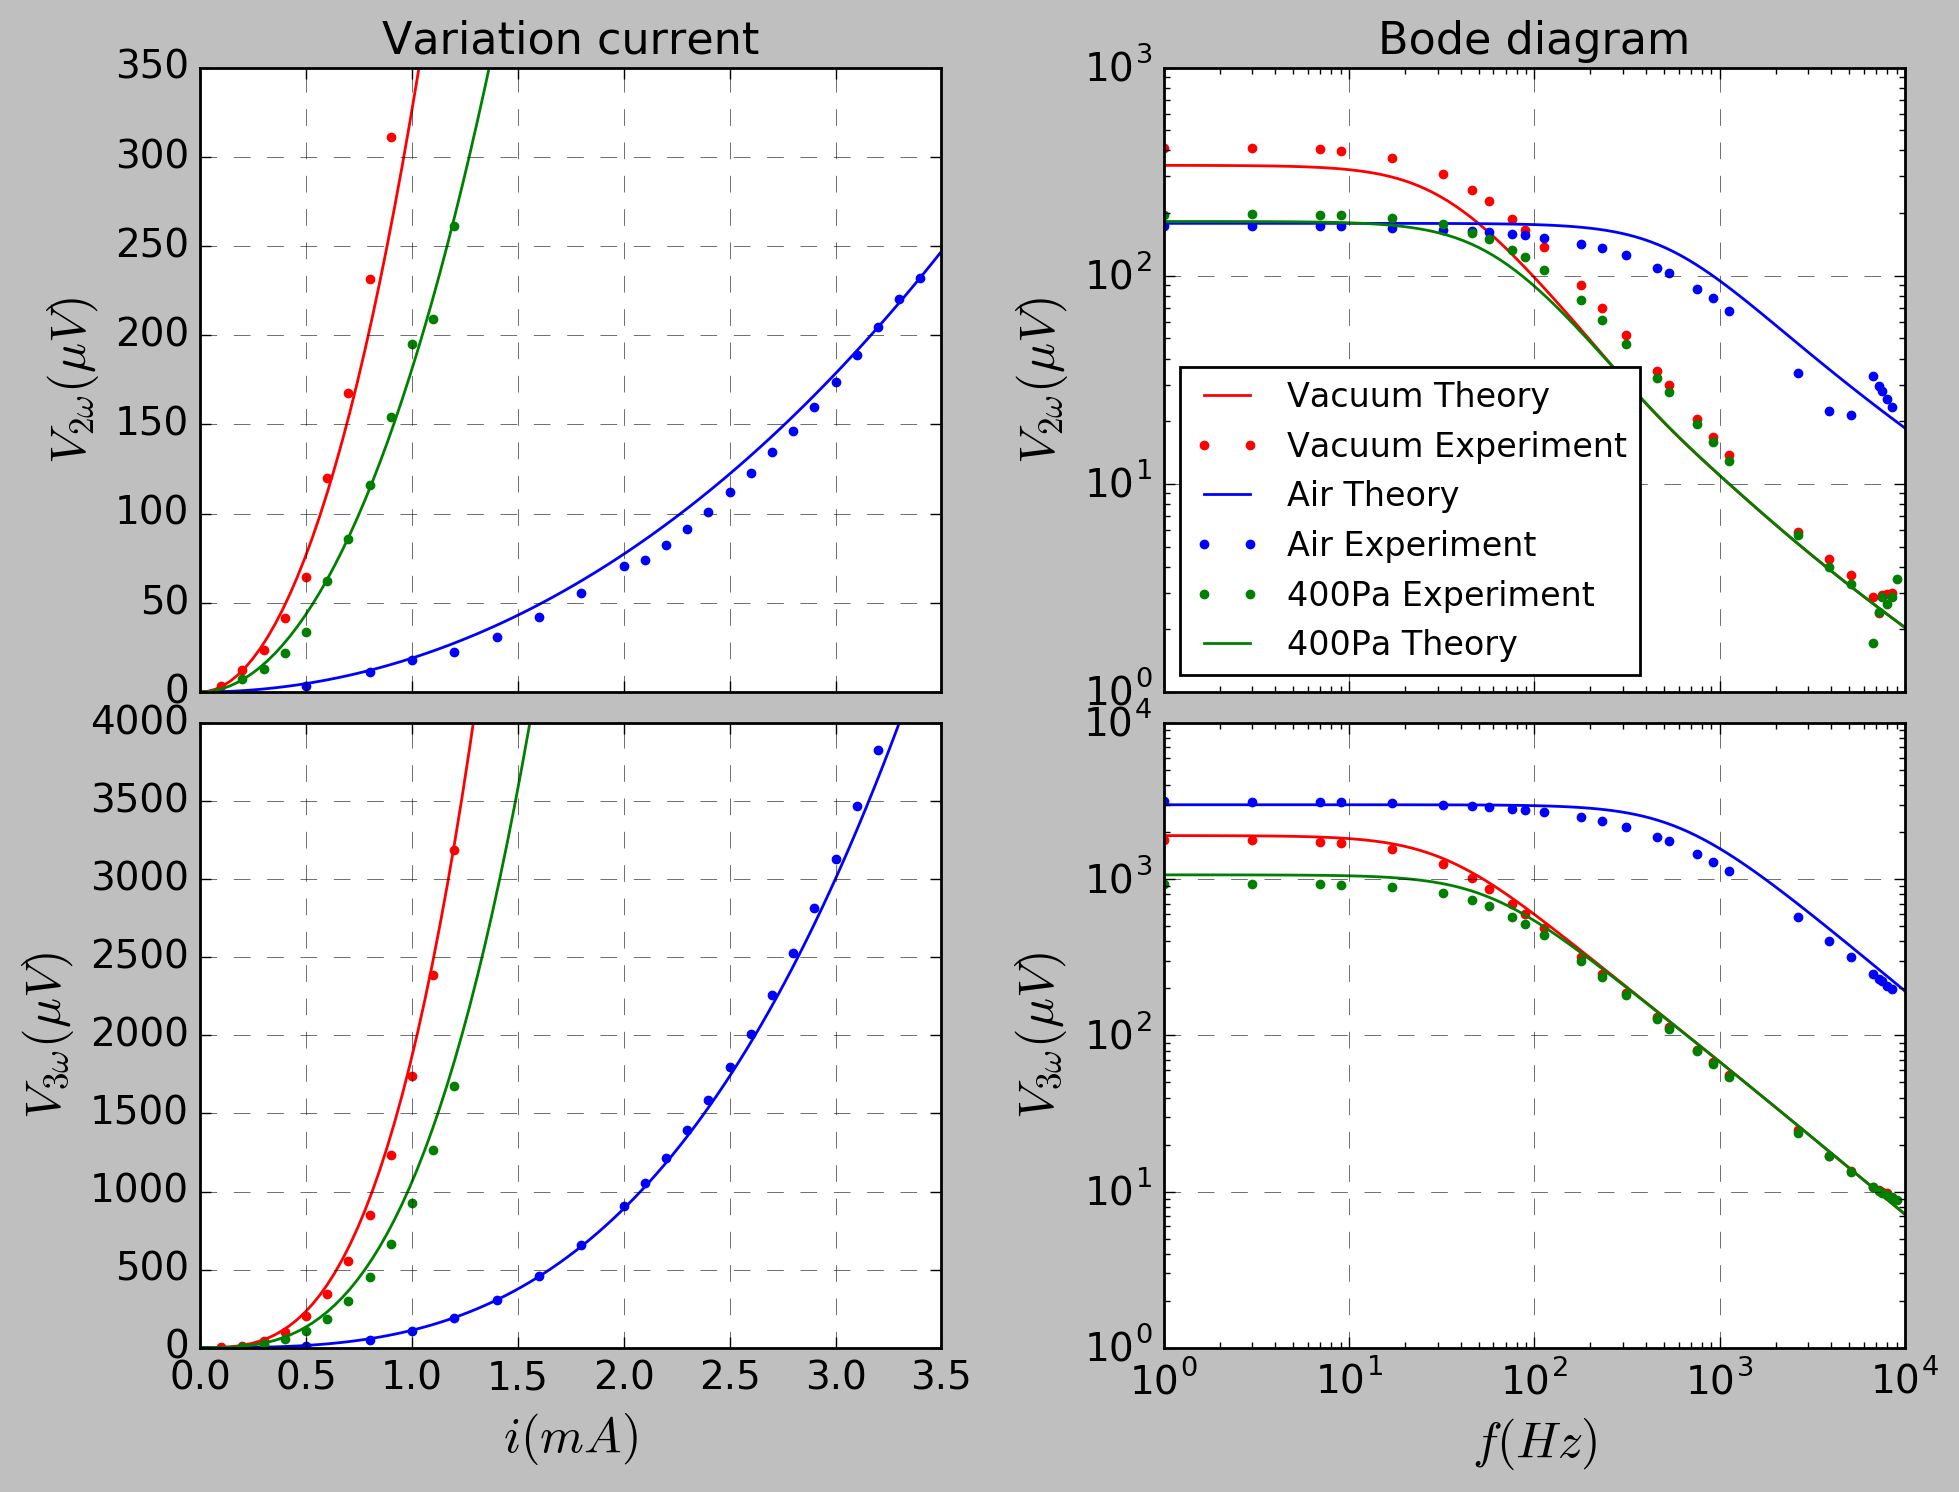

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,sharex='col')
I = linspace(0,3.5e-3,100)
ax1.plot(I*1e3, V2wnc(I,f,h_vide),'r-')
ax1.plot(I_vide[:,6]*1e3, I_vide[:,10],'r.')
ax1.plot(I*1e3, V2wnc(I,f,6500),'b-')
ax1.plot(I_air[:,6]*1e3, I_air[:,10],'b.')
ax1.plot(I*1e3, V2wnc(I,7,300),'g-')
ax1.plot(I_400[:,6]*1e3, I_400[:,10],'g.')
ax1.grid(color='k', linestyle='--', linewidth=0.2)
ax1.set_ylabel('$V_{2\omega}(\mu V)$')
ax1.set_ylim([0, 350])
ax1.set_title('Variation current',fontsize=16)

f_bode = logspace(0,4,100)
ax2.plot(f_bode, V2wnc(1e-3,f_bode,h_vide),'r-', label ='Vacuum Theory')
ax2.plot(Bode_vide[:,7], Bode_vide[:,10],'r.', label ='Vacuum Experiment')
ax2.plot(f_bode, V2wnc(3e-3,f_bode,6500),'b-', label ='Air Theory')
ax2.plot(Bode_air[:,7], Bode_air[:,10],'b.', label ='Air Experiment')
ax2.plot(Bode_400[:,7], Bode_400[:,10],'g.', label ='400Pa Experiment')
ax2.plot(f_bode, V2wnc(1e-3,f_bode,300),'g-', label ='400Pa Theory')
ax2.set_yscale('log')
ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax2.set_ylabel('$V_{2\omega}(\mu V)$')
ax2.set_title('Bode diagram',fontsize=16)
ax2.legend(loc='best',prop={'size':12}) 

ax3.plot(I*1e3, V3wnc(I,7,h_vide),'r-')
ax3.plot(I_vide[:,6]*1e3, I_vide[:,3],'r.')
ax3.plot(I*1e3, V3wnc(I,f,6500),'b-')
ax3.plot(I_air[:,6]*1e3, I_air[:,3],'b.')
ax3.plot(I*1e3, V3wnc(I,7,300),'g-')
ax3.plot(I_400[:,6]*1e3, I_400[:,3],'g.')
ax3.grid(color='k', linestyle='--', linewidth=0.2)
ax3.set_xlabel('$i (mA)$')
ax3.set_ylabel('$V_{3\omega}(\mu V)$')
ax3.set_ylim([0, 4000])

ax4.plot(f_bode, V3wnc(1e-3,f_bode,h_vide),'r-')
ax4.plot(Bode_vide[:,7], Bode_vide[:,3],'r.')
ax4.plot(f_bode, V3wnc(3e-3,f_bode,6500),'b-')
ax4.plot(Bode_air[:,7], Bode_air[:,3],'b.')
ax4.plot(Bode_400[:,7], Bode_400[:,3],'g.')
ax4.plot(f_bode, V3wnc(1e-3,f_bode,300),'g-')
ax4.set_xlim([1, 1e4])
ax4.grid(color='k', linestyle='--', linewidth=0.2)
ax4.set_xlabel('$f (Hz)$')
ax4.set_ylabel('$V_{3\omega}(\mu V)$')
ax4.set_xscale('log')
ax4.set_yscale('log')

fig.set_size_inches(11, 8)
fig.subplots_adjust(wspace=0.3,hspace=0.05)
fig.savefig("Fit_curve_Bode.png", dpi=400,bbox_inches='tight')

# 2. Calibration process

# Plot vide and air before polisage
Probe using: T1 long (photo)
## Ambiance conditions
$$V_{2\omega 0}=150.9 µV; V_{3\omega 0}=1962.9 µV; V_{\omega 0}=152.4 mV; I_{0}=3 mA;f=112 Hz$$

## Initial values under vacuum
$$V_{2\omega 0}=156.1 µV; V_{3\omega 0}=539.2 µV; V_{\omega 0}=152.4 mV; I_{0}=1 mA; f=57 Hz$$

In [5]:
f_vide = 57; f_air = 57; f_400 = 57; h_400 = 300; w_vide = 2*pi*f_vide; w_air = 2*pi*f_air; w_400 = 2*pi*f_400
mL_vide = sqrt((h_vide*p)/(k*S)+2*1.j*(w_vide*rho*c)/k)*L; mL_air = sqrt((h_air*p)/(k*S)+2*1.j*(w_air*rho*c)/k)*L
mL_400 = sqrt((h_400*p)/(k*S)+2*1.j*(w_400*rho*c)/k)*L

M_vide = tanh(mL_vide)/mL_vide; M_air = tanh(mL_air)/mL_air; M_400 = tanh(mL_400)/mL_400
K_convair = abs(M_air/(2*Gk)); K_convide = abs(M_vide/(2*Gk)); K_con400 = abs(M_400/(2*Gk))

print(K_convair,K_convide,K_con400); print(abs(mL_air),abs(mL_vide));print(abs(tanh(mL_air)),abs(tanh(mL_vide)))
print(abs(M_air),abs(M_vide))

DmS = sqrt((0.05/2)**2+(0.05*2)**2+(0.1/2)**2);DmL = sqrt((0.05/2)**2+(0.05)**2+(0.1/2)**2)
Delta_air = sqrt(DmS**2+(DmL**2)*abs(mL_air*(1-tanh(mL_air))**2/tanh(mL_air)))

DmS = sqrt((0.05/2)**2+(0.05*2)**2); DmL = sqrt((0.05/2)**2+(0.05)**2)
Delta_vide = sqrt(DmS**2+(DmL**2)*abs(mL_vide*(1-tanh(mL_vide))**2/tanh(mL_vide)))

print(Delta_air,Delta_vide)

345918.848002 1208846.58732 1077826.73668
6.54332569047 2.07733198463
0.999996670973 1.10943761767
0.152826974887 0.534068519564
0.114564392377 0.103431525656


In [169]:
tanh(2.07733198463)

0.96910268585380022

In [5]:
#import data file à l'air avant polisage
data_cal1_vide=readDataFile_2('2017_7_5_2044\STh_cal1_vide.txt');data_cal2_vide=readDataFile_2('2017_7_5_1728\STh_cal2_vide.txt')
data_cal3_vide=readDataFile_2('2017_7_5_1749\STh_cal3_vide.txt');data_new6_vide=readDataFile_2('2017_7_5_1812\STh_new6_vide.txt')
data_new4_vide=readDataFile_2('2017_7_5_1842\STh_new4_vide.txt');data_new3_vide=readDataFile_2('2017_7_5_1859\STh_new3_vide.txt')
data_new2_vide=readDataFile_2('2017_7_5_1918\STh_new2_vide.txt');data_new5_vide=readDataFile_2('2017_7_5_1935\STh_new5_vide.txt')
data_cal9_vide=readDataFile_2('2017_7_5_1954\STh_cal9_vide.txt');data_new1_vide=readDataFile_2('2017_7_5_207\STh_new1_vide.txt')
data_cal13_vide=readDataFile_2('2017_7_5_2022\STh_cal13_vide.txt')

#import data file à l'air avant polisage
data_cal1_air=readDataFile_2('2017_7_7_1542\STh_cal1_vide.txt');data_cal2_air=readDataFile_2('2017_7_7_1556\STh_cal2_air.txt')
data_cal3_air=readDataFile_2('2017_7_7_168\STh_cal3_air.txt');data_new6_air=readDataFile_2('2017_7_7_1628\STh_new6_air.txt')
data_new4_air=readDataFile_2('2017_7_7_1640\STh_new4_air.txt');data_new3_air=readDataFile_2('2017_7_7_1656\STh_new3_air.txt')
data_new2_air=readDataFile_2('2017_7_7_1720\STh_new2_air.txt');data_new5_air=readDataFile_2('2017_7_7_1730\STh_new5_air.txt')
data_cal9_air=readDataFile_2('2017_7_7_1744\STh_cal9_air.txt');data_new1_air=readDataFile_2('2017_7_7_1810\STh_new1_air.txt')
data_cal13_air=readDataFile_2('2017_7_7_1820\STh_cal13_air.txt')

#import data file 400Pa
data_cal1_400=readDataFile_2('2017_7_11_1120\cal1_T1_400Pa.txt');data_cal2_400=readDataFile_2('2017_7_11_1138\cal2_T1_400Pa.txt')
data_cal3_400=readDataFile_2('2017_7_11_123\cal3_T1_400Pa.txt');data_new6_400=readDataFile_2('2017_7_11_137\cnew6_T1_400Pa.txt')
data_new4_400=readDataFile_2('2017_7_11_1326\cnew4_T1_400Pa.txt');data_new3_400=readDataFile_2('2017_7_11_1430\cnew3_T1_400Pa.txt')
data_new2_400=readDataFile_2('2017_7_11_155\cnew2_T1_400Pa.txt');data_new5_400=readDataFile_2('2017_7_11_1546\cnew5_T1_400Pa.txt')
data_cal9_400=readDataFile_2('2017_7_11_1633\cal9_T1_400Pa.txt');data_new1_400=readDataFile_2('2017_7_11_1652\cnew1_T1_400Pa.txt')
data_cal13_400=readDataFile_2('2017_7_11_1719\cal13_T1_400Pa.txt')


#data_vide = [data_cal1_vide,data_cal2_vide,data_cal3_vide,data_new6_vide,data_new4_vide,data_new3_vide,data_new2_vide,data_new5_vide,data_cal9_vide,data_new1_vide,data_cal13_vide]
data_vide_2w = [remove_highpoint(data_cal1_vide[:,5],220,0),data_cal2_vide[:,5],remove_highpoint(data_cal3_vide[:,5],220,0),data_new6_vide[:,5],data_new4_vide[:,5],data_new3_vide[:,5],data_new2_vide[:,5],data_new5_vide[:,5],data_cal9_vide[:,5],data_new1_vide[:,5],data_cal13_vide[:,5]]
data_air_2w = [data_cal1_air[:,5],data_cal2_air[:,5],data_cal3_air[:,5],data_new6_air[:,5],data_new4_air[:,5],data_new3_air[:,5],data_new2_air[:,5],data_new5_air[:,5],data_cal9_air[:,5],data_new1_air[:,5],data_cal13_air[:,5]]
data_air_2w_2 = [data_cal1_air[:,5],data_cal2_air[:,5],data_cal3_air[:,5],data_new6_air[:,5],data_new4_air[:,5],data_new3_air[:,5],data_new5_air[:,5],data_cal9_air[:,5],data_new1_air[:,5],data_cal13_air[:,5]]
data_400_2w = [data_cal1_400[:,10],data_cal2_400[:,10],remove_highpoint(data_cal3_400[:,10],130,0),data_new6_400[:,10],data_new4_400[:,10],data_new3_400[:,10],data_new2_400[:,10],data_new5_400[:,10],data_cal9_400[:,10],data_new1_400[:,10],data_cal13_400[:,10]]

data_vide_3w = [remove_highpoint(data_cal1_vide[:,2],860,0),data_cal2_vide[:,2],remove_highpoint(data_cal3_vide[:,2],860,0),data_new6_vide[:,2],data_new4_vide[:,2],data_new3_vide[:,2],data_new2_vide[:,2],data_new5_vide[:,2],data_cal9_vide[:,2],data_new1_vide[:,2],data_cal13_vide[:,2]]
data_air_3w = [data_cal1_air[:,2],data_cal2_air[:,2],data_cal3_air[:,2],data_new6_air[:,2],data_new4_air[:,2],data_new3_air[:,2],data_new2_air[:,2],data_new5_air[:,2],data_cal9_air[:,2],data_new1_air[:,2],data_cal13_air[:,2]]
data_air_3w_2 = [data_cal1_air[:,2],data_cal2_air[:,2],data_cal3_air[:,2],data_new6_air[:,2],data_new4_air[:,2],data_new3_air[:,2],data_new5_air[:,2],data_cal9_air[:,2],data_new1_air[:,2],data_cal13_air[:,2]]
data_400_3w = [data_cal1_400[:,3],data_cal2_400[:,3],data_cal3_400[:,3],data_new6_400[:,3],data_new4_400[:,3],data_new3_400[:,3],data_new2_400[:,3],data_new5_400[:,3],data_cal9_400[:,3],data_new1_400[:,3],data_cal13_400[:,3]]
#data_vide_2w = [data_cal1_vide[:,5],data_cal2_vide[:,5],remove_highpoint(data_cal3_vide[:,5],220,0),data_new6_vide[:,5],data_new4_vide[:,5],data_new3_vide[:,5],data_new2_vide[:,5],data_new5_vide[:,5],data_cal9_vide[:,5],data_new1_vide[:,5],data_cal13_vide[:,5]]

#non contact value
V_nc_vide = 231.9; V_nc_air = 161.8; V_nc_400 = 151.1
#reference conductivity values
k_cal1 = 0.187 #PMMA
k_cal2 = 0.329 #POM C
k_cal3 = 1.28 #SiO2
k_cal5 = 21.7 #Ti
k_cal10 = 56.2 #Ta
k_cal11 = 150 #Si
k_cal13 = 93.4 #Si p++
k_cal14 = 71.2 #Si n++
k_cal6 = 117 #Zn
k_cal7 = 386 #Cu
k_cal9 = 29.8 #Al2O3
k_cal12 = 180
k_cal8 = 3.09
k_cal15 = 14.2
k_new1 = 52 #Ge
k_new2 = 9.15 #TiO2
k_new3 = 9.48 #CaF2
k_new4 = 1.95 #Zr02
k_new5 = 36.9 #Al2O3
k_new6 = 1.11 #Glass
k_cal22 = 1.11 #Glass
k_cal20 = 1.95 #Zr02
k_cal18 = 9.15 #TiO2
k_cal21 = 36.9 #Al2O3
k_cal16 = 52 #Ge undopped


k = [k_cal1,k_cal2,k_cal3,k_new6,k_new4,k_new3,k_new2,k_new5,k_cal9,k_new1,k_cal13]
k_2=[k_cal1,k_cal2,k_cal3,k_new6,k_new4,k_new3,k_new5,k_cal9,k_new1,k_cal13]
label_cal = ['PMMA '+'$\lambda$''=0.187','POMC '+'$\lambda$''=0.329','SiO2 '+'$\lambda$''=1.28','Glass '+'$\lambda$''=1.11','ZrO2 '+'$\lambda$''=1.95','CaF2 '+'$\lambda$''=9.17','TiO2 '+'$\lambda$''=9.15','single Al2O3 '+'$\lambda$''=36.9','Al2O3 '+'$\lambda$''=29.8','Ge '+'$\lambda$''=52','Si n++ '+'$\lambda$''=93.4']
label_cal_2 = ['PMMA k=0.187','POMC k=0.329','SiO2 k=1.28','Glass k=1.14','ZrO2 k=3','CaF2 k=9.17','Al2O3 k=18','Al2O3 k=29.8','Ge k=60','Si n++ k=93.4']
data_shape = ['o','o','o','o','o','o','o','s','s','s','s']

k_3 = [k_cal1,k_cal2,k_cal3,k_cal22,k_cal20,k_cal18,k_cal21,k_cal9,k_cal16,k_cal13]
label_cal_3 = ['cal1 PMMA k=0.187','cal2 POMC k=0.329','cal3 SiO2 k=1.28','cal22 Glass k=1.11','cal20 ZrO2 k=1.95','cal18 TiO2 k=9.15','cal21 mono Al2O3 k=18','cal9 Al2O3 k=36.9','cal16 Ge k=52','cal13 Si n++ k=93.4']
data_vide_2w_3 = [remove_highpoint(data_cal1_vide[:,5],220,0),data_cal2_vide[:,5],remove_highpoint(data_cal3_vide[:,5],220,0),data_new6_vide[:,5],data_new4_vide[:,5],data_new2_vide[:,5],data_new5_vide[:,5],data_cal9_vide[:,5],data_new1_vide[:,5],data_cal13_vide[:,5]]
data_air_2w_3 = [data_cal1_air[:,5],data_cal2_air[:,5],data_cal3_air[:,5],data_new6_air[:,5],data_new4_air[:,5],data_new2_air[:,5],data_new5_air[:,5],data_cal9_air[:,5],data_new1_air[:,5],data_cal13_air[:,5]]


In [317]:
print(std(data_air_2w[10]),mean(data_air_2w[10]))
print(std(data_vide_2w[10]),mean(data_vide_2w[10]))
print(std(data_vide_2w[1])/mean(data_vide_2w[1]))

0.378275811545 100.02122
4.60628666655 122.17716
0.00827738399659


In [7]:
#copy data to excell clipboard
data_vide_2w = array([data_cal1_vide[:,5],data_cal2_vide[:,5],data_cal3_vide[:,5],data_new6_vide[:,5],data_new4_vide[:,5],data_new3_vide[:,5],data_new2_vide[:,5],data_new5_vide[:,5],data_cal9_vide[:,5],data_new1_vide[:,5],data_cal13_vide[:,5]])
data_air_2w = array([data_cal1_air[:,5],data_cal2_air[:,5],data_cal3_air[:,5],data_new6_air[:,5],data_new4_air[:,5],data_new3_air[:,5],data_new2_air[:,5],data_new5_air[:,5],data_cal9_air[:,5],data_new1_air[:,5],data_cal13_air[:,5]])

data_vide_3w = array([data_cal1_vide[:,2],data_cal2_vide[:,2],data_cal3_vide[:,2],data_new6_vide[:,2],data_new4_vide[:,2],data_new3_vide[:,2],data_new2_vide[:,2],data_new5_vide[:,2],data_cal9_vide[:,2],data_new1_vide[:,2],data_cal13_vide[:,2]])
data_air_3w = array([data_cal1_air[:,2],data_cal2_air[:,2],data_cal3_air[:,2],data_new6_air[:,2],data_new4_air[:,2],data_new3_air[:,2],data_new2_air[:,2],data_new5_air[:,2],data_cal9_air[:,2],data_new1_air[:,2],data_cal13_air[:,2]])
toClipboardForExcel(data_air_3w)

# Fit curve with the voltage ratio

In [9]:
#straight line function of 1/k
def line(x, a, b):
    return a * x + b

y_fit_vide_2 = data_vide_2w_3[0]/(V_nc_vide-data_vide_2w_3[0])
x_fit_vide_2=(1/k_3[0])*ones(size(data_vide_2w_3[0]))
for i in range(1,10):
    y_fit_vide_2 = append(y_fit_vide_2,data_vide_2w_3[i]/(V_nc_vide-data_vide_2w_3[i]))
    x_fit_vide_2 = append(x_fit_vide_2,(1/k_3[i])*ones(size(data_vide_2w_3[i])))
popt_v, pcov_v = curve_fit(line, x_fit_vide_2, y_fit_vide_2)
perr = sqrt(diag(pcov_v))

mean_squared = sum((line(x_fit_vide_2, popt_v[0], popt_v[1])-y_fit_vide_2)**2)/size(x_fit_vide_2)

ss_res = dot((y_fit_vide_2 - line(x_fit_vide_2, popt_v[0], popt_v[1])),(y_fit_vide_2 - line(x_fit_vide_2, popt_v[0], popt_v[1])))
ymean = mean(y_fit_vide_2)
ss_tot = dot((y_fit_vide_2-ymean),(y_fit_vide_2-ymean))
R_squared = 1-ss_res/ss_tot

slope, intercept, r_value, p_value, std_err = stats.linregress(x_fit_vide_2,y_fit_vide_2)
print(popt_v)
print(pcov_v)
print(perr)
print(R_squared)
print(r_value)
print(slope)
print(intercept)

[ 1.8030167   1.01807809]
[[ 0.00029382 -0.00030367]
 [-0.00030367  0.00109977]]
[ 0.01714132  0.03316273]
0.978941719893
0.98941483711
1.8030166966
1.01807808977


## Send to Severine

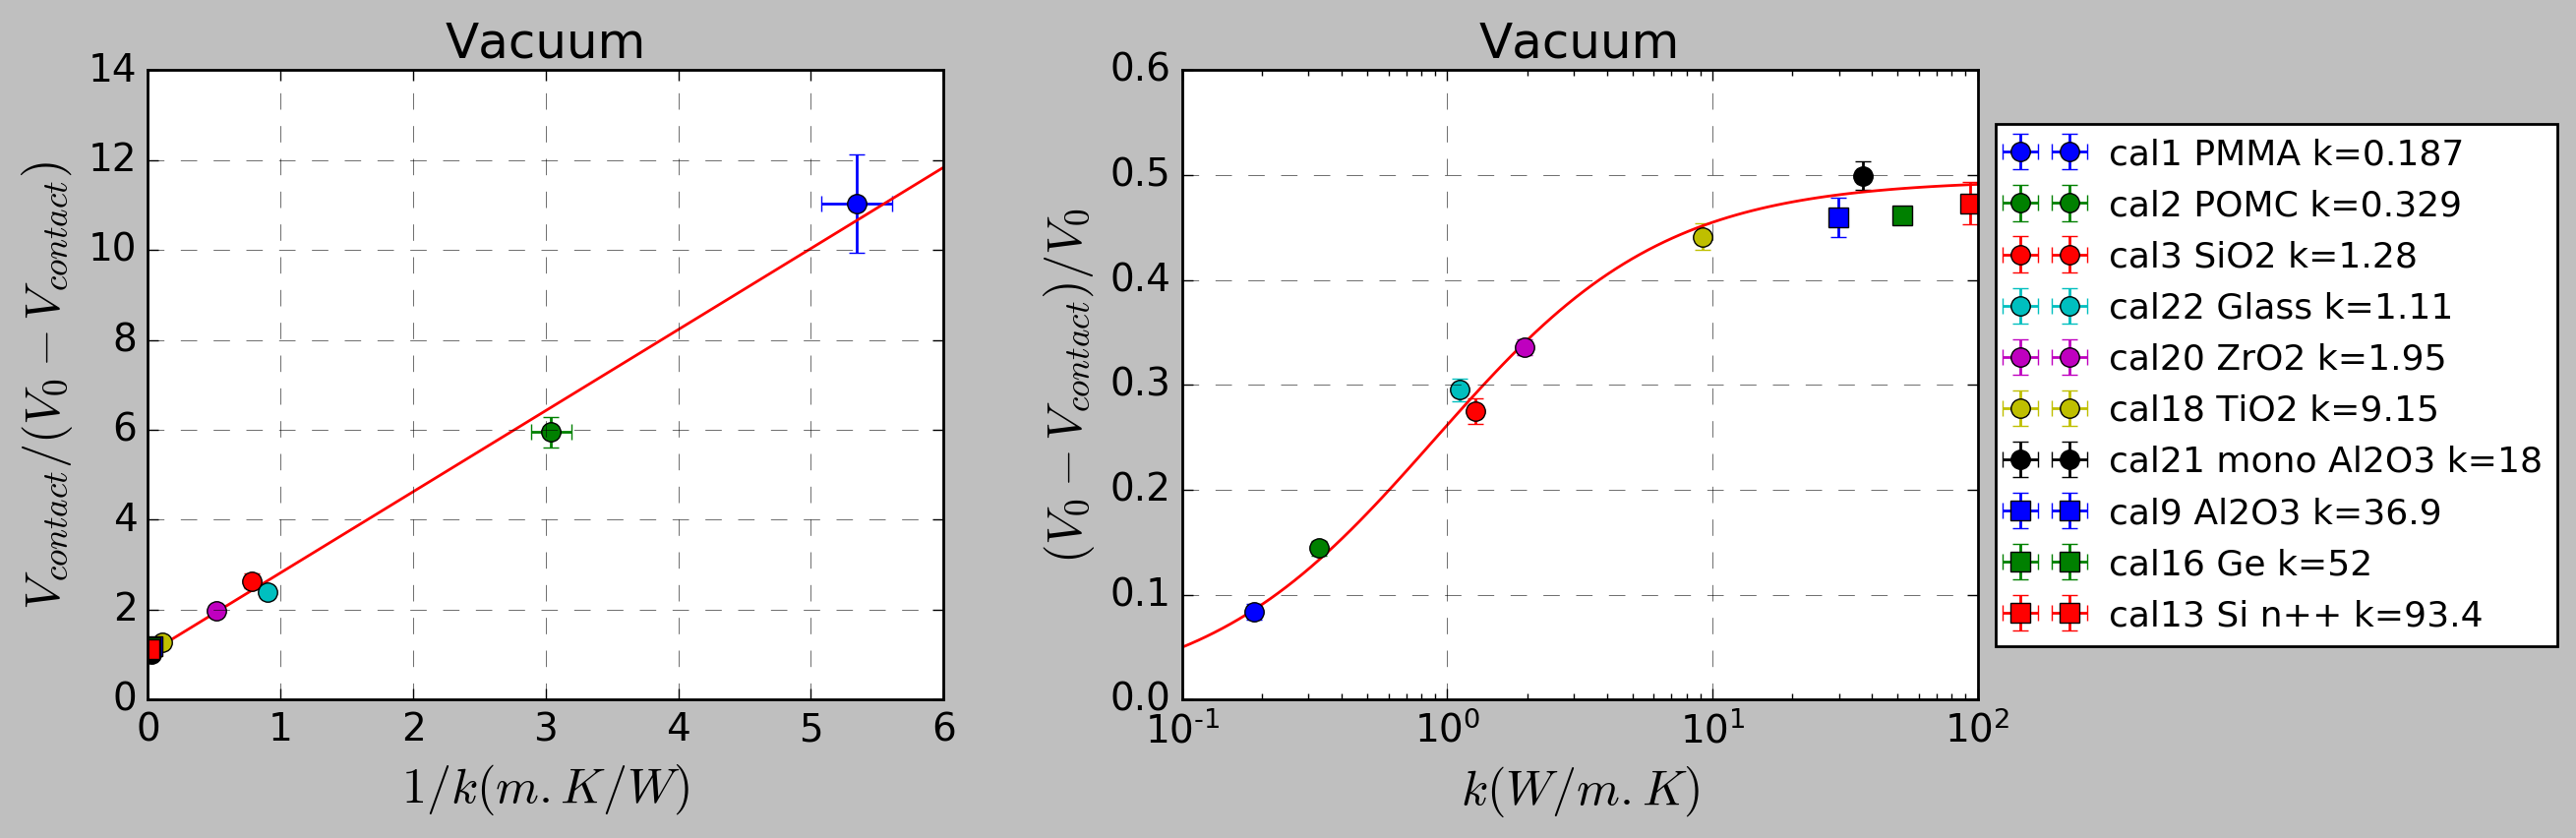

In [11]:
#2-omega plot
fig, (ax2,ax1) = plt.subplots(1,2)
#fig, (ax1) = plt.subplots()
x_inv = logspace(-1, 2.,100)
xfine = linspace(0, 6,100)
for i in range(0,10):
    #ax1.errorbar((k[i])),mean((V_noncontact-data_vide_2w[i])/V_noncontact),std((V_noncontact-data_vide_2w[i])/V_noncontact),'o',markersize=3,label=label_cal[i])
    ax1.errorbar((k_3[i]), mean((V_nc_vide-data_vide_2w_3[i])/V_nc_vide),xerr=k_3[i]*0.05,yerr=std((V_nc_vide-data_vide_2w_3[i])/V_nc_vide), fmt=data_shape[i],markersize=7,label=label_cal_3[i])

ax1.plot(x_inv, 1/(line(1/x_inv, popt_v[0], popt_v[1])+1), 'r-')
ax1.grid(color='k', linestyle='--', linewidth=0.2)

#ax1.plot(x_inv, fit_courbe(x_inv, popt_v[0], popt_v[1]), 'r-')
ax1.set_xscale('log')
#ax1.legend(loc='center left',prop={'size':11},bbox_to_anchor=(1, 0.5)) 
ax1.set_xlabel('$k(W/m.K)$')
ax1.set_ylabel('$(V_{0}-V_{contact})/V_{0}$')

for i in range(0,10):
    ax2.errorbar((1/k_3[i]), mean(data_vide_2w_3[i]/(V_nc_vide-data_vide_2w_3[i])),xerr=(1/k_3[i])*0.05,yerr=std(data_vide_2w[i]/(V_nc_vide-data_vide_2w[i])),fmt=data_shape[i],markersize=7,label=label_cal_3[i])
ax2.plot(xfine, line(xfine, popt_v[0], popt_v[1]), 'r-')
#ax1.legend(loc='center left',prop={'size':11},bbox_to_anchor=(1, 0.5)) 
ax2.set_xlabel('$1/k(m.K/W)$')
ax2.set_ylabel('$V_{contact}/(V_{0}-V_{contact})$')
ax2.grid(color='k', linestyle='--', linewidth=0.2)

#ax1.text(0.5,3.5, 'Air')
#ax.set_xscale('log')
ax1.set_title('Vacuum', fontsize=18)
ax2.set_title('Vacuum', fontsize=18)
#fig.savefig("Vide_TH_6_T1.png", dpi=400,bbox_inches="tight")
ax1.legend(loc='center left',prop={'size':13},bbox_to_anchor=(1, 0.5)) 

#ax.set_title('Calibration curve 1µm of diameter probe', fontsize=14)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Vacuum_newSubtrate_sub.png", dpi=400,bbox_inches="tight")
plt.savefig('Vacuum_newSubtrate_sub.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

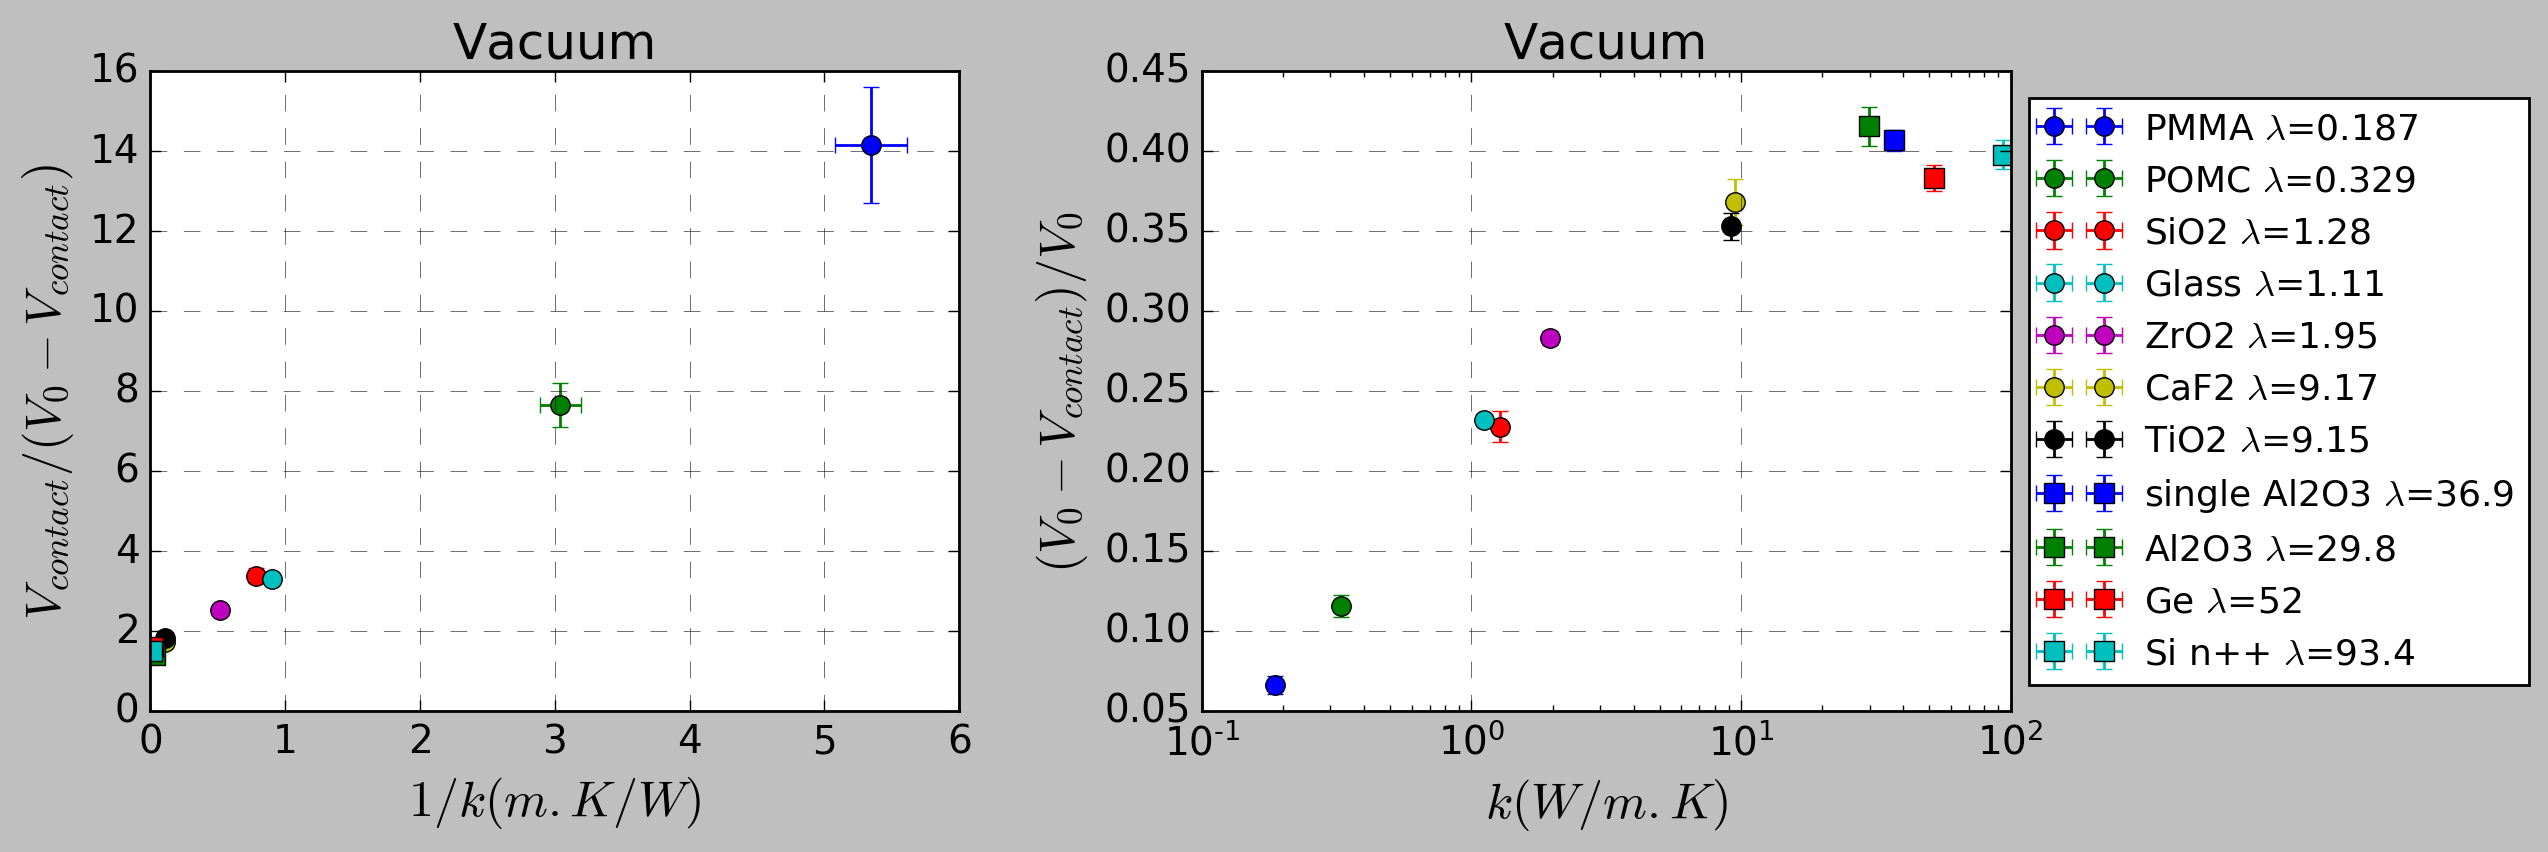

In [177]:
#2-omega plot
fig, (ax2,ax1) = plt.subplots(1,2)
#fig, (ax1) = plt.subplots()
x_inv = logspace(-1, 2.,100)
xfine = linspace(0, 6,100)
for i in range(0,11):
    #ax1.errorbar((k[i])),mean((V_noncontact-data_vide_2w[i])/V_noncontact),std((V_noncontact-data_vide_2w[i])/V_noncontact),'o',markersize=3,label=label_cal[i])
    ax1.errorbar((k[i]), mean((V_nc_400-data_400_2w[i])/V_nc_400),xerr=k[i]*0.05,yerr=std((V_nc_400-data_400_2w[i])/V_nc_400), fmt=data_shape[i],markersize=7,label=label_cal[i])

#ax1.plot(x_inv, 1/(line(1/x_inv, popt_v[0], popt_v[1])+1), 'r-')
ax1.grid(color='k', linestyle='--', linewidth=0.2)

#ax1.plot(x_inv, fit_courbe(x_inv, popt_v[0], popt_v[1]), 'r-')
ax1.set_xscale('log')
#ax1.legend(loc='center left',prop={'size':11},bbox_to_anchor=(1, 0.5)) 
ax1.set_xlabel('$k(W/m.K)$')
ax1.set_ylabel('$(V_{0}-V_{contact})/V_{0}$')

for i in range(0,11):
    ax2.errorbar((1/k[i]), mean(data_400_2w[i]/(V_nc_400-data_400_2w[i])),xerr=(1/k[i])*0.05,yerr=std(data_400_2w[i]/(V_nc_400-data_400_2w[i])),fmt=data_shape[i],markersize=7,label=label_cal[i])
#ax2.plot(xfine, line(xfine, popt_v[0], popt_v[1]), 'r-')
#ax1.legend(loc='center left',prop={'size':11},bbox_to_anchor=(1, 0.5)) 
ax2.set_xlabel('$1/k(m.K/W)$')
ax2.set_ylabel('$V_{contact}/(V_{0}-V_{contact})$')
ax2.grid(color='k', linestyle='--', linewidth=0.2)

#ax1.text(0.5,3.5, 'Air')
#ax.set_xscale('log')
ax1.set_title('Vacuum', fontsize=18)
ax2.set_title('Vacuum', fontsize=18)
#fig.savefig("Vide_TH_6_T1.png", dpi=400,bbox_inches="tight")
ax1.legend(loc='center left',prop={'size':13},bbox_to_anchor=(1, 0.5)) 

#ax.set_title('Calibration curve 1µm of diameter probe', fontsize=14)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Vacuum_newSubtrate_sub.png", dpi=400,bbox_inches="tight")
plt.savefig('Vacuum_newSubtrate_sub.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

## All sample

In [7]:
#straight line function of 1/k
def line(x, a, b):
    return a * x + b

#x_fit = 1/array(k_3)
#y_fit_vide=zeros(10)
y_fit_vide_2 = data_vide_2w[0]/(V_nc_vide-data_vide_2w[0])
x_fit_vide_2=(1/k[0])*ones(size(data_vide_2w[0]))
for i in range(1,11):
    #y_fit_vide[i]= mean(data_vide_2w_3[i]/(V_nc_vide-data_vide_2w_3[i]))
    y_fit_vide_2 = append(y_fit_vide_2,data_vide_2w[i]/(V_nc_vide-data_vide_2w[i]))
    x_fit_vide_2 = append(x_fit_vide_2,(1/k[i])*ones(size(data_vide_2w[i])))
popt_v, pcov_v = curve_fit(line, x_fit_vide_2, y_fit_vide_2)
perr = sqrt(diag(pcov_v))


#R_squared = sum((line(x_fit_vide_2, popt_v[0], popt_v[1])-y_fit_vide_2)**2)/size(x_fit_vide_2)
mean_squared = sum((line(x_fit_vide_2, popt_v[0], popt_v[1])-y_fit_vide_2)**2)/size(x_fit_vide_2)

ss_res = dot((y_fit_vide_2 - line(x_fit_vide_2, popt_v[0], popt_v[1])),(y_fit_vide_2 - line(x_fit_vide_2, popt_v[0], popt_v[1])))
ymean = mean(y_fit_vide_2)
ss_tot = dot((y_fit_vide_2-ymean),(y_fit_vide_2-ymean))
R_squared = 1-ss_res/ss_tot

slope, intercept, r_value, p_value, std_err = stats.linregress(x_fit_vide_2,y_fit_vide_2)
print(popt_v)
print(pcov_v)
print(perr)
print(R_squared)
print(r_value)
print(slope)
print(intercept)

[ 1.80377493  1.01510898]
[[ 0.00025838 -0.00024442]
 [-0.00024442  0.00087615]]
[ 0.01607432  0.02959977]
0.979541264599
0.989717770175
1.80377492716
1.0151089835


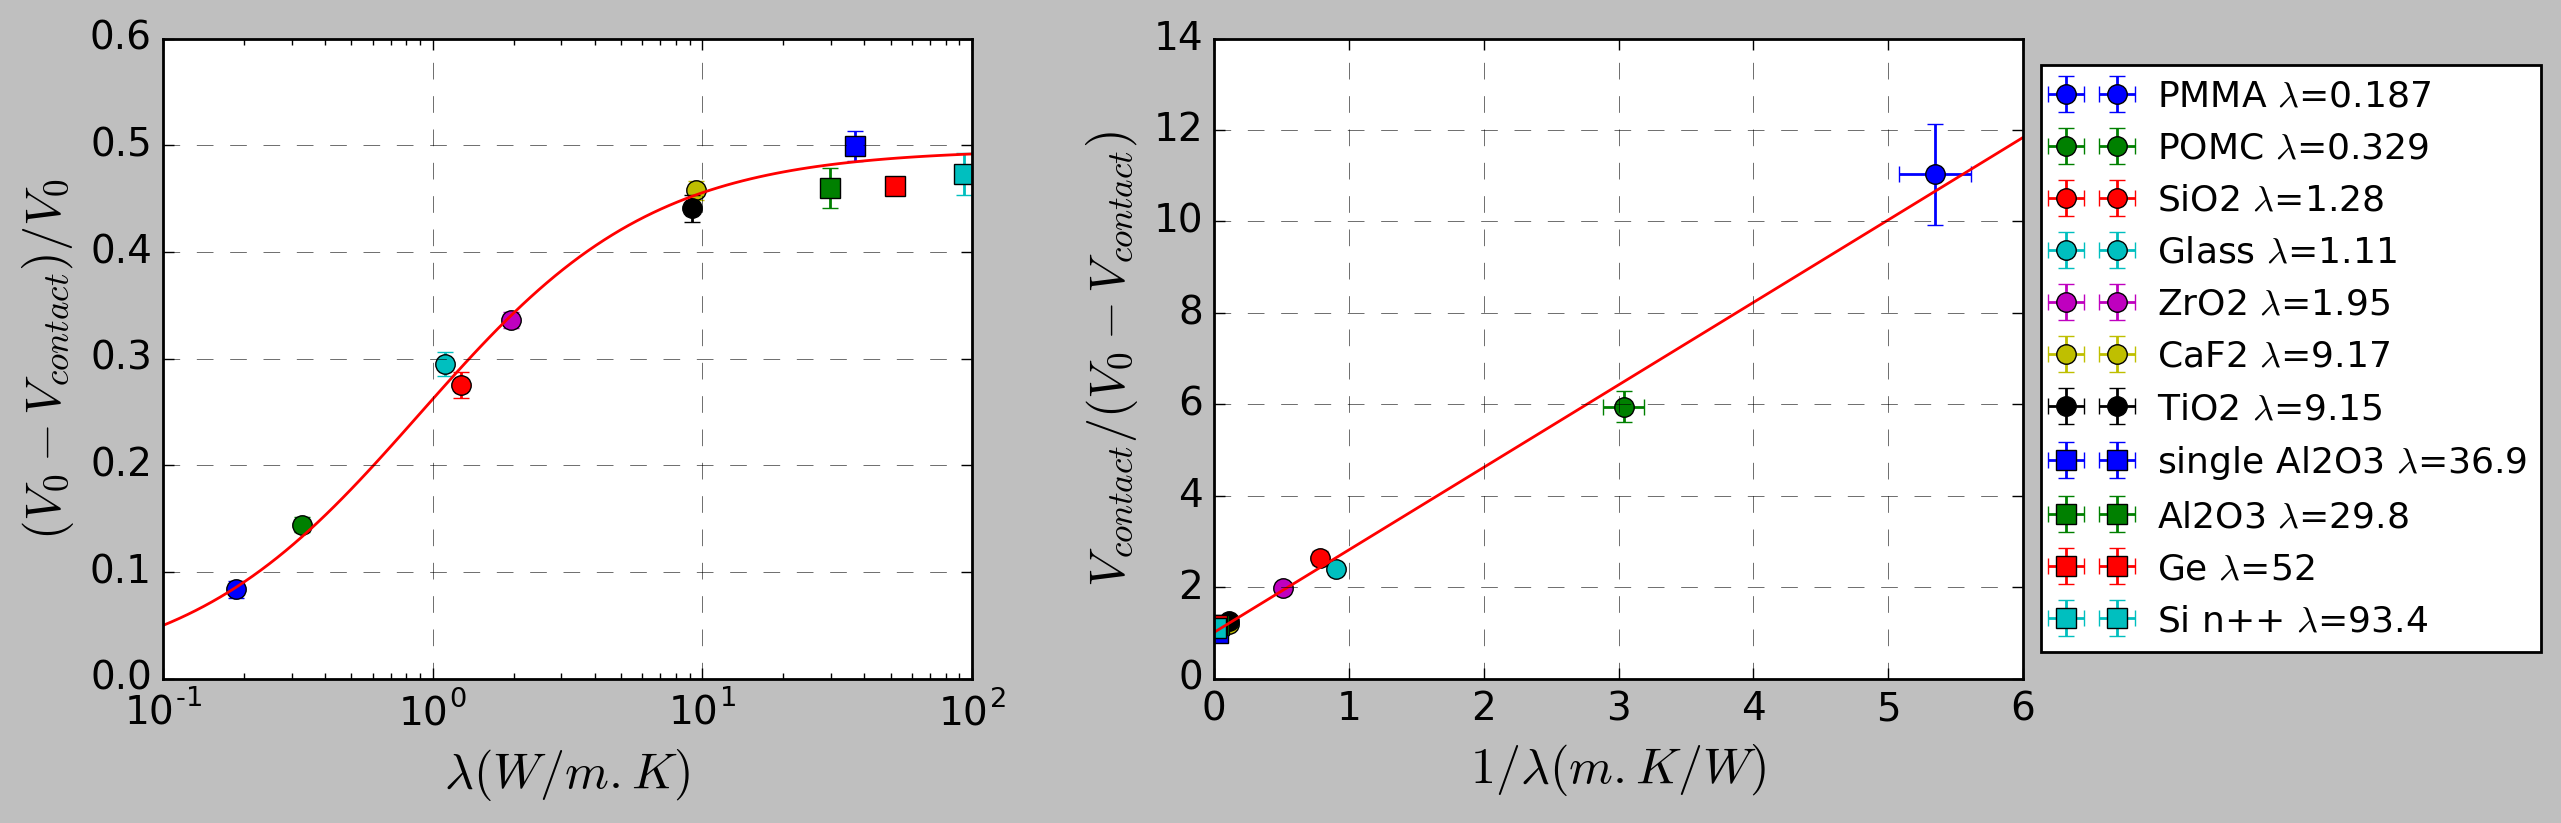

In [9]:
#2-omega plot
fig, ((ax1, ax2)) = plt.subplots(1, 2)
#fig, (ax1) = plt.subplots()
x_inv = logspace(-1, 2.,100)
xfine = linspace(0, 6,100)
for i in range(0,11):
    #ax1.errorbar((k[i])),mean((V_noncontact-data_vide_2w[i])/V_noncontact),std((V_noncontact-data_vide_2w[i])/V_noncontact),'o',markersize=3,label=label_cal[i])
    ax1.errorbar((k[i]), mean((V_nc_vide-data_vide_2w[i])/V_nc_vide),xerr=k[i]*0.05,yerr=std((V_nc_vide-data_vide_2w[i])/V_nc_vide),fmt=data_shape[i],markersize=7,label=label_cal[i])

ax1.plot(x_inv, 1/(line(1/x_inv, popt_v[0], popt_v[1])+1), 'r-')

ax1.grid(color='k', linestyle='--', linewidth=0.2)
#ax1.plot(x_inv, fit_courbe(x_inv, popt_v[0], popt_v[1]), 'r-')
ax1.set_xscale('log')
#ax1.legend(loc='center left',prop={'size':11},bbox_to_anchor=(1, 0.5)) 
ax1.set_xlabel('$\lambda(W/m.K)$')
ax1.set_ylabel('$(V_{0}-V_{contact})/V_{0}$')

for i in range(0,11):
    ax2.errorbar((1/k[i]), mean(data_vide_2w[i]/(V_nc_vide-data_vide_2w[i])),xerr=(1/k[i])*0.05,yerr=std(data_vide_2w[i]/(V_nc_vide-data_vide_2w[i])),fmt=data_shape[i],markersize=7,label=label_cal[i])
ax2.plot(xfine, line(xfine, popt_v[0], popt_v[1]), 'r-')
ax2.grid(color='k', linestyle='--', linewidth=0.2)
#ax1.legend(loc='center left',prop={'size':11},bbox_to_anchor=(1, 0.5)) 
ax2.set_xlabel('$1/\lambda(m.K/W)$')
ax2.set_ylabel('$V_{contact}/(V_{0}-V_{contact})$')


#ax1.text(0.5,3.5, 'Air')
#ax.set_xscale('log')
#ax2.set_title('Inversion of conductivity', fontsize=18)
#ax1.set_title('Logarithm of conductivity', fontsize=18)
#fig.savefig("Vide_TH_6_T1.png", dpi=400,bbox_inches="tight")
ax2.legend(loc='center left',prop={'size':13},bbox_to_anchor=(1, 0.5)) 

#ax.set_title('Calibration curve 1µm of diameter probe', fontsize=14)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Vacuum_newSubtrate_all_sample_ratio.png", dpi=400,bbox_inches="tight")
plt.savefig('Vacuum_newSubtrate_all_sample_ratio.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

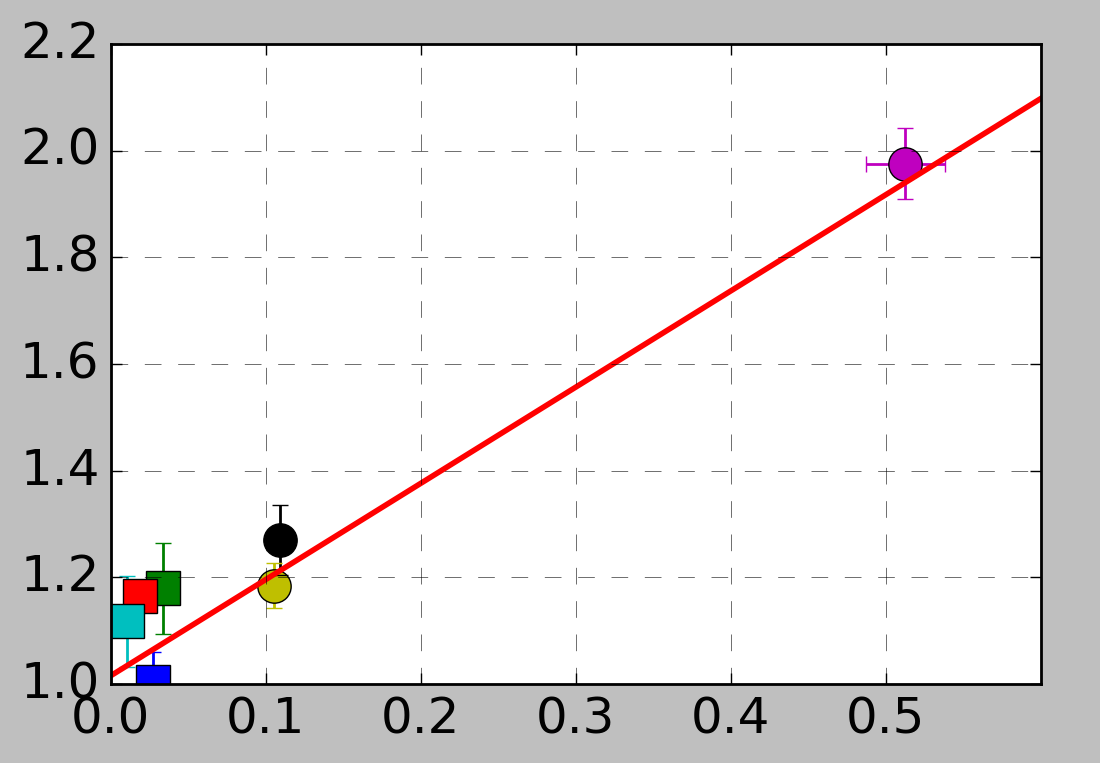

In [15]:
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

#2-omega plot
fig, ( ax2) = plt.subplots()
#fig, (ax1) = plt.subplots()
x_inv = logspace(-1, 2.,100)
xfine = linspace(0, 6,100)

for i in range(0,11):
    ax2.errorbar((1/k[i]), mean(data_vide_2w[i]/(V_nc_vide-data_vide_2w[i])),xerr=(1/k[i])*0.05,yerr=std(data_vide_2w[i]/(V_nc_vide-data_vide_2w[i])),fmt=data_shape[i],markersize=12,label=label_cal[i])
ax2.plot(xfine, line(xfine, popt_v[0], popt_v[1]), 'r-',linewidth=2)
ax2.grid(color='k', linestyle='--', linewidth=0.2)
#ax1.legend(loc='center left',prop={'size':11},bbox_to_anchor=(1, 0.5)) 
#ax2.set_xlabel('$1/\lambda(m.K/W)$')
#ax2.set_ylabel('$V_{contact}/(V_{0}-V_{contact})$')
ax2.set_xlim([0, 0.6])
ax2.set_ylim([1, 2.2])

#ax1.text(0.5,3.5, 'Air')
#ax.set_xscale('log')
#ax2.set_title('Inversion of conductivity', fontsize=18)

#ax.set_title('Calibration curve 1µm of diameter probe', fontsize=14)
fig.set_size_inches(6, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Vacuum_newSubtrate_all_sample_ratio_small.png", dpi=400,bbox_inches="tight")
plt.savefig('Vacuum_newSubtrate_all_sample_ratio_small.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

1.1026 0.9450000000000001
1.9844 1.6038000000000001


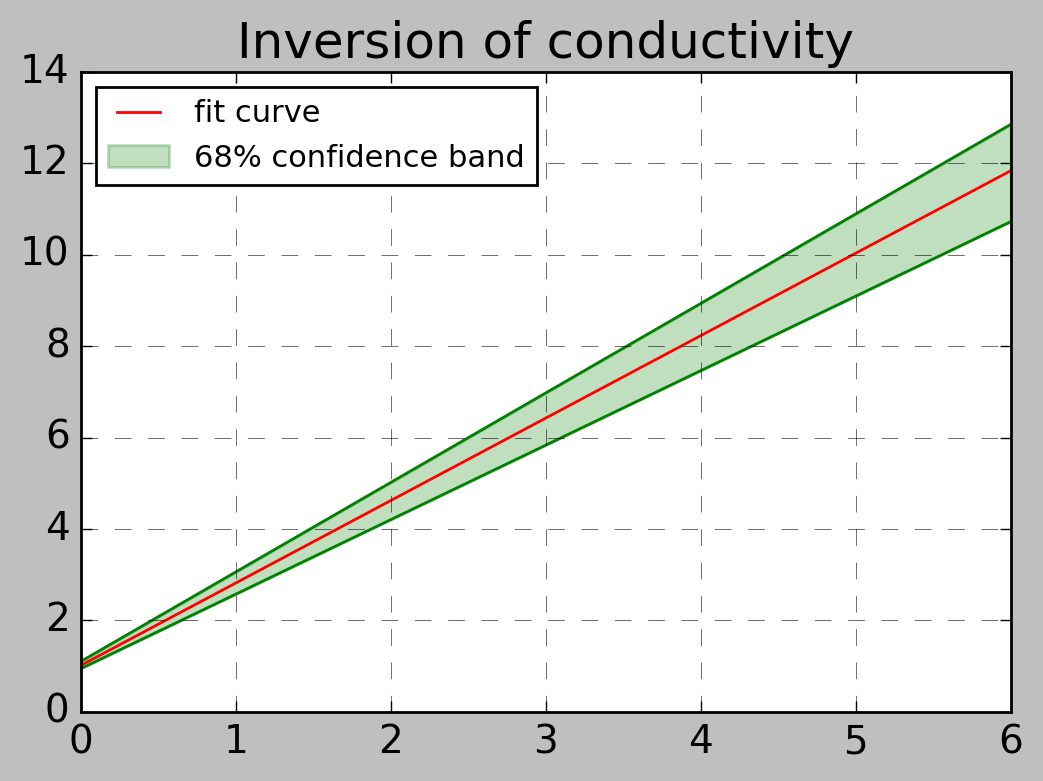

In [30]:
print(1.0238 + 0.0788, 1.0238-0.0788)
print(1.7941+0.1903, 1.7941-0.1903)

fig, ( ax2) = plt.subplots()
#fig, (ax1) = plt.subplots()
x_inv = logspace(-1, 2.,100)
xfine = linspace(0, 6,100)

#for i in range(0,11):
    #ax2.errorbar((1/k[i]), mean(data_vide_2w[i]/(V_nc_vide-data_vide_2w[i])),xerr=(1/k[i])*0.05,yerr=std(data_vide_2w[i]/(V_nc_vide-data_vide_2w[i])),fmt=data_shape[i],markersize=7)
ax2.plot(xfine, line(xfine, popt_v[0], popt_v[1]), 'r-', label = 'fit curve')
ax2.plot(xfine, line(xfine, (1.1026-0.945)/6 + 1.6036, 0.945), 'g-')
ax2.plot(xfine, line(xfine, (0.945-1.1026)/6 + 1.9844, 1.1026), 'g-')
ax2.fill_between(xfine, line(xfine, (1.1026-0.945)/6 + 1.6036, 0.945), line(xfine, (0.945-1.1026)/6 + 1.9844, 1.1026), color='g', alpha=0.25, label = '68% confidence band')

ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax2.legend(loc='best',prop={'size':11}) 
#ax2.set_xlabel('$1/\lambda(m.K/W)$')
#ax2.set_ylabel('$V_{contact}/(V_{0}-V_{contact})$')


#ax1.text(0.5,3.5, 'Air')
#ax.set_xscale('log')
ax2.set_title('Inversion of conductivity', fontsize=18)

#ax.set_title('Calibration curve 1µm of diameter probe', fontsize=14)
fig.set_size_inches(6, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Vacuum_newSubtrate_error_estimation3.png", dpi=400,bbox_inches="tight")
plt.savefig('Vacuum_newSubtrate_error_estimation3.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

# Monte-Carlo error analysis

In [58]:
nTrials = 5000
aFitPars = array([])
nMeasure = size(data_vide_2w)
xTrial = empty([nMeasure])
yTrial = empty([nMeasure])
vGuess = [1.8,1.0]

for iTrial in range(nTrials):
    for i in range(0,nMeasure):
        xTrial[i] = 1/(k[i] + random.normal(scale=k[i]*0.05,size=1))
        yTrial[i] = mean(data_vide_2w[i]) + random.normal(scale=std(data_vide_2w[i]),size=1)
        yTrial[i] = yTrial[i]/(V_nc_vide-yTrial[i])
 
    try:
        vTrial, aCova = curve_fit(line, xTrial, yTrial,vGuess)
    except:
        dumdum=1
        continue  # This moves us to the next loop without stacking.
    
    #here follows the syntax for stacking the trial onto the running sample:
    if size(aFitPars) < 1:
        aFitPars=copy(vTrial)
    else:
        aFitPars = vstack(( aFitPars, vTrial ))


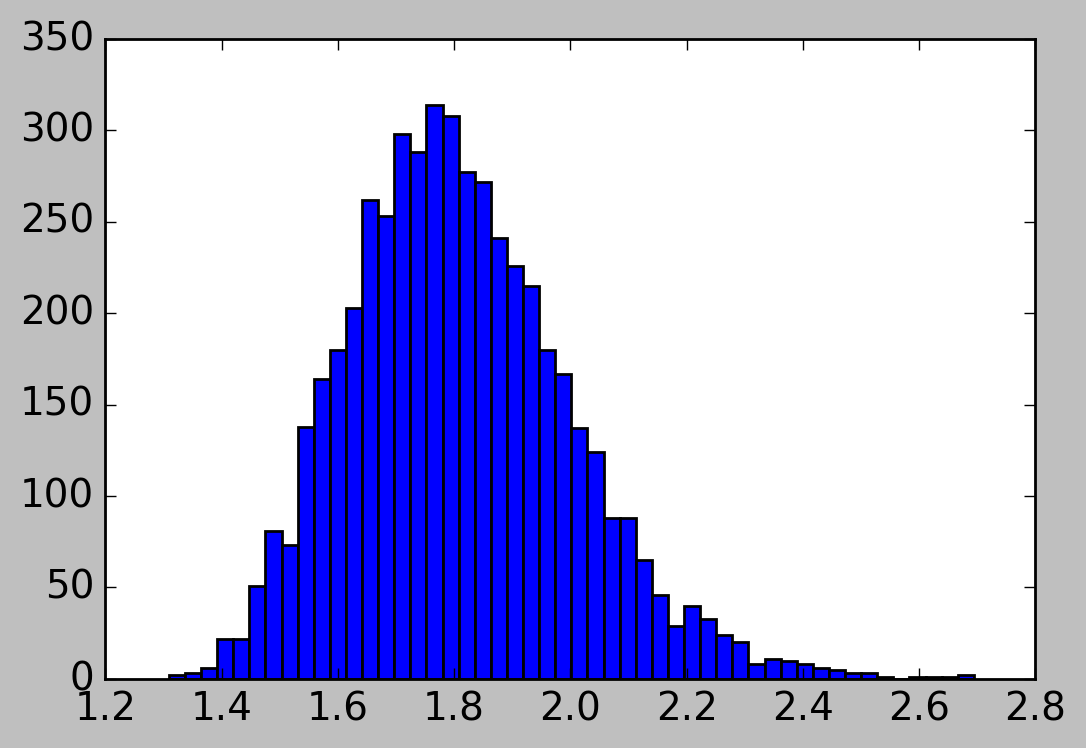

In [61]:
fig, (ax) = plt.subplots()
ax.hist(aFitPars[:,0],bins=50)
fig.set_size_inches(6, 4)

In [229]:
from scipy.stats import kde
x,y=aFitPars.T

# Use a kernel density estimator to produce local-counts in this space, and grid them to plot.
k_de = kde.gaussian_kde(aFitPars.T)
nbins=200
xi, yi = mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k_de(vstack([xi.flatten(), yi.flatten()]))

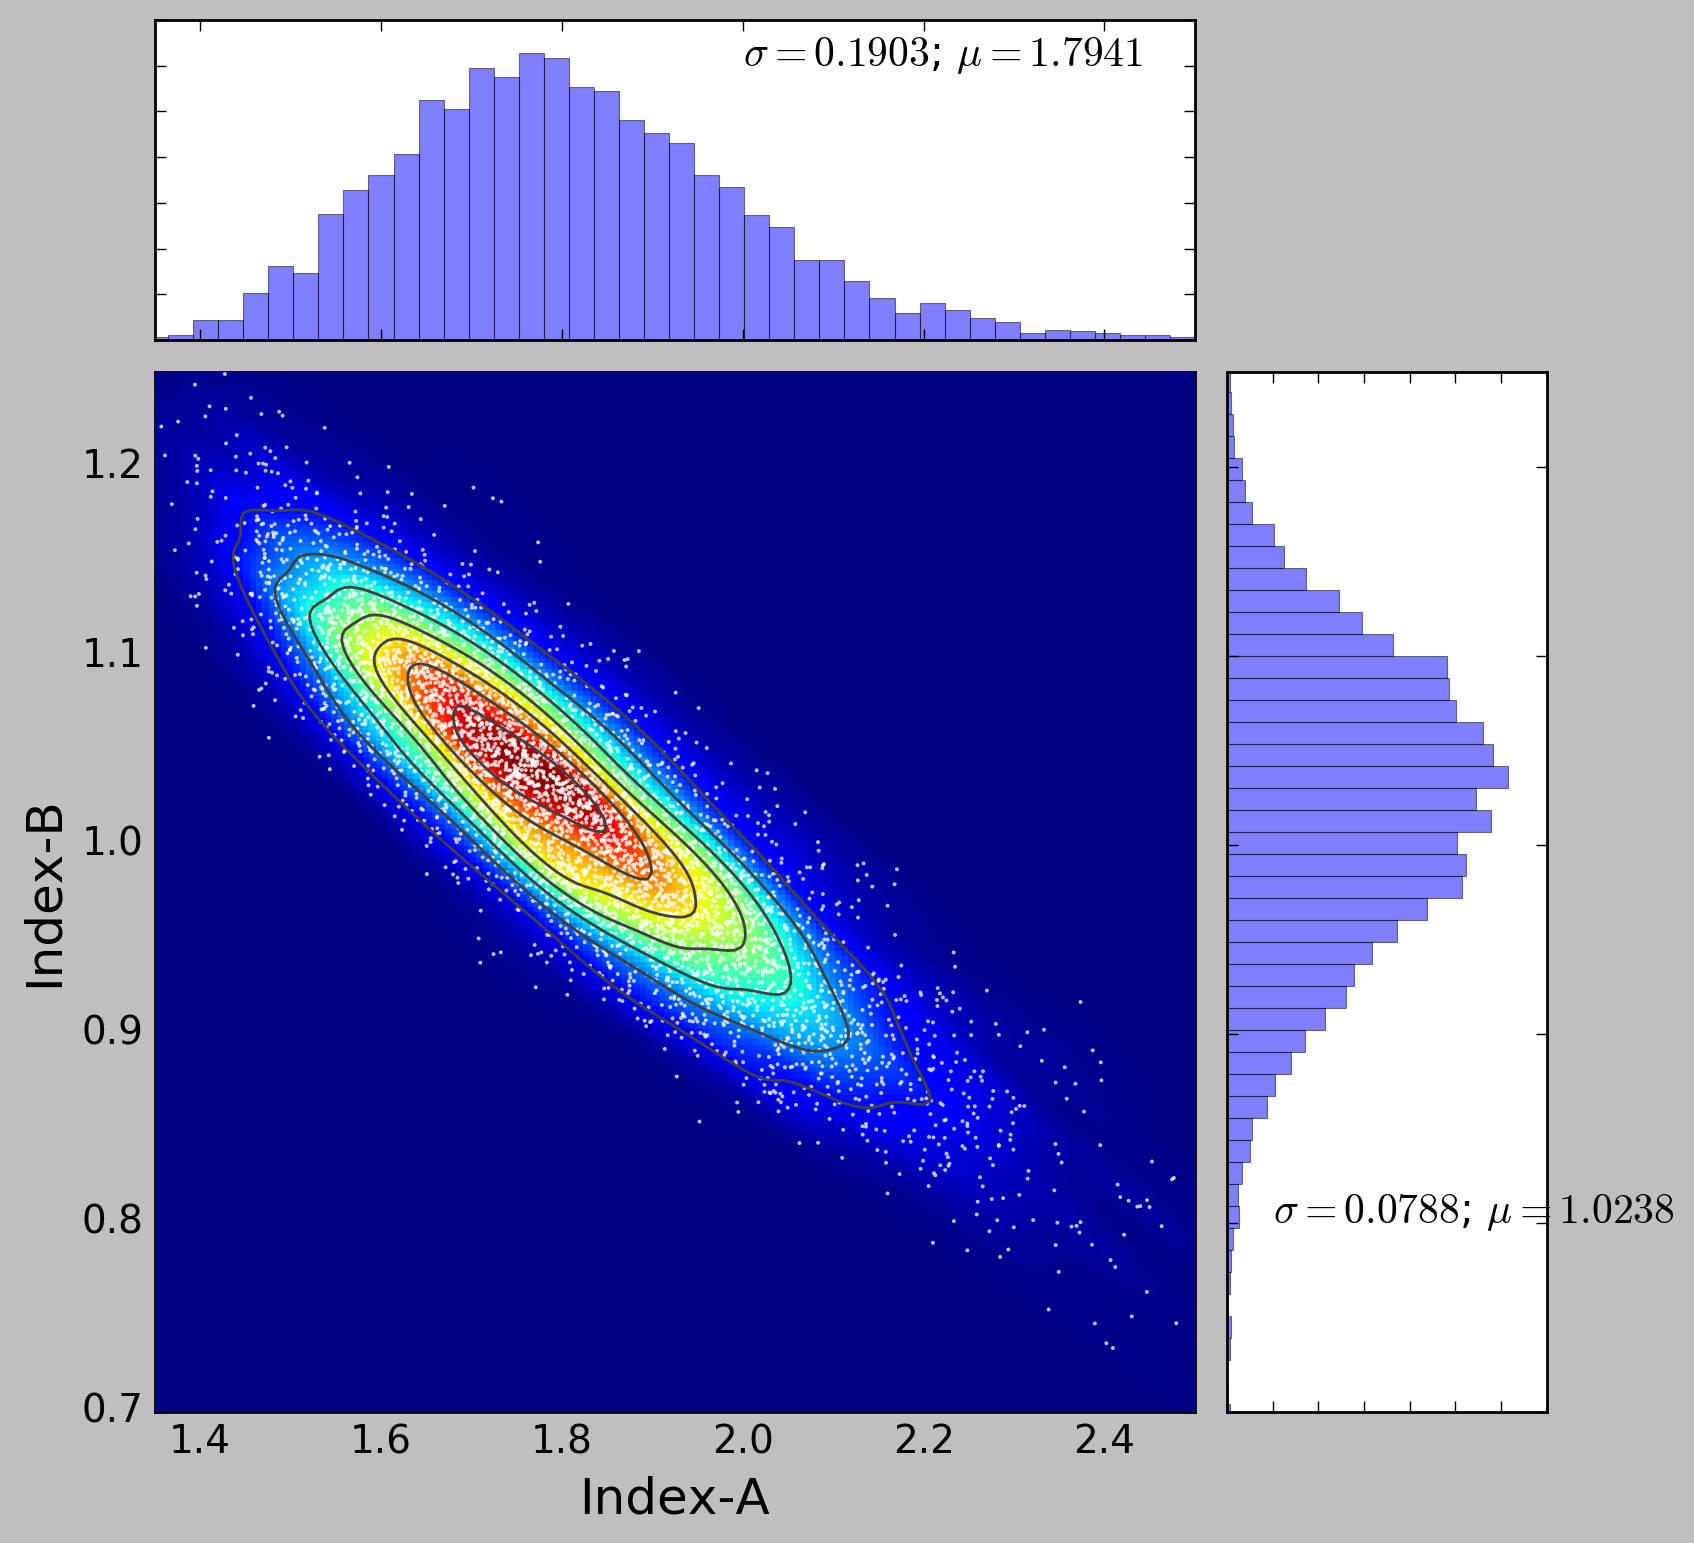

In [223]:
#fig, (ax) = plt.subplots()
#ax.scatter(aFitPars[:,0], aFitPars[:,1],color='red',alpha=0.3, s=9, edgecolor='none')

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
fig = plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)


# the scatter plot:
axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), zorder=3)
axScatter.scatter(aFitPars[:,0], aFitPars[:,1], c='w', s=2, zorder=15, edgecolor='none',alpha=0.75)
axScatter.contour(xi,yi,zi.reshape(xi.shape), zorder=25, colors='0.25')

# now determine nice limits by hand:
binwidth = 0.25
xymax = max([max(fabs(aFitPars[:,0])), max(fabs(aFitPars[:,1]))])

axScatter.set_xlabel('Index-A')
axScatter.set_ylabel('Index-B')
axScatter.set_xlim((1.35, 2.5))
axScatter.set_ylim((0.7, 1.25))

#bins = arange(-lim, lim + binwidth, binwidth)
axHistx.hist(aFitPars[:,0], edgecolor='k',linewidth=0.4,bins=50,alpha=0.5)
axHisty.hist(aFitPars[:,1], edgecolor='k',linewidth=0.4,bins=50,alpha=0.5, orientation='horizontal')
axHistx.text(2.0, 300, '$\sigma = ' + str(round(std(aFitPars[:,0]),4)) + '$'+'; '+'$\mu = ' + str(round(median(aFitPars[:,0]),4)) + '$', fontsize=15)
axHisty.text(50, 0.8, '$\sigma = ' + str(round(std(aFitPars[:,1]),4)) + '$'+'; '+'$\mu = ' + str(round(median(aFitPars[:,1]),4)) + '$', fontsize=15)

axHistx.set_yticklabels([])
axHistx.set_xticklabels([])
axHisty.set_yticklabels([])
axHisty.set_xticklabels([])

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
fig.savefig("Parameter_Va.png", dpi=150,bbox_inches='tight')
plt.savefig('Parameter_Va.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

In [224]:
savetxt('Parameters_AB_vacuum.txt', aFitPars)

In [303]:
for i in range(0,10):
    print(mean(data_vide_2w[i]))

212.457772727
198.45696
168.071055556
163.45232
153.924
125.69884
129.6244
116.11036
125.30524
124.80104


In [309]:
def measTrial(ratio, A, B):
    return (A/(ratio-B))

def measErrMonteCarlo(V,error,measNum, A, B,V0):
    measMontCarlo = array([])
    for i in range(0,measNum):
        V_measured = V + random.normal(scale=V*error,size=1)
        oneMontCarlo = measTrial(V_measured/(V0-V_measured),A, B)
        if size(measMontCarlo) < 1:
            measMontCarlo=copy(oneMontCarlo)
        else:
            measMontCarlo = vstack(( measMontCarlo, oneMontCarlo ))
    return measMontCarlo

In [322]:
n_point = 40
med_k = empty([n_point]);std_k = empty([n_point])
count = 0
#rati = append(1, linspace(129,213,n_point))
for i in linspace(129,213,n_point):
    meas_multik = measErrMonteCarlo(i,0.02,250, aFitPars[:,0], aFitPars[:,1],V_nc_vide).flatten()
    med_k[count] = median(meas_multik)
    std_k[count] = std(meas_multik)
    count = count+1
print(med_k, std_k)

[ 7.70881075  6.44356603  5.41419484  4.63399433  4.09499297  3.65850194
  3.22087068  2.90513799  2.6304904   2.36491551  2.18637206  1.95422312
  1.81073533  1.69447461  1.53848976  1.41561641  1.31948644  1.20908321
  1.1394341   1.04710342  0.96915376  0.89744123  0.83392187  0.7757553
  0.72263579  0.66156417  0.61478036  0.56934634  0.51352503  0.48256493
  0.446315    0.40534528  0.37311144  0.33751618  0.31082391  0.27561595
  0.24923168  0.22661075  0.2005495   0.17263925] [  1.99649830e+03   1.22537706e+03   4.84353985e+01   1.12331052e+01
   9.76472107e-01   8.27878933e-01   5.77242783e-01   4.67661856e-01
   4.43378509e-01   3.51649968e-01   3.23858343e-01   2.89289781e-01
   2.49660836e-01   2.32861784e-01   2.07201049e-01   1.91950558e-01
   1.74696994e-01   1.71133196e-01   1.48582323e-01   1.39824725e-01
   1.31584044e-01   1.25325372e-01   1.21496543e-01   1.19637279e-01
   1.12319475e-01   9.60098137e-02   9.52576660e-02   9.16470581e-02
   9.09933669e-02   8.13625717

2.24649487735 0.320072501542


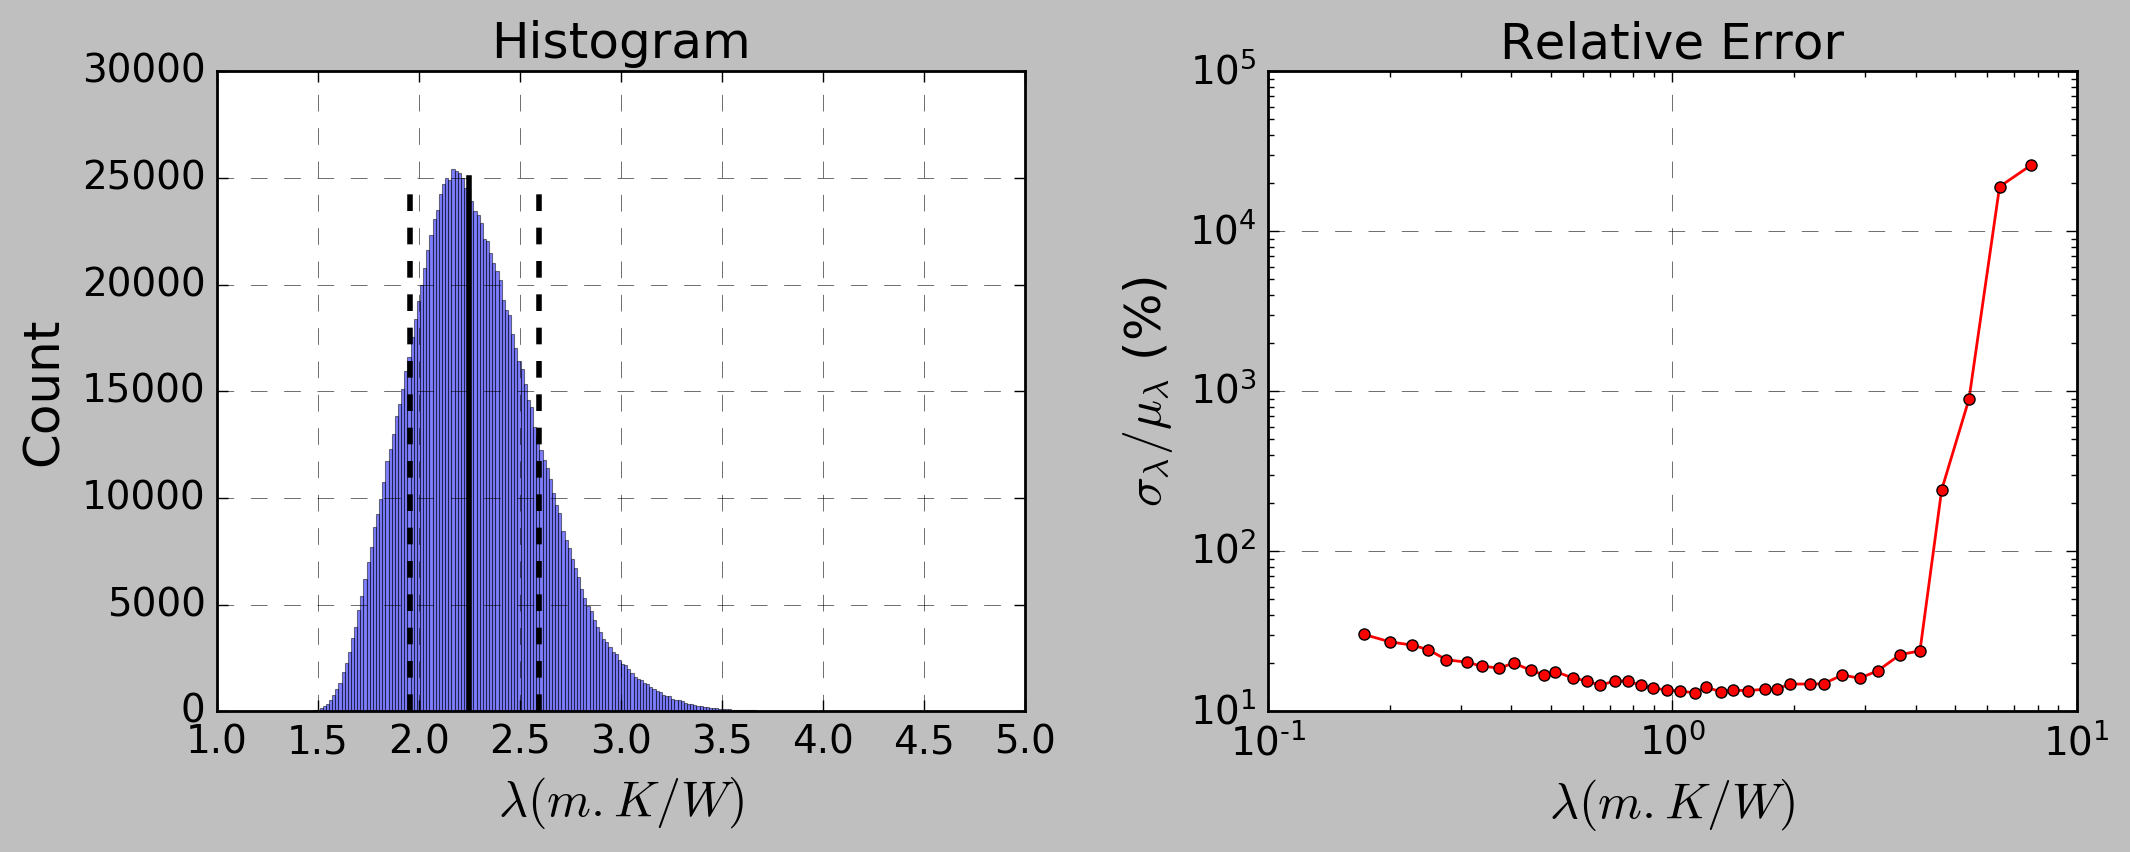

In [323]:
fig, ((ax1,ax2)) = plt.subplots(1,2)
meas_sample_k = measErrMonteCarlo(150,0.02,250, aFitPars[:,0], aFitPars[:,1],V_nc_vide).flatten()
ax1.hist(meas_sample_k,edgecolor='k',linewidth=0.4,bins=200,alpha=0.5)
#ax.hist(meas_k,bins=50)
Med = median(meas_sample_k)
gHi = where(meas_sample_k >= median(meas_sample_k))[0]
gLo = where(meas_sample_k < median(meas_sample_k))[0]

# This trick does the limit-setting - try to see how it works:
vSortLo=sort(meas_sample_k[gLo])
vSortHi=sort(meas_sample_k[gHi])

sLim = 0.68
NormLo = vSortLo[int((1.0-sLim)*size(vSortLo))]
NormHi = vSortHi[int(sLim      *size(vSortHi))]

## Let's take a look - how do those limits look on the histogram?
ax1.plot([Med, Med],[1,25000.0], 'k-', lw=2)
ax1.plot([NormLo, NormLo],[1,25000.0], 'k--', lw=2)
ax1.plot([NormHi, NormHi],[1,25000.0], 'k--', lw=2)
ax1.set_xlabel('$\lambda(m.K/W)$')
ax1.set_ylabel('Count')

ax2.plot(med_k, std_k/med_k*100, 'r-o',markersize=4)
ax2.set_xlabel('$\lambda(m.K/W)$')
ax2.set_ylabel('$\sigma _{\lambda}/\mu _{\lambda}$'+' (%)')
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax1.grid(color='k', linestyle='--', linewidth=0.2)
ax2.set_title('Relative Error', fontsize=18)
ax1.set_title('Histogram', fontsize=18)

fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Error analysis_Va.png", dpi=400,bbox_inches="tight")
plt.savefig('Error analysis_Va.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

print(median(meas_sample_k),std(meas_sample_k))

### $V_{3\omega}$

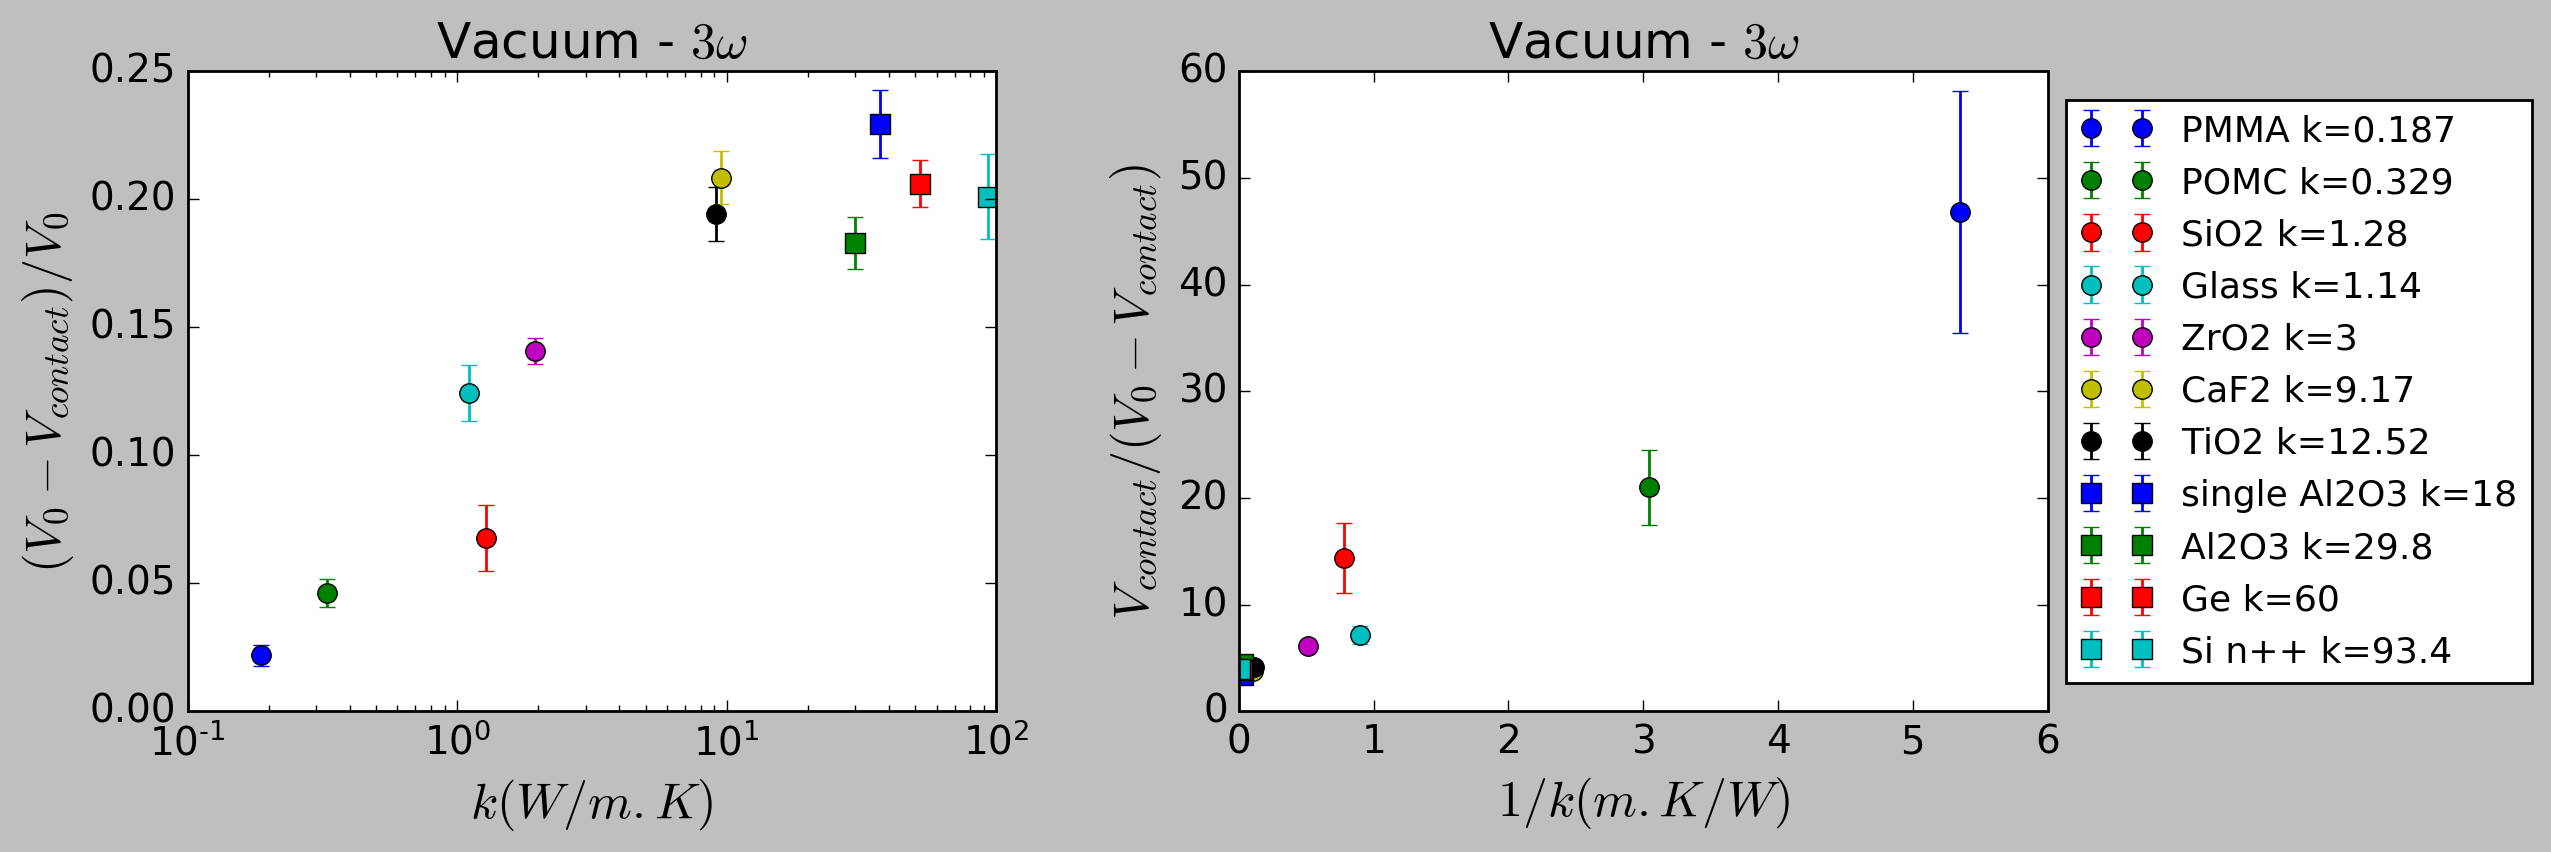

In [12]:
#2-omega plot
V_nc_vide_3w = 870.6
fig, ((ax1, ax2)) = plt.subplots(1, 2)
#fig, (ax1) = plt.subplots()
x_inv = logspace(-1, 2.,100)
xfine = linspace(0, 6,100)
for i in range(0,11):
    #ax1.errorbar((k[i])),mean((V_noncontact-data_vide_2w[i])/V_noncontact),std((V_noncontact-data_vide_2w[i])/V_noncontact),'o',markersize=3,label=label_cal[i])
    ax1.errorbar((k[i]), mean((V_nc_vide_3w-data_vide_3w[i])/V_nc_vide_3w),yerr=std((V_nc_vide_3w-data_vide_3w[i])/V_nc_vide_3w),fmt=data_shape[i],markersize=7,label=label_cal[i])

#ax1.plot(x_inv, 1/(line(1/x_inv, popt_v[0], popt_v[1])+1), 'r-')

#ax1.plot(x_inv, fit_courbe(x_inv, popt_v[0], popt_v[1]), 'r-')
ax1.set_xscale('log')
#ax1.legend(loc='center left',prop={'size':11},bbox_to_anchor=(1, 0.5)) 
ax1.set_xlabel('$k(W/m.K)$')
ax1.set_ylabel('$(V_{0}-V_{contact})/V_{0}$')

for i in range(0,11):
    ax2.errorbar((1/k[i]), mean(data_vide_3w[i]/(V_nc_vide_3w-data_vide_3w[i])),yerr=std(data_vide_3w[i]/(V_nc_vide_3w-data_vide_3w[i])),fmt=data_shape[i],markersize=7,label=label_cal[i])
#ax2.plot(xfine, line(xfine, popt_v[0], popt_v[1]), 'r-')
#ax1.legend(loc='center left',prop={'size':11},bbox_to_anchor=(1, 0.5)) 
ax2.set_xlabel('$1/k(m.K/W)$')
ax2.set_ylabel('$V_{contact}/(V_{0}-V_{contact})$')


#ax1.text(0.5,3.5, 'Air')
#ax.set_xscale('log')
ax1.set_title('Vacuum - '+'$3\omega$', fontsize=18)
ax2.set_title('Vacuum - '+'$3\omega$', fontsize=18)
#fig.savefig("Vide_TH_6_T1.png", dpi=400,bbox_inches="tight")
ax2.legend(loc='center left',prop={'size':13},bbox_to_anchor=(1, 0.5)) 

#ax.set_title('Calibration curve 1µm of diameter probe', fontsize=14)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Vacuum_newSubtrate_3w.png", dpi=400,bbox_inches="tight")
plt.savefig('Vacuum_newSubtrate_3w.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

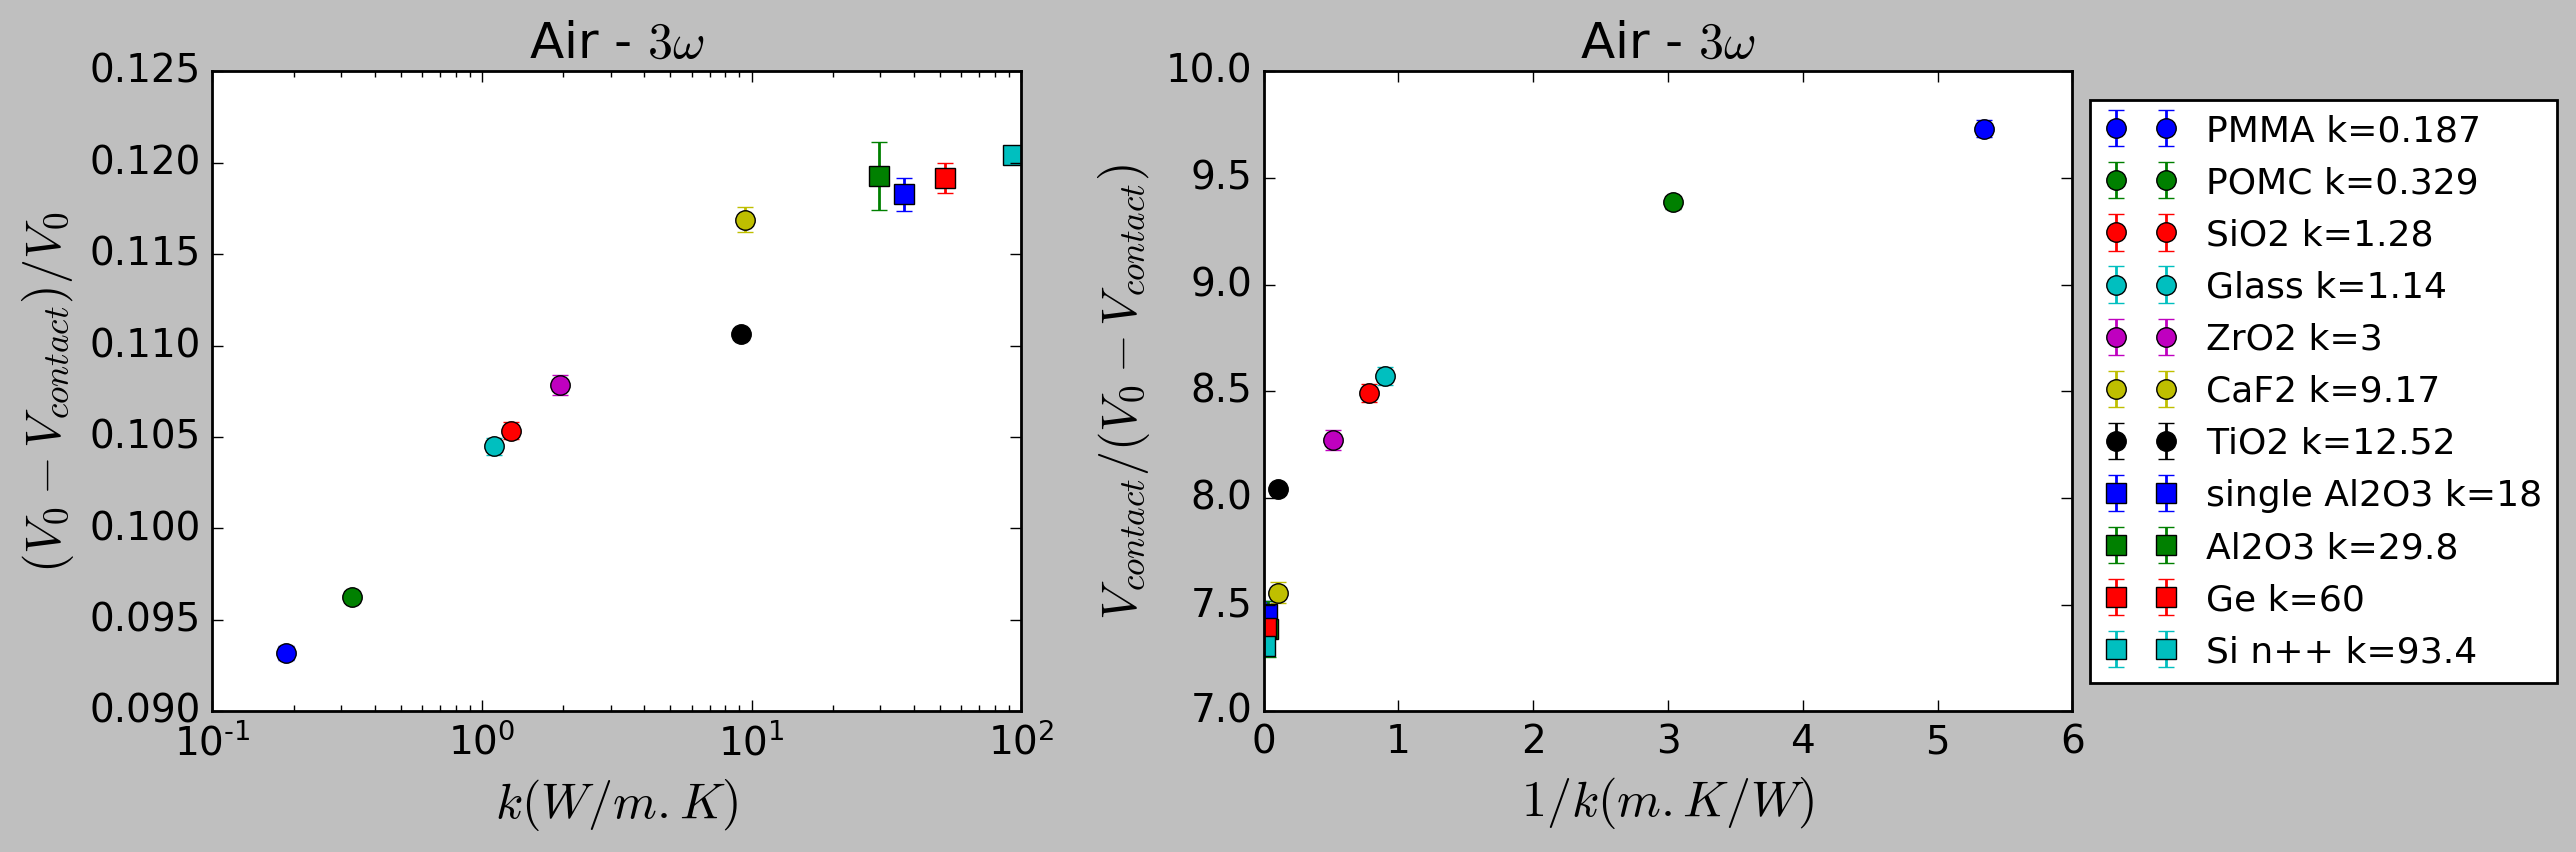

In [13]:
#2-omega plot
V_nc_air_3w = 2903.2
fig, ((ax1, ax2)) = plt.subplots(1, 2)
x_inv = logspace(-1, 2,100)
xfine = logspace(-2, 1,100)
for i in range(0,11):
    ax1.errorbar(k[i], mean((V_nc_air_3w-data_air_3w[i])/V_nc_air_3w),yerr=std((V_nc_air_3w-data_air_3w[i])/V_nc_air_3w),fmt=data_shape[i],markersize=7,label=label_cal[i])

#ax1.plot(x_inv, 1/(peval(1/x_inv,plsq[0])+1), 'r-')
ax1.set_xscale('log')
ax1.set_xlabel('$k(W/m.K)$')
ax1.set_ylabel('$(V_{0}-V_{contact})/V_{0}$')

for i in range(0,11):
    ax2.errorbar((1/k[i]), mean(data_air_3w[i]/(V_nc_air_3w-data_air_3w[i])),yerr=std(data_air_3w[i]/(V_nc_air_3w-data_air_3w[i])),fmt=data_shape[i],markersize=7,label=label_cal[i])
#ax2.plot(xfine, peval(xfine,plsq[0]), 'r-')
ax2.set_xlabel('$1/k(m.K/W)$')
ax2.set_ylabel('$V_{contact}/(V_{0}-V_{contact})$')
ax2.set_xlim([0, 6])

ax1.set_title('Air - '+'$3\omega$', fontsize=18)
ax2.set_title('Air - '+'$3\omega$', fontsize=18)
ax2.legend(loc='center left',prop={'size':13},bbox_to_anchor=(1, 0.5)) 
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Air_newSubtrate_3w.png", dpi=400,bbox_inches="tight")
plt.savefig('Air_newSubtrate_3W.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

## Send to Severine

In [230]:
from scipy.optimize import leastsq

def logistic4(x, A, B, C):
    """4PL lgoistic equation."""
    return A*x/(B+x)+C

def residuals(p, y, x):
    """Deviations of data from fitted 4PL curve"""
    A,B,C = p
    err = y-logistic4(x, A, B, C)
    return err

def peval(x, p):
    """Evaluated value at x with current parameters."""
    A,B,C = p
    return logistic4(x, A, B, C)


y_fit_air_2=(V_nc_air-data_air_2w_2[0])/data_air_2w_2[0]
x_fit_air_2=(k_2[0])*ones(size(data_air_2w_2[0]))
for i in range(1,10):
    y_fit_air_2 = append(y_fit_air_2,(V_nc_air-data_air_2w_2[i])/data_air_2w_2[i])
    x_fit_air_2 = append(x_fit_air_2,(k_2[i])*ones(size(data_air_2w_2[i])))
    #y_fit_air[i] =mean(data_air_2w_3[i]/(V_nc_air-data_air_2w_3[i]))
    

# Initial guess for parameters
p0 = [0.1, 0.1, mean(y_fit_air_2)]

# Fit equation using least squares optimization
plsq, pcov, infodict, errmsg, success = leastsq(residuals, p0, args=(y_fit_air_2, x_fit_air_2),full_output=1)

err_residual = peval(x_fit_air_2,plsq)-y_fit_air_2
ss_res = sum(err_residual**2)
ss_tot = sum((y_fit_air_2-mean(y_fit_air_2))**2)
r_squared = 1 - (ss_res / ss_tot)
perr1 = sqrt(diag(pcov))

print(plsq)
print(pcov)
print(perr1)
print(sqrt(diag(pcov)))
print(r_squared)
print(plsq/K_convair)
print(plsq[0]/K_convair/plsq[1])


[ 0.29800804  1.31107209  0.31072385]
[[  0.06732908  -0.6547579   -0.06295152]
 [ -0.6547579   15.57165735   0.86871469]
 [ -0.06295152   0.86871469   0.07000809]]
[ 0.25947848  3.94609394  0.26459041]
[ 0.25947848  3.94609394  0.26459041]
0.982883230703
[  8.61496974e-07   3.79011465e-06   8.98256478e-07]
6.57093518161e-07


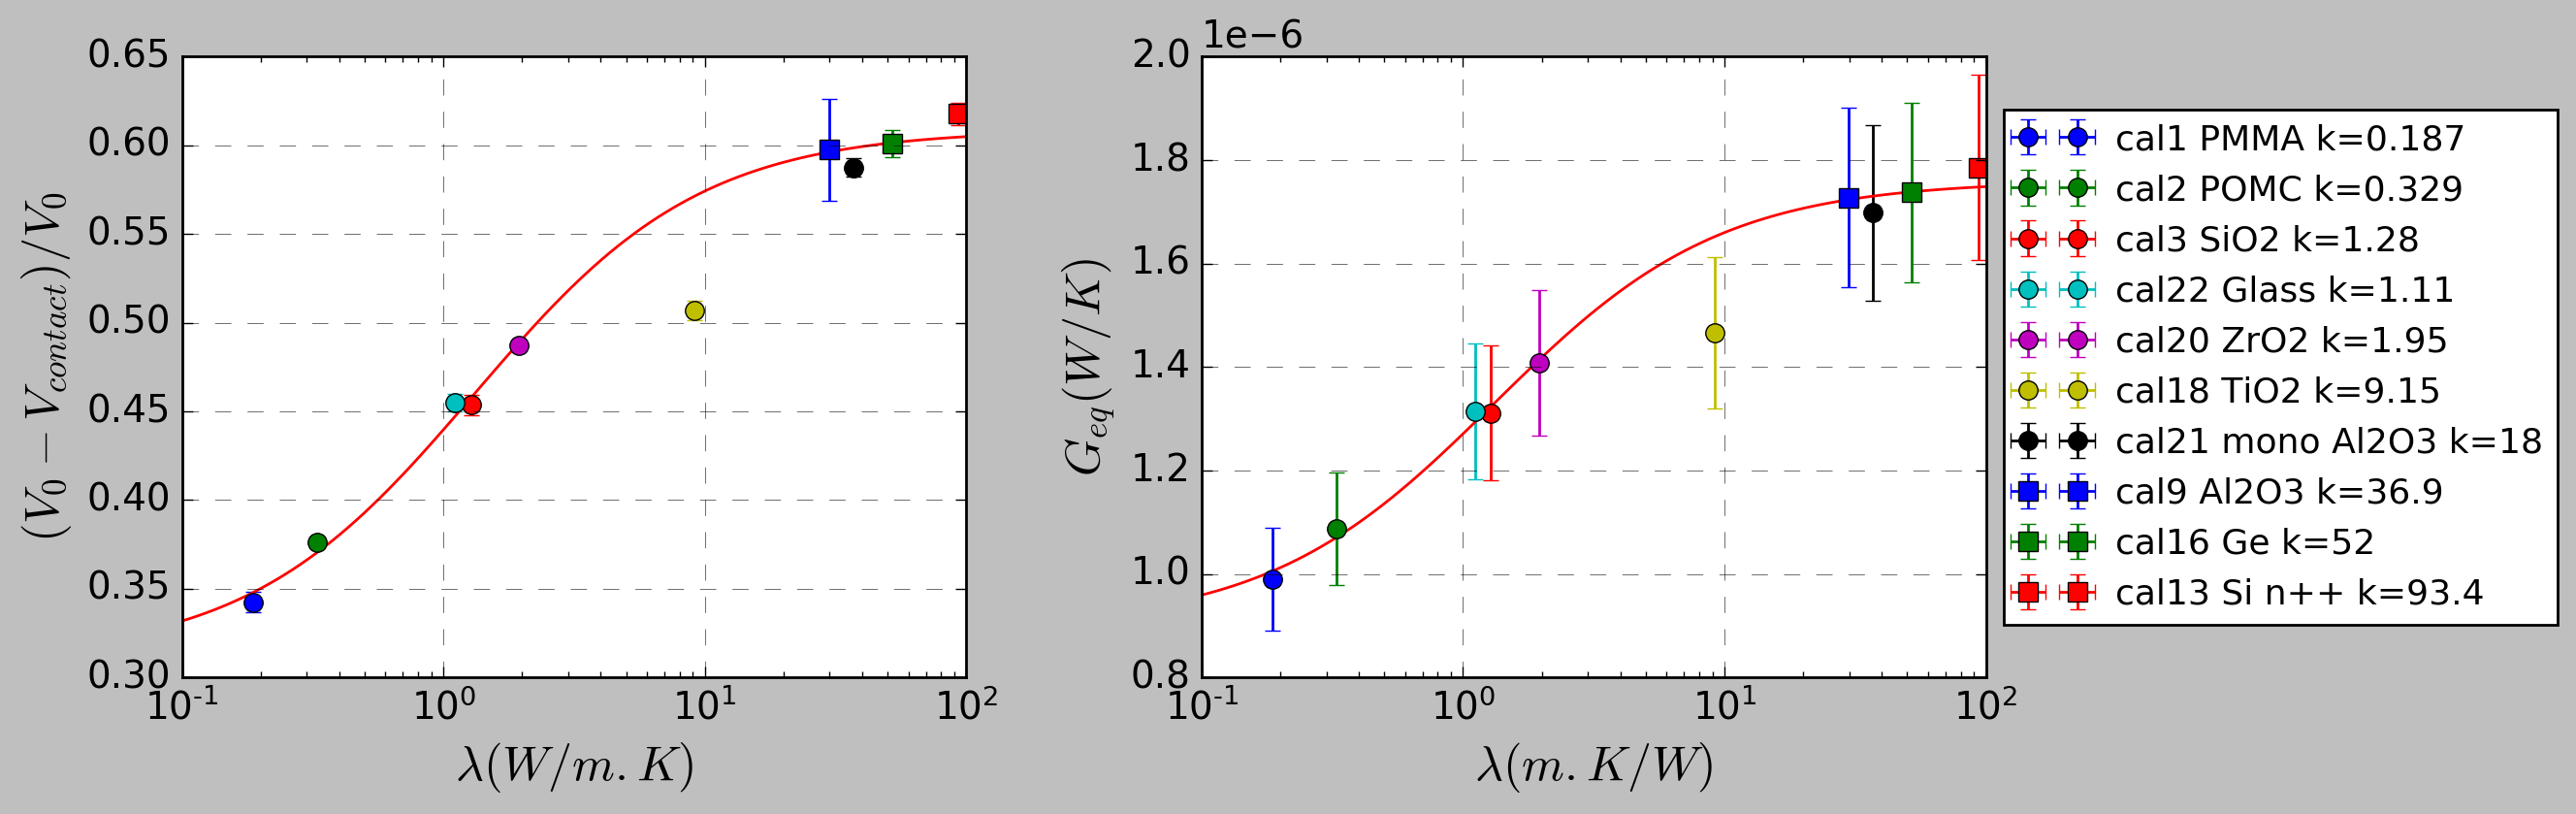

In [231]:
#2-omega plot
fig, ((ax1,ax2)) = plt.subplots(1,2)
x_inv = logspace(-1, 2,100)
xfine = logspace(-2, 1,100)
for i in range(0,10):
    ax1.errorbar(k_3[i], mean((V_nc_air-data_air_2w_3[i])/data_air_2w_3[i]),xerr=k_3[i]*0.05,yerr=std((V_nc_air-data_air_2w_3[i])/data_air_2w_3[i]),fmt=data_shape[i],markersize=7,label=label_cal_3[i])

ax1.plot(x_inv, peval(x_inv,plsq), 'r-')
ax1.set_xscale('log')
ax1.set_xlabel('$\lambda(W/m.K)$')
ax1.set_ylabel('$(V_{0}-V_{contact})/V_{0}$')

for i in range(0,10):
    ax2.errorbar(k_3[i], mean((V_nc_air-data_air_2w_3[i])/data_air_2w_3[i]/K_convair),xerr=k_3[i]*0.05,yerr=0.1*mean((V_nc_air-data_air_2w_3[i])/data_air_2w_3[i]/K_convair),fmt=data_shape[i],markersize=7,label=label_cal_3[i])

ax2.plot(x_inv, peval(x_inv,plsq)/K_convair, 'r-')
ax2.set_xlabel('$\lambda(m.K/W)$')
ax2.set_ylabel('$G_{eq} (W/K)$')
ax2.set_xscale('log')
#ax2.set_xlim([0, 6])
ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax1.grid(color='k', linestyle='--', linewidth=0.2)
#ax2.set_title('Inversion of conductivity', fontsize=18)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#ax1.set_title('Logarithm of conductivity', fontsize=18)
ax2.legend(loc='center left',prop={'size':13},bbox_to_anchor=(1, 0.5)) 
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Air_newSubtrate_fitcurve_Quatiheatmodel.png", dpi=400,bbox_inches="tight")
plt.savefig('Air_newSubtrate_fitcurve_Quatiheatmodel.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

In [31]:
from scipy.optimize import leastsq

def logistic4(x, A, C, D):
    """4PL lgoistic equation."""
    return A*log(x+C)+D

def residuals(p, y, x):
    """Deviations of data from fitted 4PL curve"""
    A,C,D = p
    err = y-logistic4(x, A, C, D)
    return err

def peval(x, p):
    """Evaluated value at x with current parameters."""
    A,C,D = p
    return logistic4(x, A, C, D)

y_fit_air_2=data_air_2w_2[0]/(V_nc_air-data_air_2w_2[0])
x_fit_air_2=(1/k_2[0])*ones(size(data_air_2w_2[0]))
for i in range(1,10):
    y_fit_air_2 = append(y_fit_air_2,data_air_2w_2[i]/(V_nc_air-data_air_2w_2[i]))
    x_fit_air_2 = append(x_fit_air_2,(1/k_2[i])*ones(size(data_air_2w_2[i])))
    #y_fit_air[i] =mean(data_air_2w_3[i]/(V_nc_air-data_air_2w_3[i]))
    

# Initial guess for parameters
p0 = [0, 0.01, 0.5]

# Fit equation using least squares optimization
plsq, pcov, infodict, errmsg, success = leastsq(residuals, p0, args=(y_fit_air_2, x_fit_air_2),full_output=1)

err_residual = peval(x_fit_air_2,plsq)-y_fit_air_2
ss_res = sum(err_residual**2)
ss_tot = sum((y_fit_air_2-mean(y_fit_air_2))**2)
r_squared = 1 - (ss_res / ss_tot)
perr1 = sqrt(diag(pcov))

print(plsq)
print(pcov)
print(perr1)
print(sqrt(diag(pcov)))
print(r_squared)
C = K_convair*plsq
print(C)
print(1/(2*C[0]),plsq[1]/(2*C[0]))

[ 0.4502478   0.33622375  2.12729614]
[[ 0.04215093  0.0804677  -0.053157  ]
 [ 0.0804677   0.17143051 -0.1149296 ]
 [-0.053157   -0.1149296   0.08119293]]
[ 0.20530692  0.41404167  0.28494373]
[ 0.20530692  0.41404167  0.28494373]
0.991226649265
[ 155749.19927518  116306.13128604  735871.82932045]
3.21028937758e-06 1.07937552397e-06


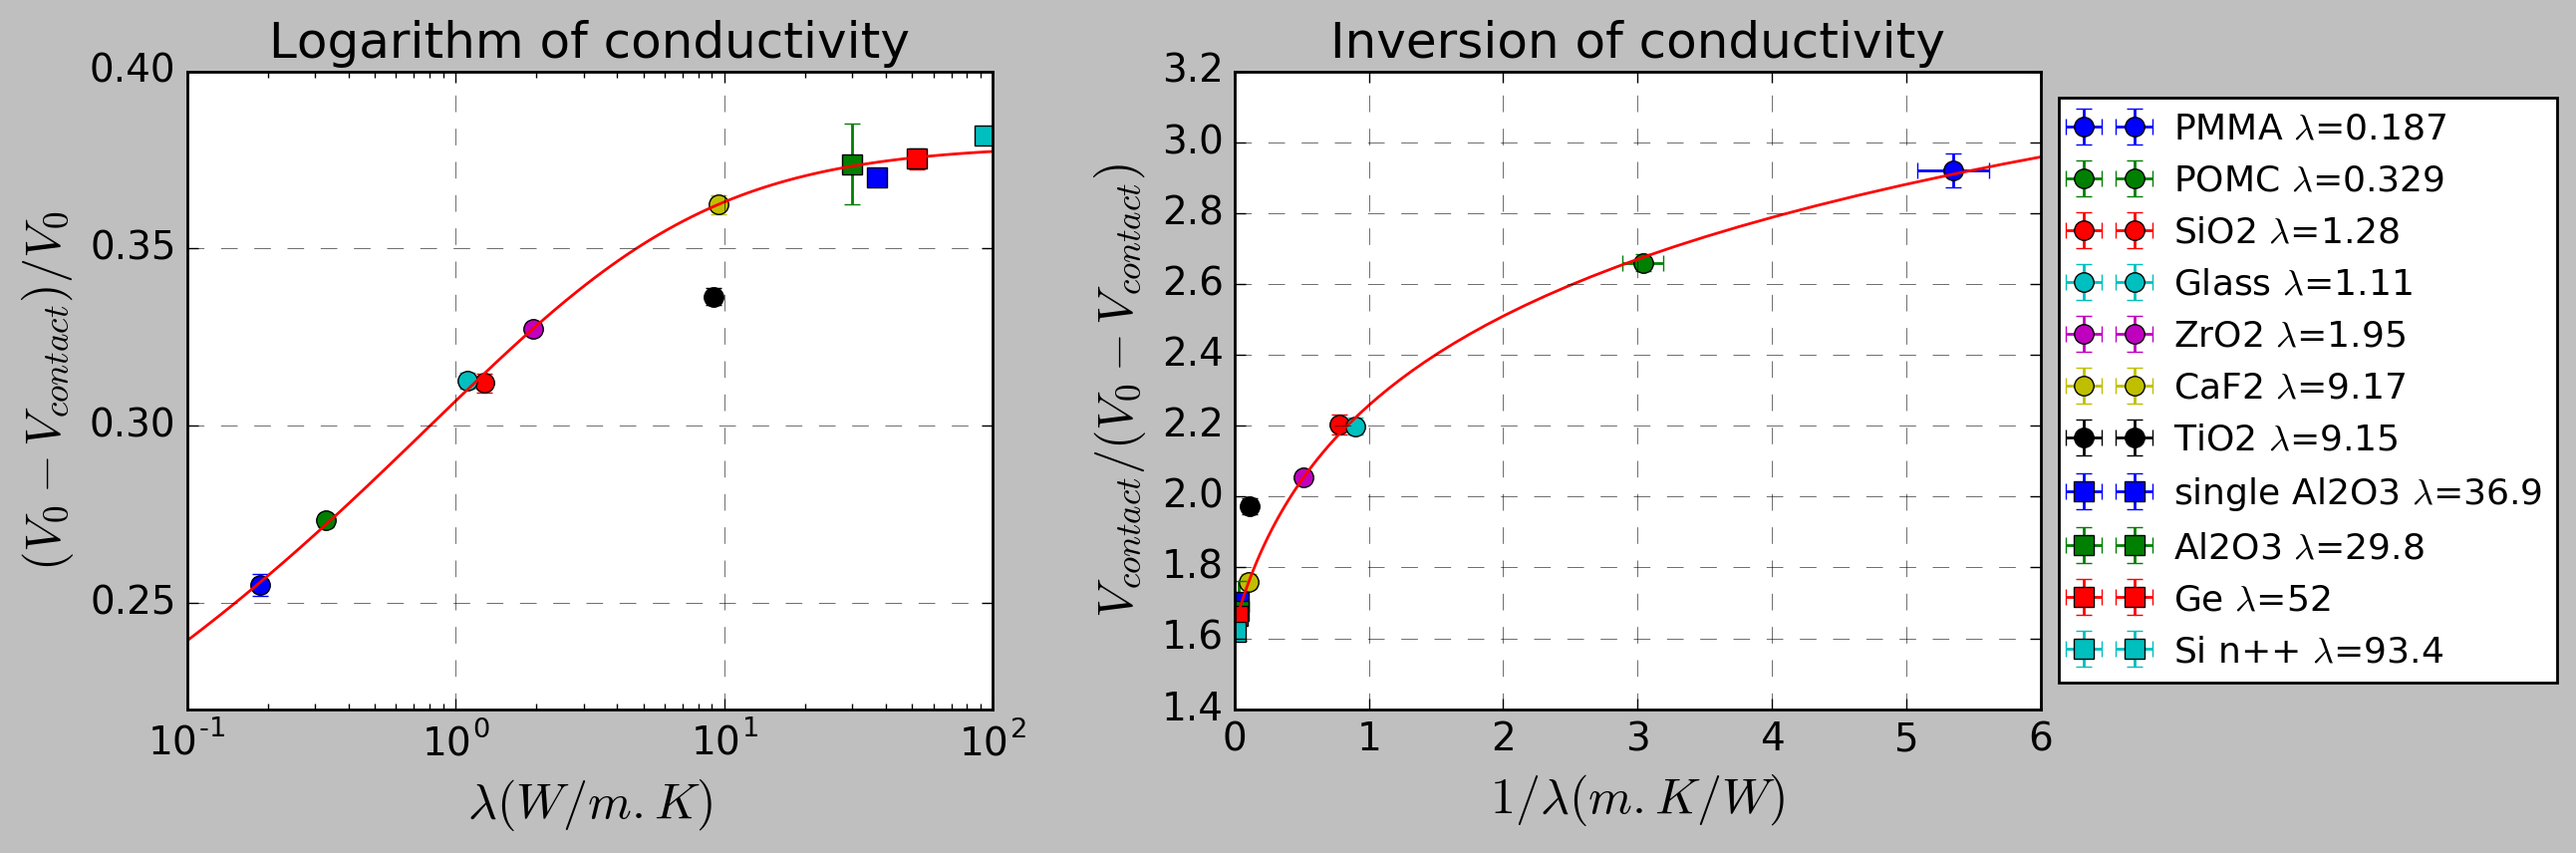

In [32]:
#2-omega plot
fig, ((ax1, ax2)) = plt.subplots(1, 2)
x_inv = logspace(-1, 2,100)
xfine = logspace(-2, 1,100)
for i in range(0,11):
    ax1.errorbar(k[i], mean((V_nc_air-data_air_2w[i])/V_nc_air),xerr=k[i]*0.05,yerr=std((V_nc_air-data_air_2w[i])/V_nc_air),fmt=data_shape[i],markersize=7,label=label_cal[i])

ax1.plot(x_inv, 1/(peval(1/x_inv,plsq)+1), 'r-')
ax1.set_xscale('log')
ax1.set_xlabel('$\lambda(W/m.K)$')
ax1.set_ylabel('$(V_{0}-V_{contact})/V_{0}$')

for i in range(0,11):
    ax2.errorbar((1/k[i]), mean(data_air_2w[i]/(V_nc_air-data_air_2w[i])),xerr=(1/k[i])*0.05,yerr=std(data_air_2w[i]/(V_nc_air-data_air_2w[i])),fmt=data_shape[i],markersize=7,label=label_cal[i])
ax2.plot(xfine, peval(xfine,plsq), 'r-')
ax2.set_xlabel('$1/\lambda(m.K/W)$')
ax2.set_ylabel('$V_{contact}/(V_{0}-V_{contact})$')
ax2.set_xlim([0, 6])
ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax1.grid(color='k', linestyle='--', linewidth=0.2)
ax2.set_title('Inversion of conductivity', fontsize=18)
ax1.set_title('Logarithm of conductivity', fontsize=18)
ax2.legend(loc='center left',prop={'size':13},bbox_to_anchor=(1, 0.5)) 
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Air_newSubtrate.png", dpi=400,bbox_inches="tight")
plt.savefig('Air_newSubtrate.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

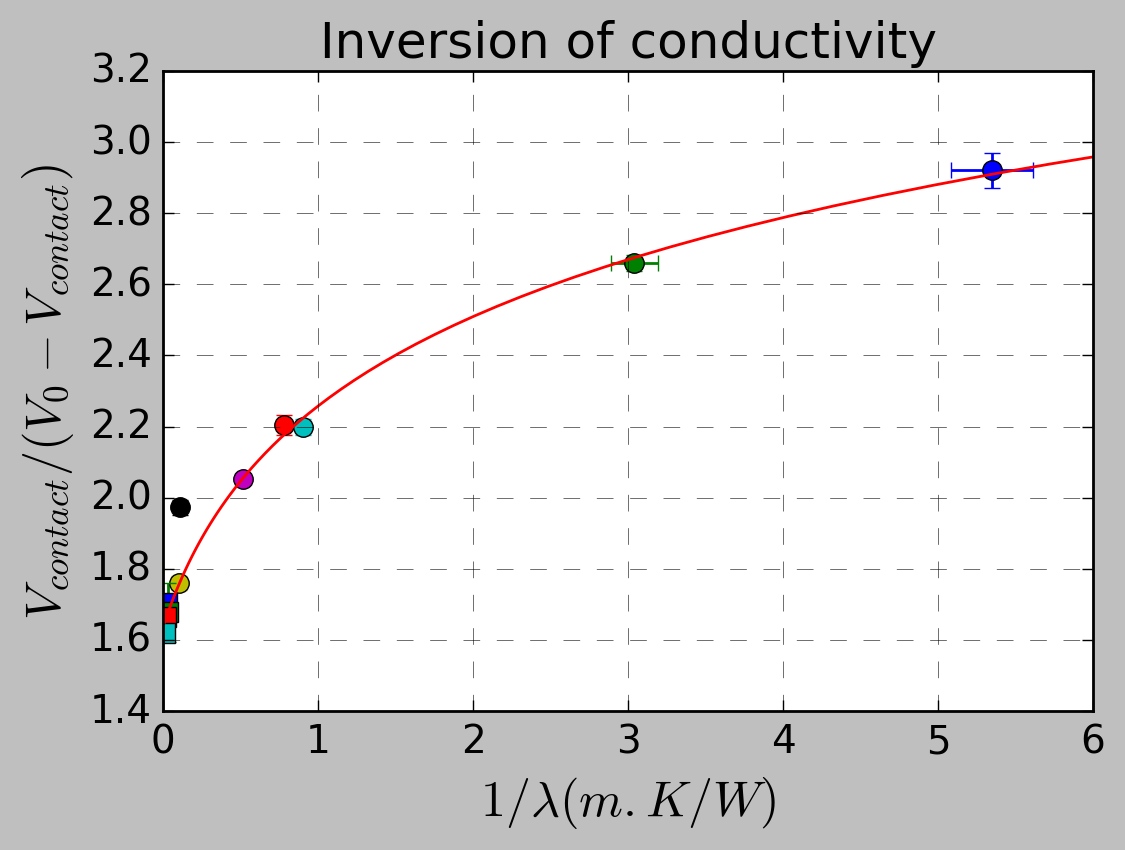

In [34]:
#2-omega plot
fig, ( ax2) = plt.subplots()
x_inv = logspace(-1, 2,100)
xfine = logspace(-2, 1,100)
for i in range(0,11):
    ax1.errorbar(k[i], mean((V_nc_air-data_air_2w[i])/V_nc_air),xerr=k[i]*0.05,yerr=std((V_nc_air-data_air_2w[i])/V_nc_air),fmt=data_shape[i],markersize=7,label=label_cal[i])

ax1.plot(x_inv, 1/(peval(1/x_inv,plsq)+1), 'r-')
ax1.set_xscale('log')
ax1.set_xlabel('$\lambda(W/m.K)$')
ax1.set_ylabel('$(V_{0}-V_{contact})/V_{0}$')

for i in range(0,11):
    ax2.errorbar((1/k[i]), mean(data_air_2w[i]/(V_nc_air-data_air_2w[i])),xerr=(1/k[i])*0.05,yerr=std(data_air_2w[i]/(V_nc_air-data_air_2w[i])),fmt=data_shape[i],markersize=7,label=label_cal[i])
ax2.plot(xfine, peval(xfine,plsq), 'r-')
ax2.set_xlabel('$1/\lambda(m.K/W)$')
ax2.set_ylabel('$V_{contact}/(V_{0}-V_{contact})$')
ax2.set_xlim([0, 6])
ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax1.grid(color='k', linestyle='--', linewidth=0.2)
ax2.set_title('Inversion of conductivity', fontsize=18)
ax1.set_title('Logarithm of conductivity', fontsize=18)
#ax2.legend(loc='center left',prop={'size':13},bbox_to_anchor=(1, 0.5)) 
fig.set_size_inches(6, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Air_newSubtrate.png", dpi=400,bbox_inches="tight")
plt.savefig('Air_newSubtrate.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

In [37]:
plsq

array([ 0.4502478 ,  0.33622375,  2.12729614])

2.1758 2.0772
0.4921 0.4063
0.41559999999999997 0.256


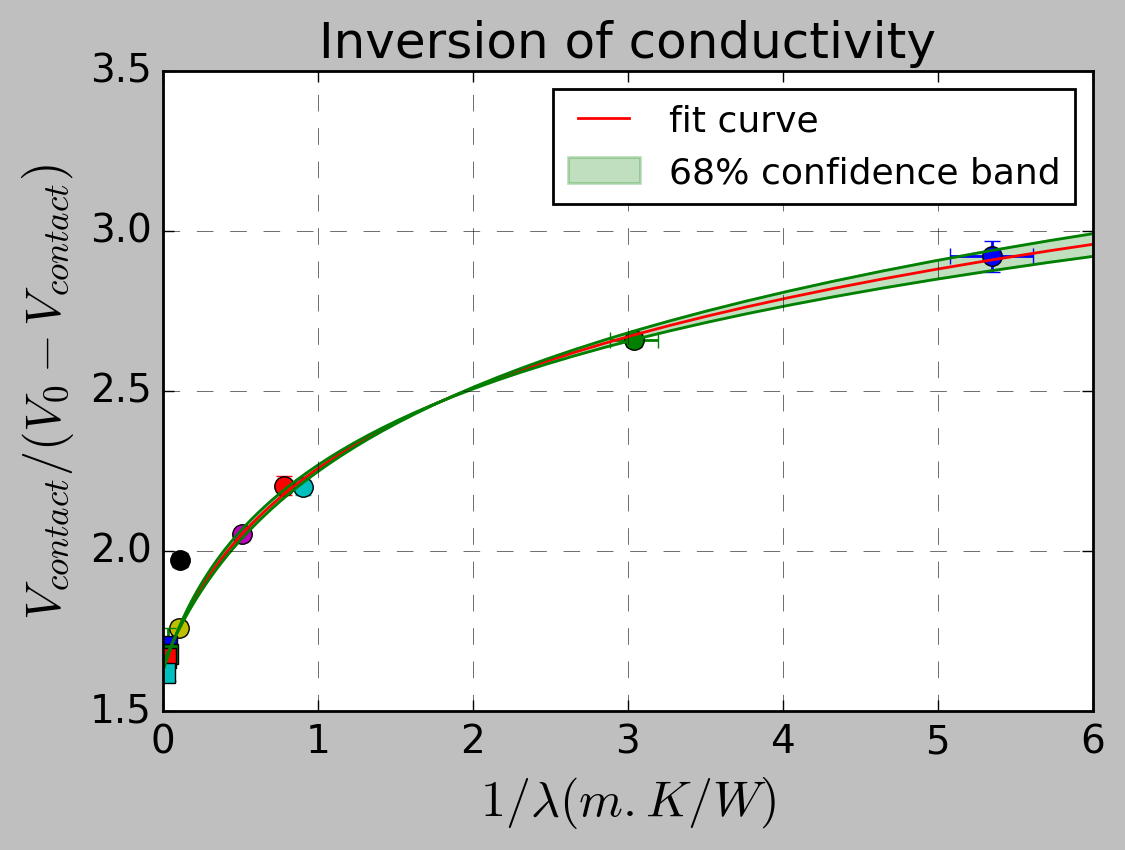

In [44]:
print(2.1265 + 0.0493, 2.1265-0.0493)
print(0.4492+0.0429, 0.4492-0.0429)
print(0.3358+0.0798, 0.3358-0.0798)

P1 = array([0.4921, 0.4156, 2.0772])
P2 = array([0.4063, 0.256, 2.1758])

#2-omega plot
fig, ( ax2) = plt.subplots()
x_inv = logspace(-1, 2,100)
xfine = logspace(-2, 1,100)

for i in range(0,11):
    ax2.errorbar((1/k[i]), mean(data_air_2w[i]/(V_nc_air-data_air_2w[i])),xerr=(1/k[i])*0.05,yerr=std(data_air_2w[i]/(V_nc_air-data_air_2w[i])),fmt=data_shape[i],markersize=7)
ax2.plot(xfine, peval(xfine,plsq), 'r-', label='fit curve')

ax2.plot(xfine, peval(xfine,P1), 'g-')
ax2.plot(xfine, peval(xfine,P2), 'g-')
ax2.fill_between(xfine, peval(xfine,P1), peval(xfine,P2), color='g', alpha=0.25, label = '68% confidence band')


ax2.set_xlabel('$1/\lambda(m.K/W)$')
ax2.set_ylabel('$V_{contact}/(V_{0}-V_{contact})$')
ax2.set_xlim([0, 6])
ax2.grid(color='k', linestyle='--', linewidth=0.2)


ax2.set_title('Inversion of conductivity', fontsize=18)
ax2.legend(loc='best',prop={'size':13}) 
fig.set_size_inches(6, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Air_newSubtrate.png", dpi=400,bbox_inches="tight")
plt.savefig('Air_newSubtrate.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

# Monte-Carlo error analysis

In [244]:
# caculated A,B,C distribution
nTrials = 5000 # number of random set measurement
airFitPars = array([]) # A,B,C matrix
nMeasure = size(k_2)
xTrial = empty([nMeasure])
yTrial = empty([nMeasure])
p0 = [0.4, 0.1, 1]

for iTrial in range(nTrials):
    for i in range(0,nMeasure): #loop for ith mataerials
        # random number for thermal conductivity
        xTrial[i] = 1/(k_2[i] + random.normal(scale=k_2[i]*0.05,size=1)) 
        # random number for simulated voltage
        yTrial[i] = mean(data_air_2w_2[i]) + random.normal(scale=std(data_air_2w_2[i]),size=1) 
        # ratio DeltaV/V caculated
        yTrial[i] = yTrial[i]/(V_nc_air-yTrial[i])
        
    try:
        vTrial, aCova, infodict, errmsg, success = leastsq(residuals, p0, args=(yTrial, xTrial),full_output=1)
        
    except:
        dumdum=1
        continue  # This moves us to the next loop without stacking.
    
    #here follows the syntax for stacking the trial onto the running sample:
    if size(airFitPars) < 1:
        airFitPars=copy(vTrial)
    else:
        airFitPars = vstack(( airFitPars, vTrial ))


In [243]:
print(airFitPars)

[[ 0.45001052  0.34009886  2.12235989]
 [ 0.45445771  0.37062721  2.09351372]
 [ 0.48137313  0.34791649  2.12864321]
 [ 0.48618815  0.41258837  2.06663361]
 [ 0.44161746  0.34063543  2.1124545 ]]


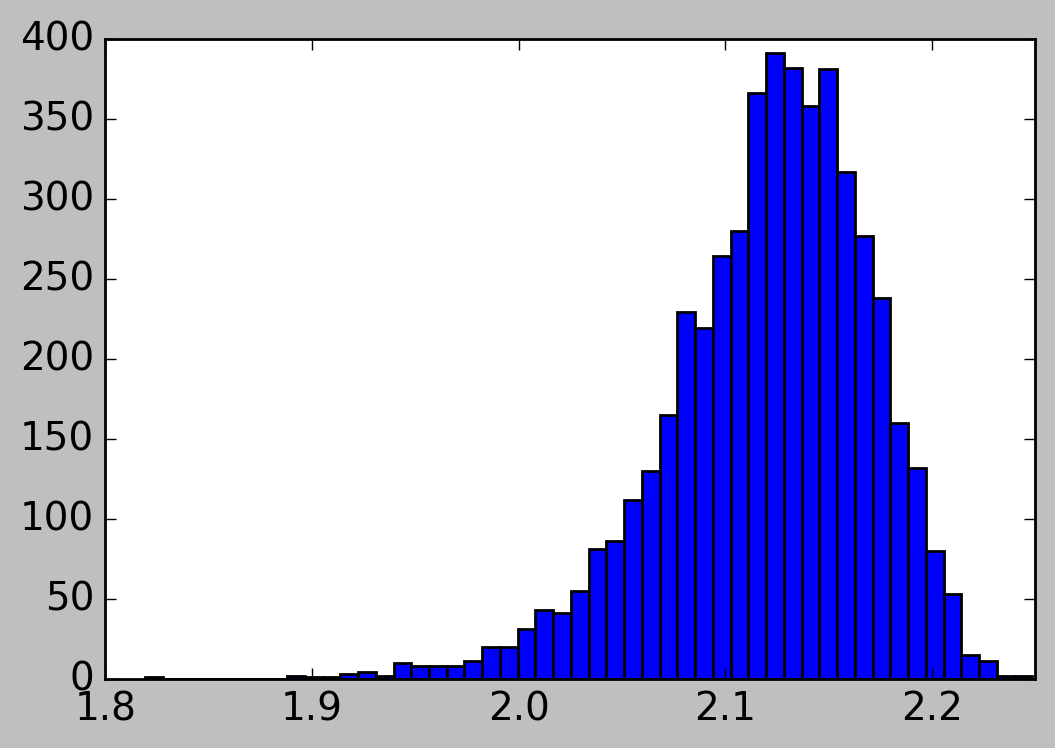

In [261]:
fig, (ax) = plt.subplots()
ax.hist(airFitPars[:,2],bins=50)
fig.set_size_inches(6, 4)

In [263]:
x,y,z=airFitPars.T

# Use a kernel density estimator to produce local-counts in this space, and grid them to plot.
k_de = kde.gaussian_kde(vstack(( x, y )))
nbins=200
xi, yi = mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
ci = k_de(vstack([xi.flatten(), yi.flatten()]))

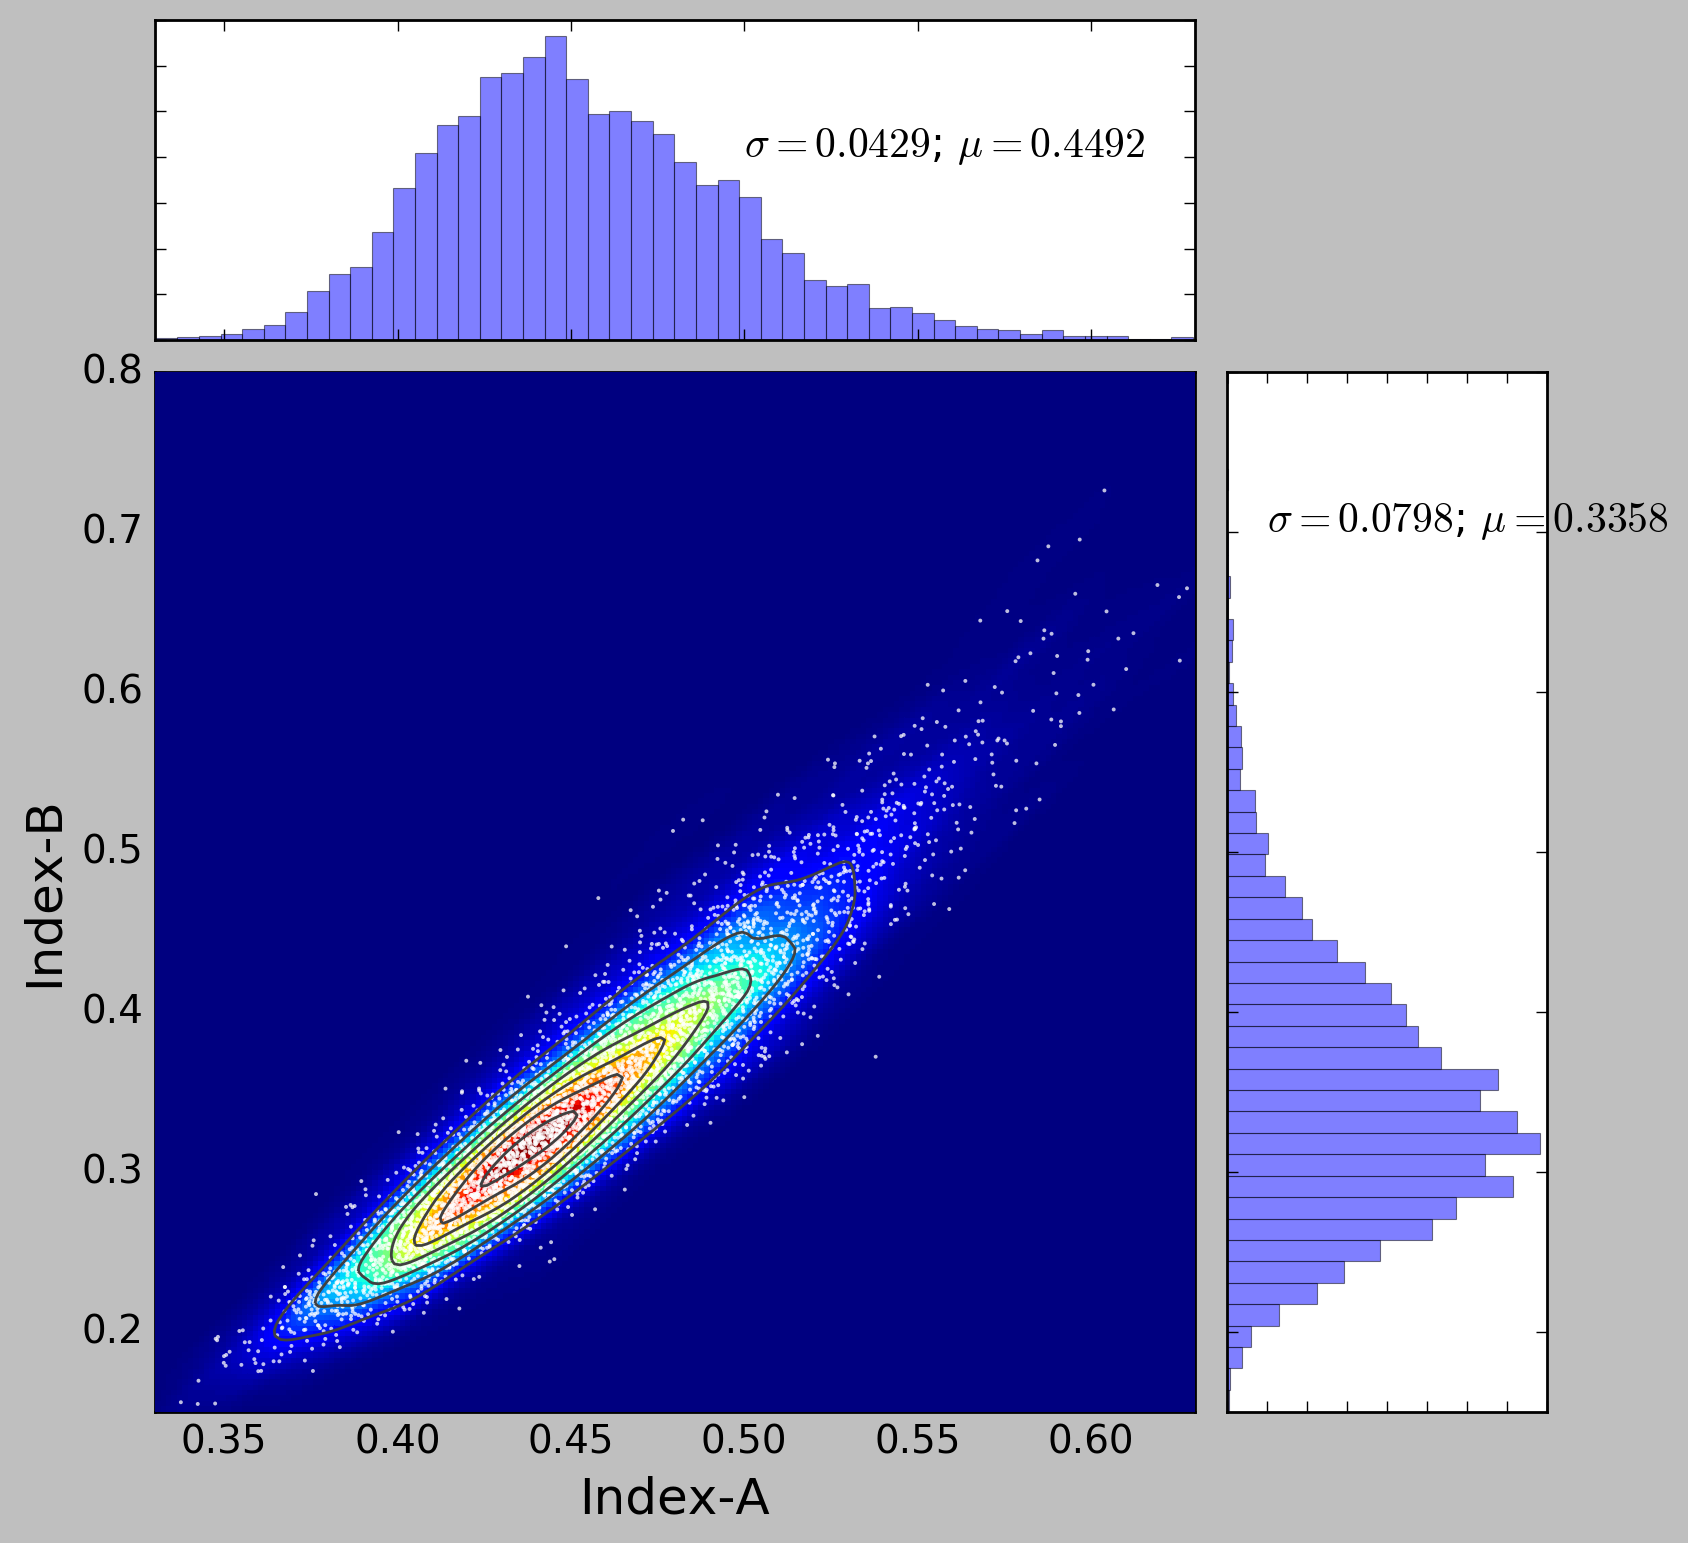

In [269]:
#fig, (ax) = plt.subplots()
#ax.scatter(aFitPars[:,0], aFitPars[:,1],color='red',alpha=0.3, s=9, edgecolor='none')

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
fig = plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)


# the scatter plot:
axScatter.pcolormesh(xi, yi, ci.reshape(xi.shape), zorder=3)
axScatter.scatter(airFitPars[:,0], airFitPars[:,1], c='w', s=2, zorder=15, edgecolor='none',alpha=0.75)
axScatter.contour(xi,yi,ci.reshape(xi.shape), zorder=25, colors='0.25')

# now determine nice limits by hand:
binwidth = 0.25
xymax = max([max(fabs(aFitPars[:,0])), max(fabs(aFitPars[:,1]))])

axScatter.set_xlabel('Index-A')
axScatter.set_ylabel('Index-B')
axScatter.set_xlim((0.33,0.63))
axScatter.set_ylim((0.15, 0.8))

#bins = arange(-lim, lim + binwidth, binwidth)
axHistx.hist(airFitPars[:,0], edgecolor='k',linewidth=0.4,bins=50,alpha=0.5)
axHisty.hist(airFitPars[:,1], edgecolor='k',linewidth=0.4,bins=50,alpha=0.5, orientation='horizontal')
axHistx.text(0.5, 200, '$\sigma = ' + str(round(std(airFitPars[:,0]),4)) + '$'+'; '+'$\mu = ' + str(round(median(airFitPars[:,0]),4)) + '$', fontsize=15)
axHisty.text(50, 0.7, '$\sigma = ' + str(round(std(airFitPars[:,1]),4)) + '$'+'; '+'$\mu = ' + str(round(median(airFitPars[:,1]),4)) + '$', fontsize=15)

axHistx.set_yticklabels([])
axHistx.set_xticklabels([])
axHisty.set_yticklabels([])
axHisty.set_xticklabels([])

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
fig.savefig("Parameter_Ai_ab.png", dpi=150,bbox_inches='tight')
plt.savefig('Parameter_Ai_ab.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

In [265]:
x,y,z=airFitPars.T

# Use a kernel density estimator to produce local-counts in this space, and grid them to plot.
k_dei = kde.gaussian_kde(vstack(( x, z )))
nbins=200
xi, zi = mgrid[x.min():x.max():nbins*1j, z.min():z.max():nbins*1j]
cii = k_dei(vstack([xi.flatten(), zi.flatten()]))

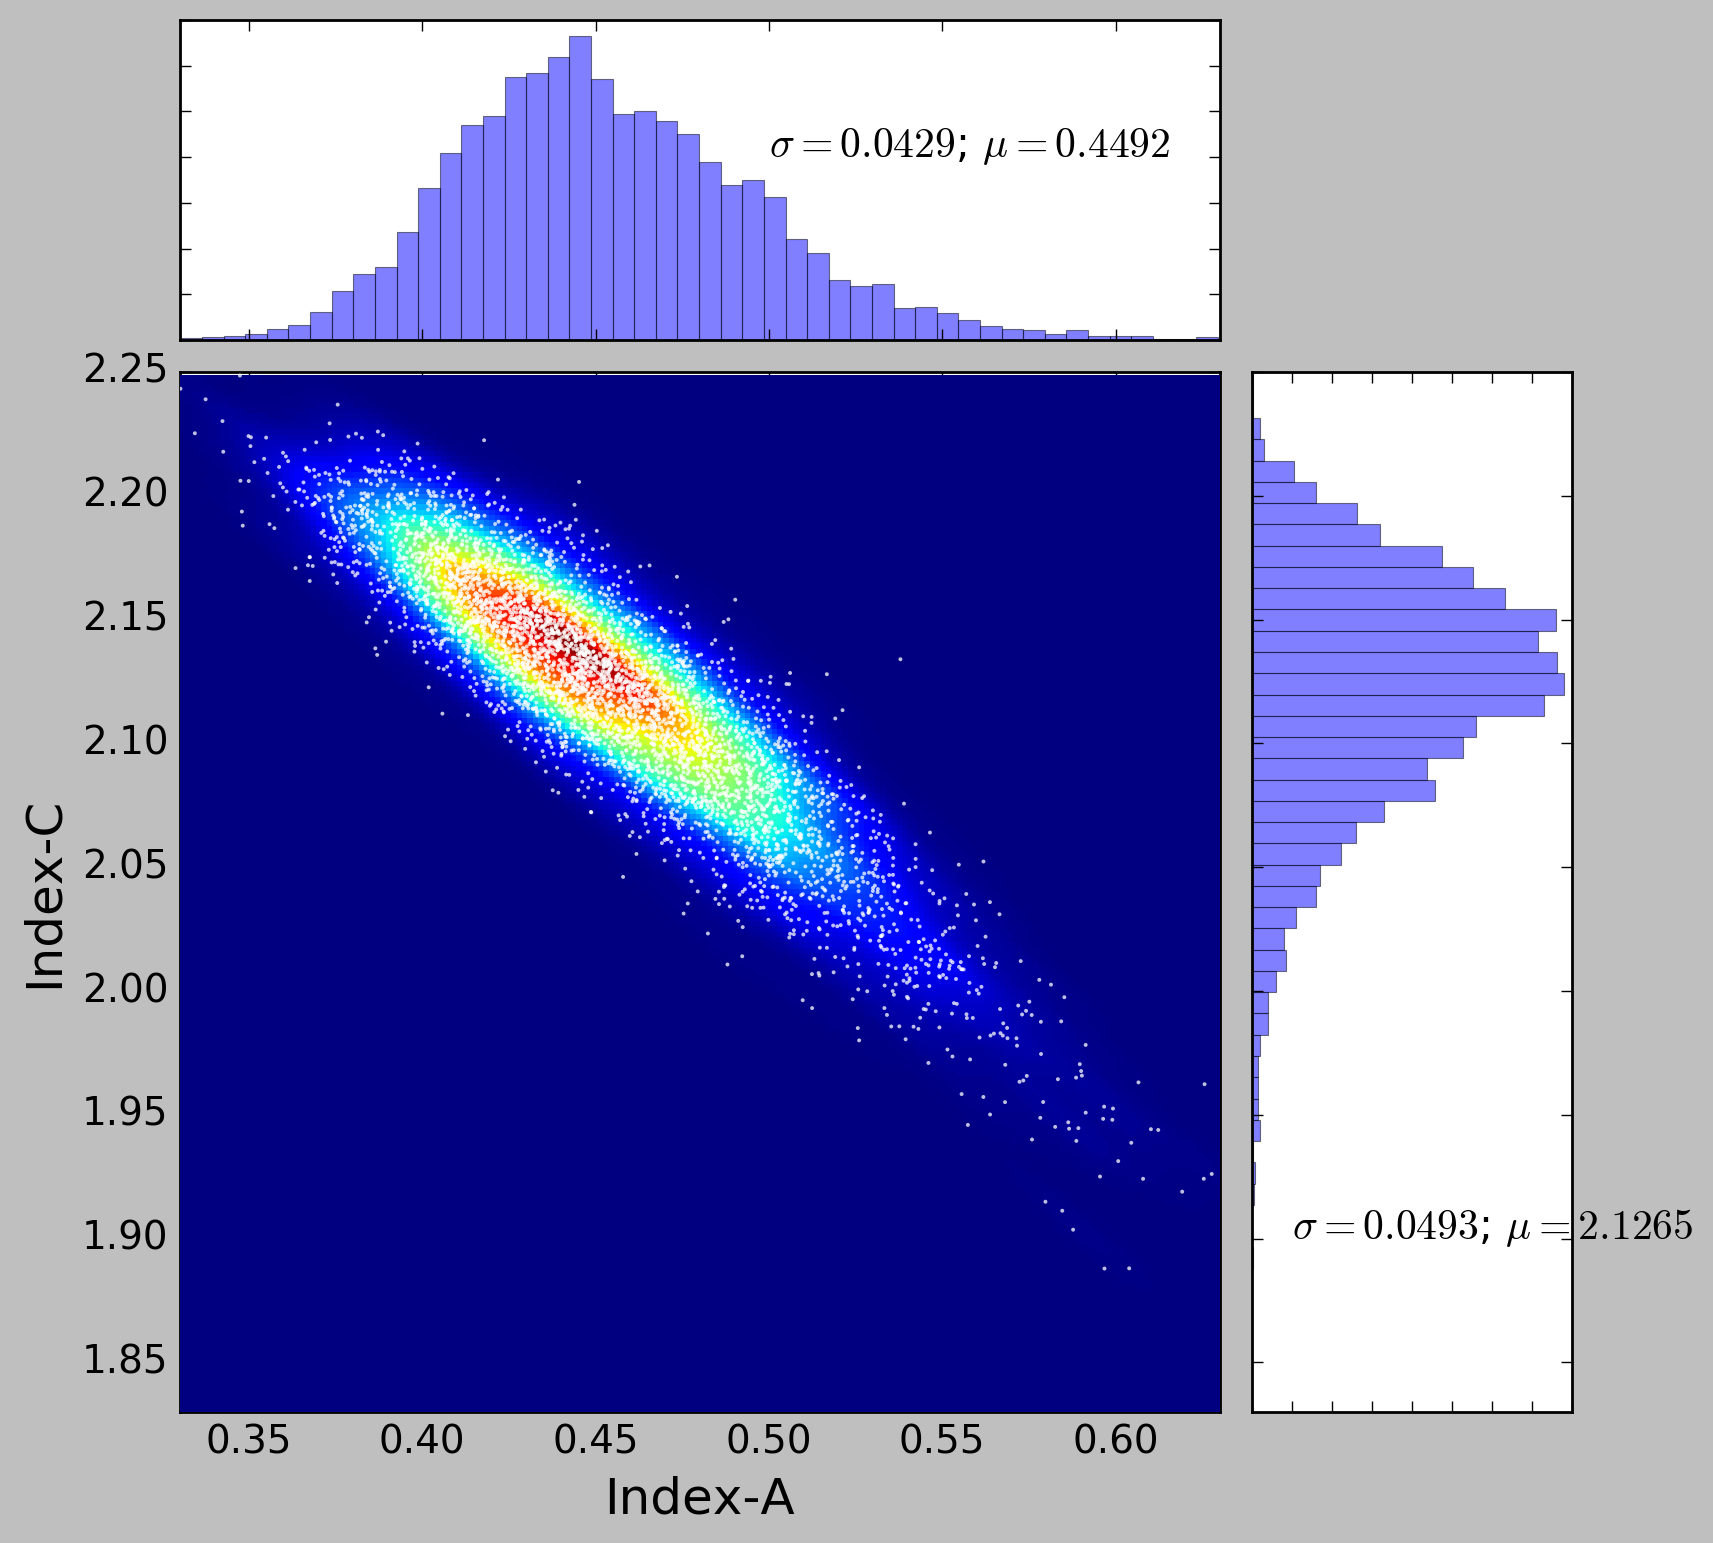

In [339]:
#fig, (ax) = plt.subplots()
#ax.scatter(aFitPars[:,0], aFitPars[:,1],color='red',alpha=0.3, s=9, edgecolor='none')

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
fig = plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)


# the scatter plot:
axScatter.pcolormesh(xi, zi, cii.reshape(xi.shape), zorder=3)
axScatter.scatter(airFitPars[:,0], airFitPars[:,2], c='w', s=2, zorder=15, edgecolor='none',alpha=0.75)
axScatter.contour(xi,yi,cii.reshape(xi.shape), zorder=25, colors='0.25')

# now determine nice limits by hand:
binwidth = 0.25
xymax = max([max(fabs(aFitPars[:,0])), max(fabs(aFitPars[:,1]))])

axScatter.set_xlabel('Index-A')
axScatter.set_ylabel('Index-C')
axScatter.set_xlim((0.33,0.63))
axScatter.set_ylim((1.83, 2.25))

#bins = arange(-lim, lim + binwidth, binwidth)
axHistx.hist(airFitPars[:,0], edgecolor='k',linewidth=0.4,bins=50,alpha=0.5)
axHisty.hist(airFitPars[:,2], edgecolor='k',linewidth=0.4,bins=50,alpha=0.5, orientation='horizontal')
axHistx.text(0.5, 200, '$\sigma = ' + str(round(std(airFitPars[:,0]),4)) + '$'+'; '+'$\mu = ' + str(round(median(airFitPars[:,0]),4)) + '$', fontsize=15)
axHisty.text(50, 1.9, '$\sigma = ' + str(round(std(airFitPars[:,2]),4)) + '$'+'; '+'$\mu = ' + str(round(median(airFitPars[:,2]),4)) + '$', fontsize=15)

axHistx.set_yticklabels([])
axHistx.set_xticklabels([])
axHisty.set_yticklabels([])
axHisty.set_xticklabels([])

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
fig.savefig("Parameter_Ai_ac.png", dpi=150,bbox_inches='tight')
plt.savefig('Parameter_Ai_ac.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

In [270]:
savetxt('Parameters_ABC_air.txt', airFitPars)

In [324]:
for i in range(0,10):
    print(mean(data_air_2w[i]))

120.52584
117.5942
111.30704
111.2158
108.81564
103.16548
107.36748
101.92744
101.3099
101.06788


In [327]:
def measTrial_3(ratio, A, B, C):
    return 1/(exp((ratio-C)/A)-B)

def measErrMonteCarlo_3(V,error,measNum, A, B, C,V0):
    measMontCarlo = array([])
    for i in range(0,measNum):
        V_measured = V + random.normal(scale=V*error,size=1)
        oneMontCarlo = measTrial_3(V_measured/(V0-V_measured),A, B, C)
        if size(measMontCarlo) < 1:
            measMontCarlo=copy(oneMontCarlo)
        else:
            measMontCarlo = vstack(( measMontCarlo, oneMontCarlo ))
    return measMontCarlo

In [335]:
n_point = 40
med_k3 = empty([n_point]);std_k3 = empty([n_point])
count = 0
#rati = append(1, linspace(1.7,2.8,n_point))
for i in linspace(101.5,120.6,n_point):
    meas_multik_3 = measErrMonteCarlo_3(i,0.008,250, airFitPars[:,0], airFitPars[:,1],airFitPars[:,2],V_nc_air).flatten()
    med_k3[count] = median(meas_multik_3)
    std_k3[count] = std(meas_multik_3)
    count = count+1
#print(med_k, std_k)

In [ ]:
measTrial_3(2.3, A, B, C)

1.25595909473 0.238007210478


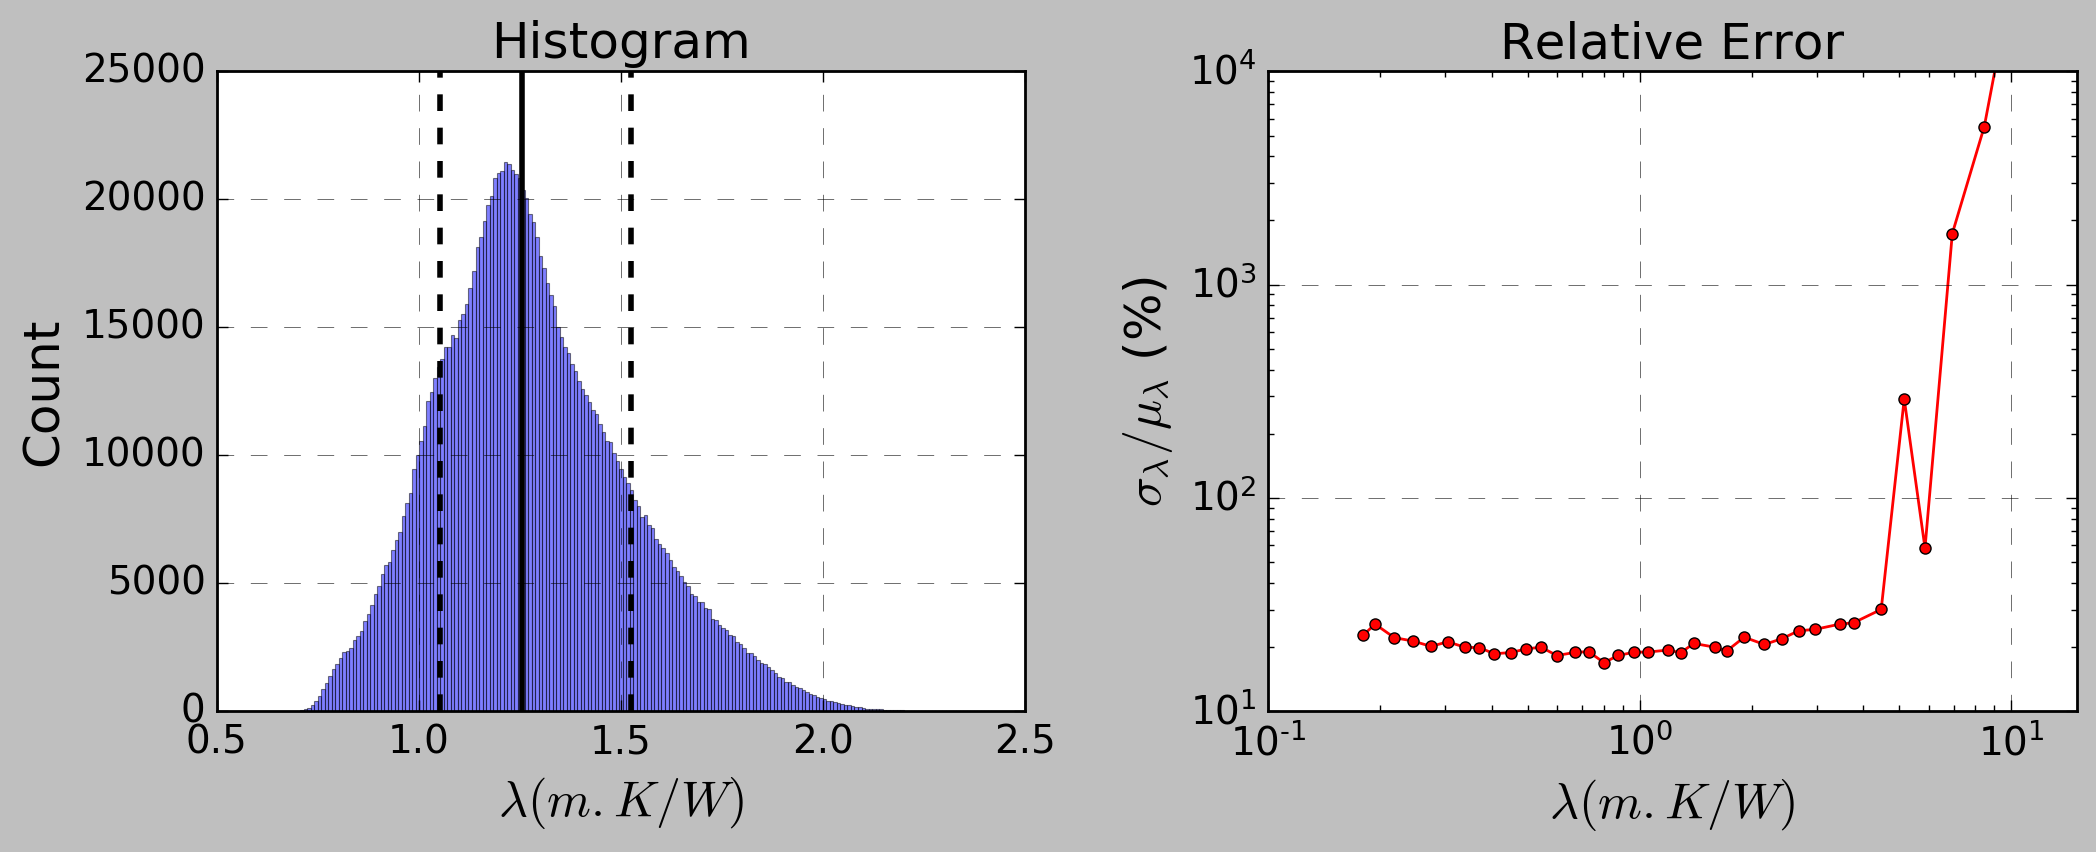

In [338]:
fig, ((ax1,ax2)) = plt.subplots(1,2)
meas_sample_k = measErrMonteCarlo_3(111,0.008,250, airFitPars[:,0], airFitPars[:,1],airFitPars[:,2],V_nc_air).flatten()
ax1.hist(meas_sample_k,edgecolor='k',linewidth=0.4,bins=200,alpha=0.5)
#ax.hist(meas_k,bins=50)
Med = median(meas_sample_k)
gHi = where(meas_sample_k >= median(meas_sample_k))[0]
gLo = where(meas_sample_k < median(meas_sample_k))[0]

# This trick does the limit-setting - try to see how it works:
vSortLo=sort(meas_sample_k[gLo])
vSortHi=sort(meas_sample_k[gHi])

sLim = 0.68
NormLo = vSortLo[int((1.0-sLim)*size(vSortLo))]
NormHi = vSortHi[int(sLim      *size(vSortHi))]

## Let's take a look - how do those limits look on the histogram?
ax1.plot([Med, Med],[1,25000.0], 'k-', lw=2)
ax1.plot([NormLo, NormLo],[1,25000.0], 'k--', lw=2)
ax1.plot([NormHi, NormHi],[1,25000.0], 'k--', lw=2)
ax1.set_xlabel('$\lambda(m.K/W)$')
ax1.set_ylabel('Count')
#ax1.set_ylim([0, 25000])

ax2.plot(med_k3, std_k3/med_k3*100, 'r-o',markersize=4)
ax2.set_xlabel('$\lambda(m.K/W)$')
ax2.set_ylabel('$\sigma _{\lambda}/\mu _{\lambda}$'+' (%)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([0.1, 15])
ax2.set_ylim([10, 10000])

ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax1.grid(color='k', linestyle='--', linewidth=0.2)
ax2.set_title('Relative Error', fontsize=18)
ax1.set_title('Histogram', fontsize=18)

fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Error analysis_Air.png", dpi=400,bbox_inches="tight")
plt.savefig('Error analysis_Air.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

print(median(meas_sample_k),std(meas_sample_k))

# Conductance calibration curve

In [408]:
#straight line function of 1/k
def line(x, a, b):
    return a * x + b

#x_fit = 1/array(k_3)
#y_fit_vide=zeros(10)
y_fit_vide_2 = data_vide_2w[0]*K_convide/(V_nc_vide-data_vide_2w[0])
x_fit_vide_2=(1/k[0])*ones(size(data_vide_2w[0]))
for i in range(1,11):
    #y_fit_vide[i]= mean(data_vide_2w_3[i]/(V_nc_vide-data_vide_2w_3[i]))
    y_fit_vide_2 = append(y_fit_vide_2,data_vide_2w[i]*K_convide/(V_nc_vide-data_vide_2w[i]))
    x_fit_vide_2 = append(x_fit_vide_2,(1/k[i])*ones(size(data_vide_2w[i])))
popt_v, pcov_v = curve_fit(line, x_fit_vide_2, y_fit_vide_2)
perr = sqrt(diag(pcov_v))


#R_squared = sum((line(x_fit_vide_2, popt_v[0], popt_v[1])-y_fit_vide_2)**2)/size(x_fit_vide_2)
mean_squared = sum((line(x_fit_vide_2, popt_v[0], popt_v[1])-y_fit_vide_2)**2)/size(x_fit_vide_2)

ss_res = dot((y_fit_vide_2 - line(x_fit_vide_2, popt_v[0], popt_v[1])),(y_fit_vide_2 - line(x_fit_vide_2, popt_v[0], popt_v[1])))
ymean = mean(y_fit_vide_2)
ss_tot = dot((y_fit_vide_2-ymean),(y_fit_vide_2-ymean))
R_squared = 1-ss_res/ss_tot

slope, intercept, r_value, p_value, std_err = stats.linregress(x_fit_vide_2,y_fit_vide_2)
print(popt_v, 1/popt_v)
print(pcov_v)
print(perr)
print(R_squared)
print(r_value)
print(slope)
print(intercept)


[ 2180487.1606973   1227111.03540413] [  4.58613111e-07   8.14922180e-07]
[[  3.77578595e+08  -3.57167513e+08]
 [ -3.57167513e+08   1.28032153e+09]]
[ 19431.38171603  35781.58082386]
0.979541264599
0.989717770175
2180487.16499
1227111.03046


8.26023991934e-08
1.67594779501e-07
5.09030031694e-07
6.00297235232e-07
8.61340531226e-07
4.88646729374e-06
3.25458148054e-06
-7.65171788037e-05
5.04857414904e-06
5.49344175199e-06
8.11197094869e-06
eq conductance
7.50002047676e-08
1.39006967509e-07
3.13319362616e-07
3.45667623199e-07
4.187443285e-07
6.9844212496e-07
6.51733197999e-07
8.23694681434e-07
7.01662424651e-07
7.09649534525e-07
7.40529202474e-07


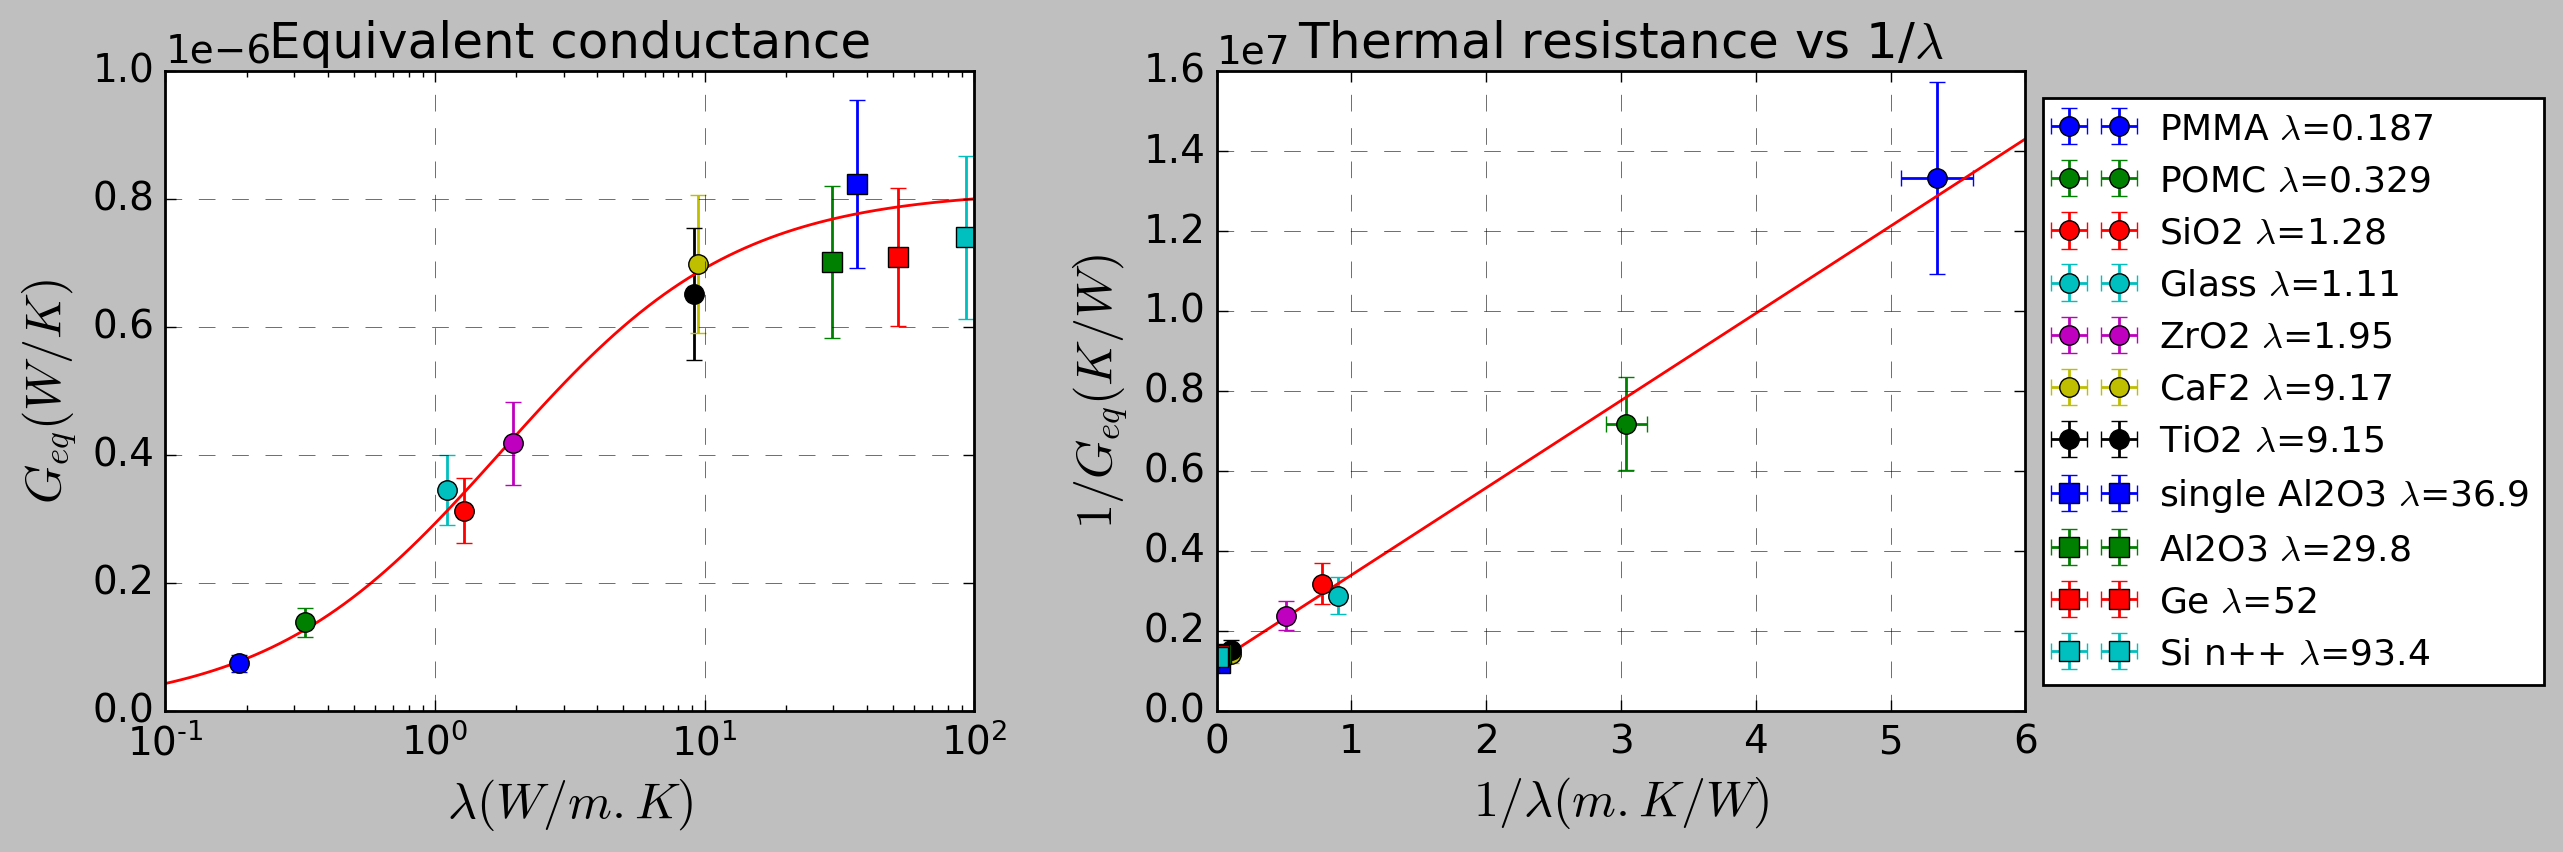

In [491]:
#2-omega plot
fig, ((ax1, ax2)) = plt.subplots(1, 2)
#fig, (ax1) = plt.subplots()
x_inv = logspace(-1, 2.,100)
xfine = linspace(0, 6,100)
for i in range(0,11):
    ax1.errorbar((k[i]), 1/mean(data_vide_2w[i]*K_convide/(V_nc_vide-data_vide_2w[i])),xerr=k[i]*0.05,yerr=sqrt(0.15**2 + (std((V_nc_vide-data_vide_2w[i])/(data_vide_2w[i]*K_convide))/(1/mean(data_vide_2w[i]*K_convide/(V_nc_vide-data_vide_2w[i]))))**2)*(1/mean(data_vide_2w[i]*K_convide/(V_nc_vide-data_vide_2w[i]))),fmt=data_shape[i],markersize=7,label=label_cal[i])
    #ax1.errorbar((k[i])),mean((V_noncontact-data_vide_2w[i])/V_noncontact),std((V_noncontact-data_vide_2w[i])/V_noncontact),'o',markersize=3,label=label_cal[i])
    #ax1.errorbar((k[i]), mean((V_nc_vide-data_vide_2w[i])/V_nc_vide),yerr=std((V_nc_vide-data_vide_2w[i])/V_nc_vide),fmt='o',markersize=7,label=label_cal[i])

ax1.plot(x_inv, 1/(line(1/x_inv, popt_v[0], popt_v[1])), 'r-')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#ax1.plot(x_inv, fit_courbe(x_inv, popt_v[0], popt_v[1]), 'r-')
ax1.set_xscale('log')
ax1.grid(color='k', linestyle='--', linewidth=0.2)
#ax1.legend(loc='center left',prop={'size':11},bbox_to_anchor=(1, 0.5)) 
ax1.set_xlabel('$\lambda(W/m.K)$')
ax1.set_ylabel('$G_{eq} (W/K)$')

for i in range(0,11):
    ax2.errorbar((1/k[i]), mean(data_vide_2w[i]*K_convide/(V_nc_vide-data_vide_2w[i])),xerr=(1/k[i])*0.05,yerr=sqrt(0.15**2+(std(data_vide_2w[i]*K_convide/(V_nc_vide-data_vide_2w[i]))/mean(data_vide_2w[i]*K_convide/(V_nc_vide-data_vide_2w[i])))**2)*mean(data_vide_2w[i]*K_convide/(V_nc_vide-data_vide_2w[i])),fmt=data_shape[i],markersize=7,label=label_cal[i])
    #ax2.errorbar((1/k[i]), mean(data_400_2w[i]*K_con400/(V_nc_400-data_400_2w[i])),xerr=(1/k[i])*0.05,yerr=std(data_400_2w[i]*K_con400/(V_nc_400-data_400_2w[i])),fmt='ro',markersize=7,label=label_cal[i])
    #ax2.errorbar((1/k[i]), mean(data_vide_2w[i]/(V_nc_vide-data_vide_2w[i])),yerr=std(data_vide_2w[i]/(V_nc_videdata_vide_2w[i])),fmt='o',markersize=7,label=label_cal[i])
ax2.plot(xfine, line(xfine, popt_v[0], popt_v[1]), 'r-')
#ax1.legend(loc='center left',prop={'size':11},bbox_to_anchor=(1, 0.5)) 
#ax2.text(2,0.2e6, '$1/G_{eq} =$''$''$')
ax2.set_xlabel('$1/\lambda (m.K/W)$')
ax2.set_ylabel('$1/G_{eq} (K/W)$')

ax2.grid(color='k', linestyle='--', linewidth=0.2)
#ax1.text(0.5,3.5, 'Air')
#ax.set_xscale('log')
ax1.set_title('Equivalent conductance', fontsize=18)
ax2.set_title('Thermal resistance vs 1/'+'$\lambda$', fontsize=18)
#fig.savefig("Vide_TH_6_T1.png", dpi=400,bbox_inches="tight")
ax2.legend(loc='center left',prop={'size':13},bbox_to_anchor=(1, 0.5)) 

#ax.set_title('Calibration curve 1µm of diameter probe', fontsize=14)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("G_Vacuum_newSubtrate.png", dpi=400,bbox_inches="tight")
plt.savefig('G_Vacuum_newSubtrate.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

for i in range(0,11):
    print(1/(mean(data_vide_2w[i]*K_convide/(V_nc_vide-data_vide_2w[i]))-popt_v[1]))
print('eq conductance')
for i in range(0,11):
    print(1/(mean(data_vide_2w[i]*K_convide/(V_nc_vide-data_vide_2w[i]))))
    

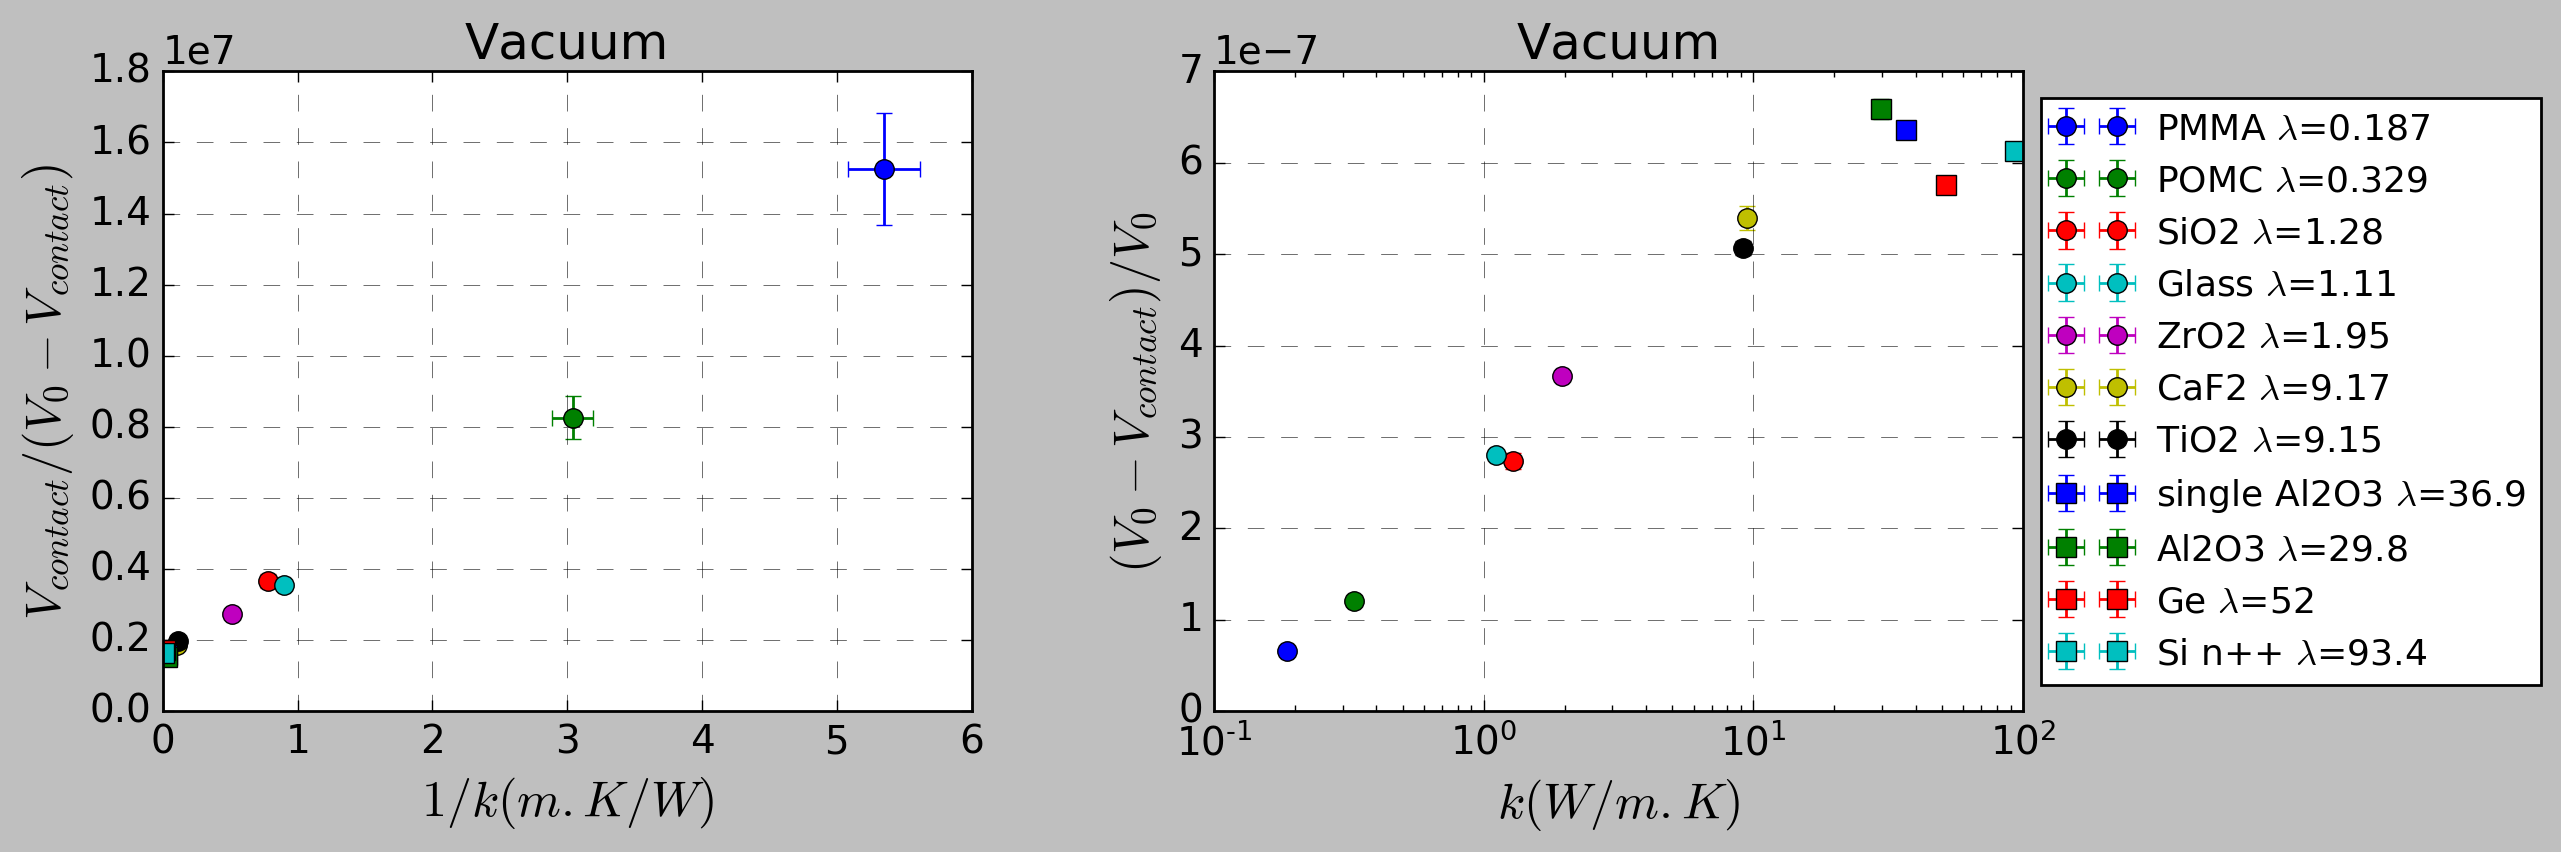

In [181]:
#2-omega plot
fig, (ax2,ax1) = plt.subplots(1,2)
#fig, (ax1) = plt.subplots()
x_inv = logspace(-1, 2.,100)
xfine = linspace(0, 6,100)
for i in range(0,11):
    #ax1.errorbar((k[i])),mean((V_noncontact-data_vide_2w[i])/V_noncontact),std((V_noncontact-data_vide_2w[i])/V_noncontact),'o',markersize=3,label=label_cal[i])
    ax1.errorbar((k[i]), 1/mean(data_400_2w[i]*K_con400/(V_nc_400-data_400_2w[i])),xerr=k[i]*0.05,yerr=std((V_nc_400-data_400_2w[i])/V_nc_400/K_con400), fmt=data_shape[i],markersize=7,label=label_cal[i])

#ax1.plot(x_inv, 1/(line(1/x_inv, popt_v[0], popt_v[1])+1), 'r-')
ax1.grid(color='k', linestyle='--', linewidth=0.2)

#ax1.plot(x_inv, fit_courbe(x_inv, popt_v[0], popt_v[1]), 'r-')
ax1.set_xscale('log')
#ax1.legend(loc='center left',prop={'size':11},bbox_to_anchor=(1, 0.5)) 
ax1.set_xlabel('$k(W/m.K)$')
ax1.set_ylabel('$(V_{0}-V_{contact})/V_{0}$')

for i in range(0,11):
    ax2.errorbar((1/k[i]), mean(data_400_2w[i]*K_con400/(V_nc_400-data_400_2w[i])),xerr=(1/k[i])*0.05,yerr=std(data_400_2w[i]*K_con400/(V_nc_400-data_400_2w[i])),fmt=data_shape[i],markersize=7,label=label_cal[i])
#ax2.plot(xfine, line(xfine, popt_v[0], popt_v[1]), 'r-')
#ax1.legend(loc='center left',prop={'size':11},bbox_to_anchor=(1, 0.5)) 
ax2.set_xlabel('$1/k(m.K/W)$')
ax2.set_ylabel('$V_{contact}/(V_{0}-V_{contact})$')
ax2.grid(color='k', linestyle='--', linewidth=0.2)

#ax1.text(0.5,3.5, 'Air')
#ax.set_xscale('log')
ax1.set_title('Vacuum', fontsize=18)
ax2.set_title('Vacuum', fontsize=18)
#fig.savefig("Vide_TH_6_T1.png", dpi=400,bbox_inches="tight")
ax1.legend(loc='center left',prop={'size':13},bbox_to_anchor=(1, 0.5)) 

#ax.set_title('Calibration curve 1µm of diameter probe', fontsize=14)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("Vacuum_newSubtrate_sub.png", dpi=400,bbox_inches="tight")
def fit_log(x,A,B,C):
    return A*log(x+B)+C

def dfit_log(x,A,B):
    return A/(x+B)plt.savefig('Vacuum_newSubtrate_sub.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

#contact conductance
1.15768018052e-06
1.28203242955e-06
1.52965093069e-06
1.54514883127e-06
1.62239187906e-06
1.74980778676e-06
1.55238792984e-06
1.73217942085e-06
1.76648541312e-06
1.76275105545e-06
1.80090047438e-06
#sample conductance
6.82426520113e-06
7.13080784994e-06
9.18378009654e-06
8.81679241839e-06
1.06301432987e-05
2.68855386897e-05
2.61731508439e-05
8.60784924245e-05
7.07513599841e-05
0.000118675633249
0.000208047926634
#sample conductance
9.89773318684e-07
1.08666355342e-06
1.31124919144e-06
1.31473979369e-06
1.40756650855e-06
1.6428830358e-06
1.46546776917e-06
1.69800993458e-06
1.72345502939e-06
1.73695121347e-06
1.78544533669e-06


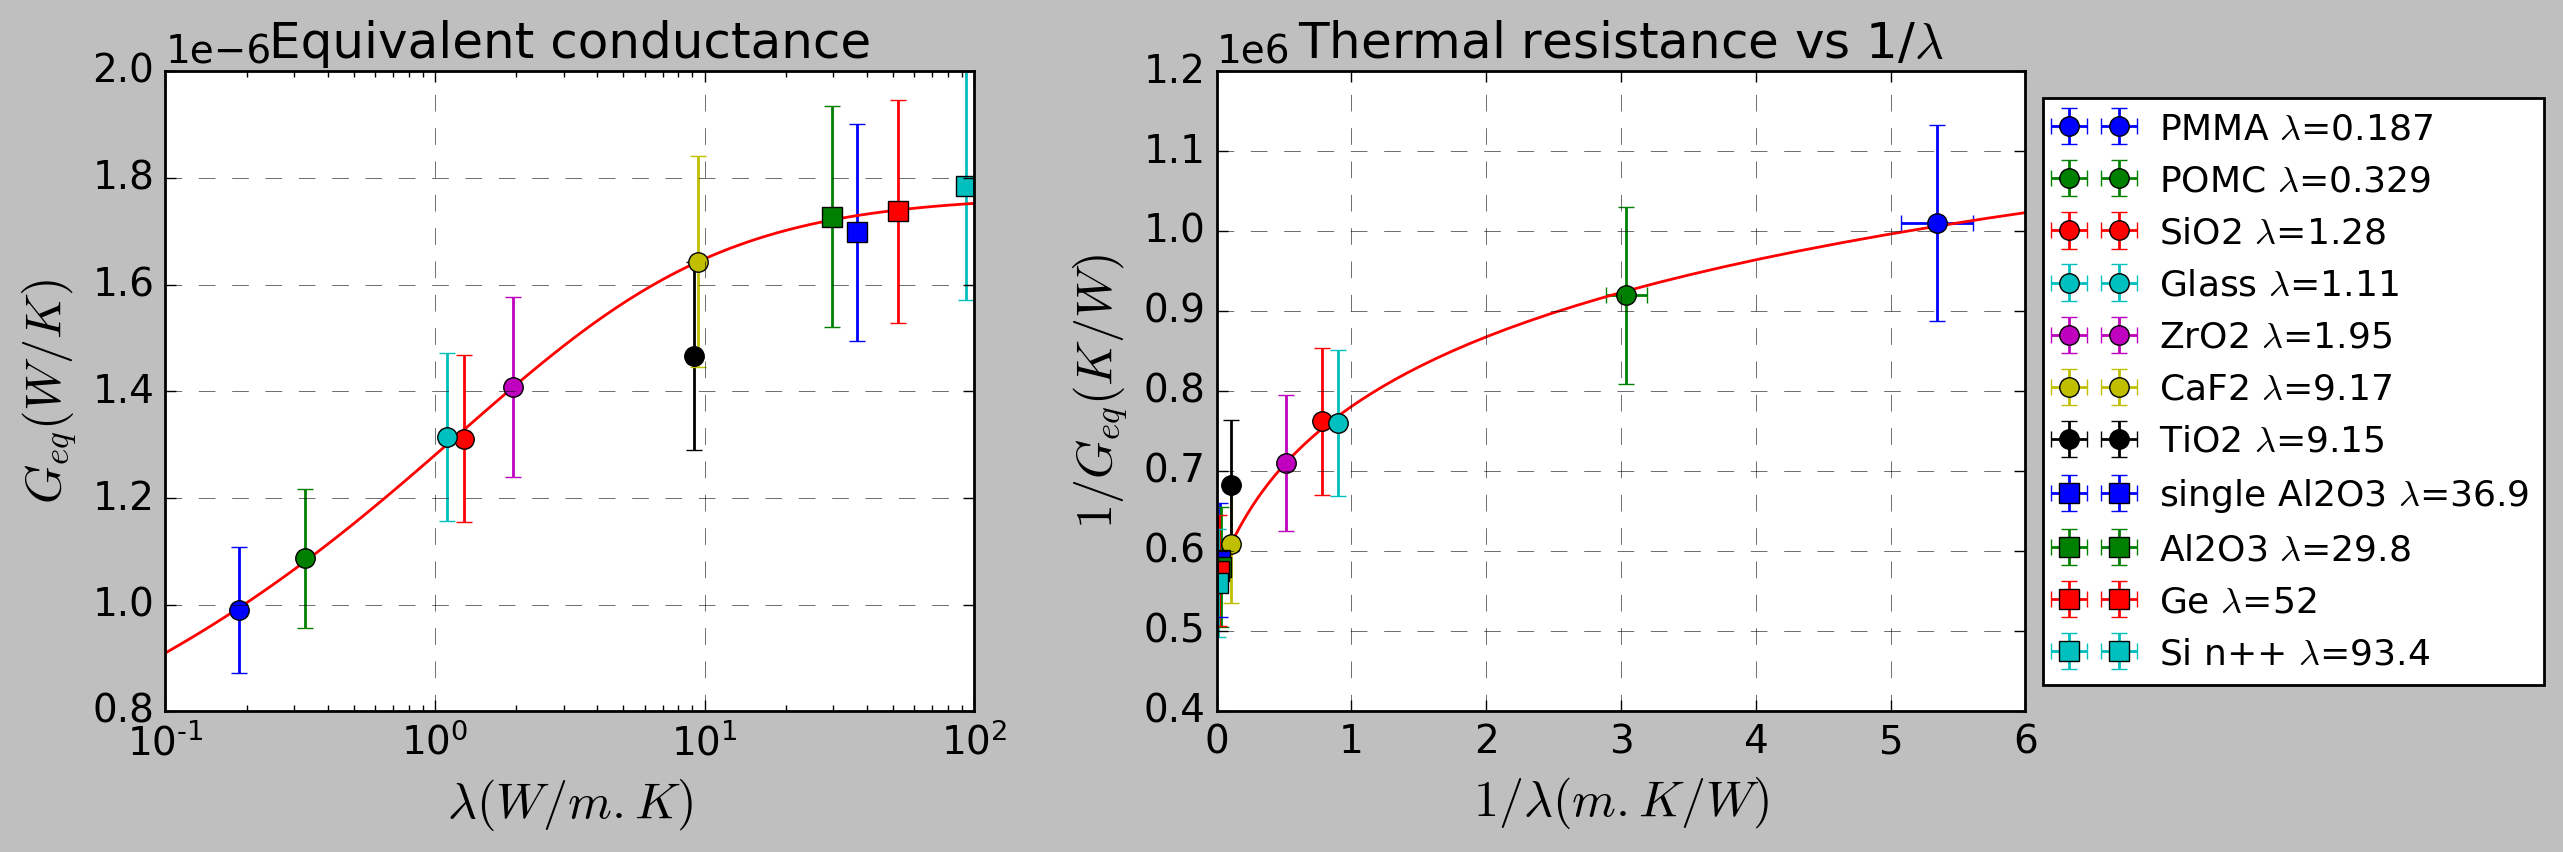

In [488]:
def fit_log(x,A,B,C):
    return A*log(x+B)+C

def dfit_log(x,A,B):
    return A/(x+B)


#2-omega plot
fig, ((ax1, ax2)) = plt.subplots(1, 2)
x_inv = logspace(-1, 2,100)
xfine = logspace(-2, 1,100)
for i in range(0,11):
    ax1.errorbar(k[i], mean((V_nc_air-data_air_2w[i])/data_air_2w[i])/K_convair,xerr=k[i]*0.05,yerr=sqrt(0.12**2+(std((V_nc_air-data_air_2w[i])/(data_air_2w[i]*K_convair))/mean((V_nc_air-data_air_2w[i])/data_air_2w[i])/K_convair)**2)*mean((V_nc_air-data_air_2w[i])/data_air_2w[i])/K_convair,fmt=data_shape[i],markersize=7,label=label_cal[i])

ax1.plot(x_inv, 1/(K_convair*(peval(1/x_inv,plsq))), 'r-')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax1.set_xscale('log')
ax1.set_xlabel('$\lambda(W/m.K)$')
ax1.set_ylabel('$G_{eq} (W/K)$')

for i in range(0,11):
    ax2.errorbar((1/k[i]), K_convair*mean(data_air_2w[i]/(V_nc_air-data_air_2w[i])),xerr=(1/k[i])*0.05,yerr=sqrt(0.12**2+(std(K_convair*data_air_2w[i]/(V_nc_air-data_air_2w[i]))/(K_convair*mean(data_air_2w[i]/(V_nc_air-data_air_2w[i]))))**2)*K_convair*mean(data_air_2w[i]/(V_nc_air-data_air_2w[i])),fmt=data_shape[i],markersize=7,label=label_cal[i])
ax2.plot(xfine, K_convair*peval(xfine,plsq), 'r-')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax2.set_xlabel('$1/\lambda(m.K/W)$')
ax2.set_ylabel('$1/G_{eq} (K/W)$')
ax2.set_xlim([0, 6])
ax1.grid(color='k', linestyle='--', linewidth=0.2)
ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax1.set_title('Equivalent conductance', fontsize=18)
ax2.set_title('Thermal resistance vs 1/'+'$\lambda$', fontsize=18)
ax2.legend(loc='center left',prop={'size':13},bbox_to_anchor=(1, 0.5)) 
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.savefig("G_Air_newSubtrate.png", dpi=400,bbox_inches="tight")
plt.savefig('G_Air_newSubtrate.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

print('#contact conductance')
for i in range(0,11):
    print(1/(mean(data_air_2w[i]*K_convair/(V_nc_air-data_air_2w[i]))-dfit_log(1/k[i],K_convair*plsq[0],plsq[1])*1/k[i]))
print('#sample conductance')
for i in range(0,11):
    print(1/(dfit_log(1/k[i],K_convair*plsq[0],plsq[1])*1/k[i]))
print('#sample conductance')
for i in range(0,11):
    print(1/(mean(data_air_2w[i]*K_convair/(V_nc_air-data_air_2w[i]))))
    

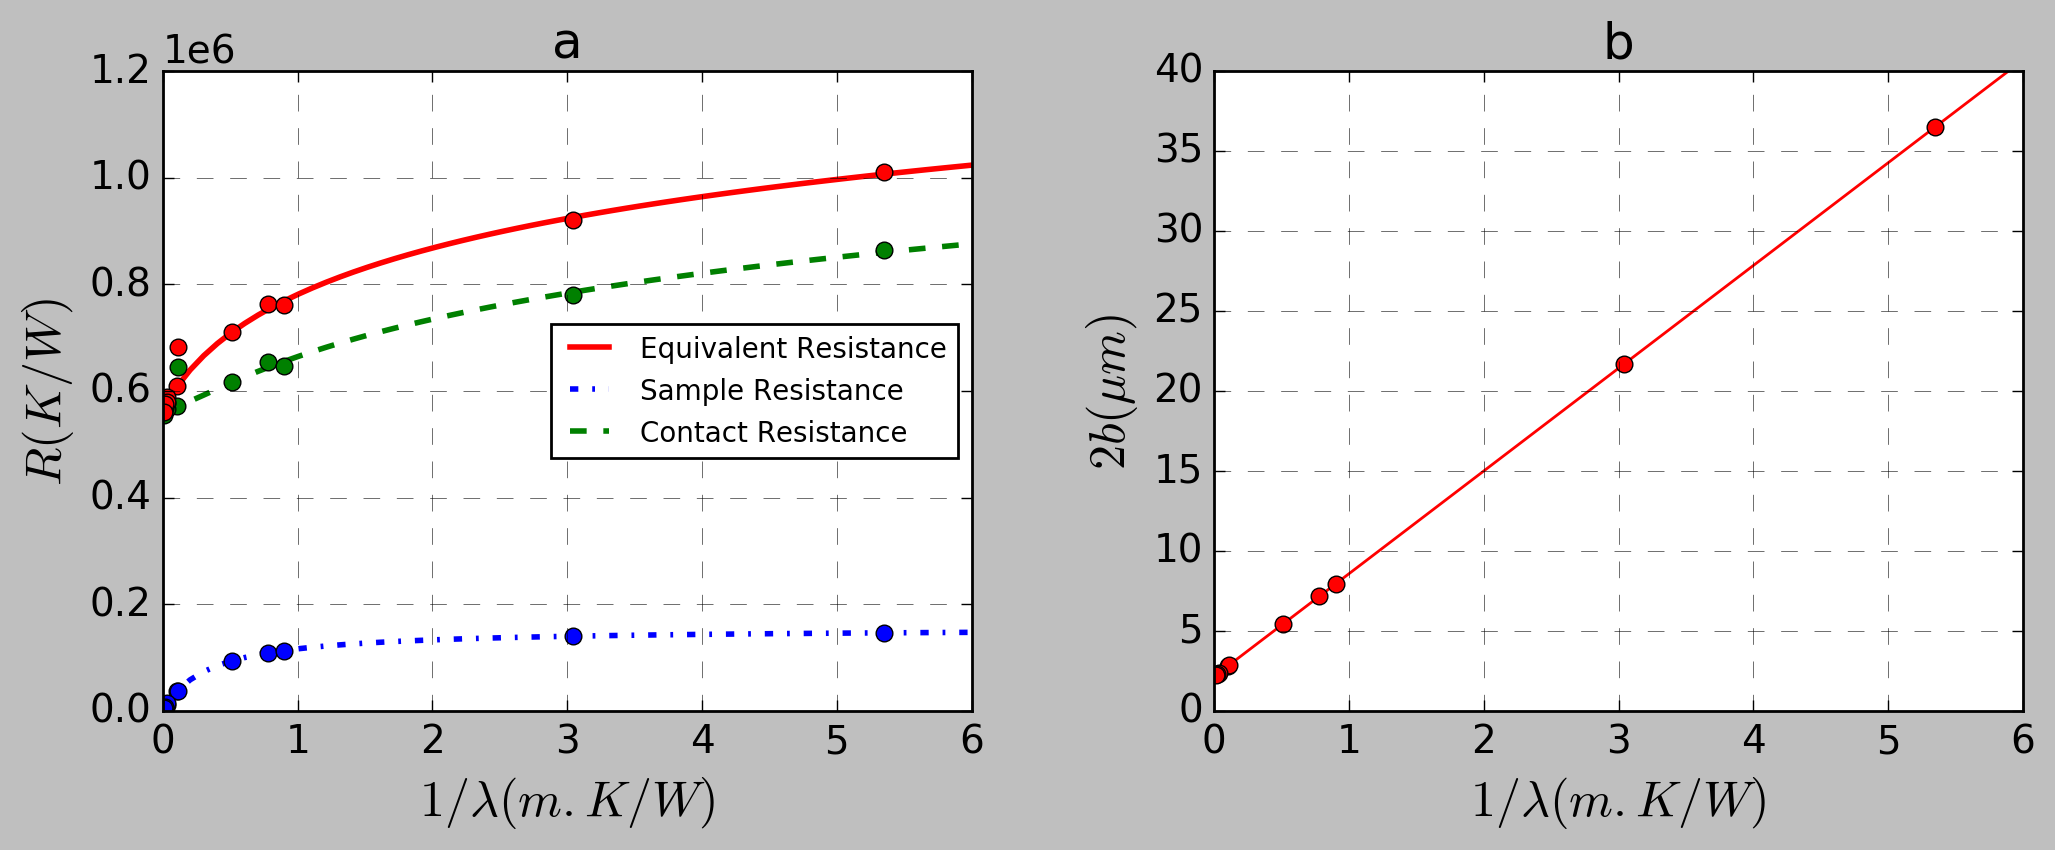

In [490]:
def fit_log(x,A,B,C):
    return A*log(x+B)+C

def dfit_log(x,A,B):
    return A/(x+B)


xfine = linspace(0, 10,100)

fig, ((ax1, ax2)) = plt.subplots(1, 2)

#for i in range(0,11):
    #ax1.errorbar((1/k[i]), K_convair*mean(data_air_2w[i]/(V_nc_air-data_air_2w[i])),yerr=std(K_convair*data_air_2w[i]/(V_nc_air-data_air_2w[i])),fmt=data_shape[i],markersize=7,label=label_cal[i])
ax1.plot(xfine, K_convair*peval(xfine,plsq), 'r-',label='Equivalent Resistance',linewidth=2)
ax1.plot(xfine, dfit_log(xfine,K_convair*plsq[0],plsq[1])*xfine, 'b-.',label='Sample Resistance',linewidth=2)
ax1.plot(xfine, K_convair*peval(xfine,plsq)-dfit_log(xfine,K_convair*plsq[0],plsq[1])*xfine, 'g--',label='Contact Resistance',linewidth=2)
#print('#contact conductance')
for i in range(0,11):
    ax1.plot((1/k[i]),(mean(data_air_2w[i]*K_convair/(V_nc_air-data_air_2w[i]))-dfit_log(1/k[i],K_convair*plsq[0],plsq[1])*1/k[i]),'go')
#print('#sample conductance')
for i in range(0,11):
    ax1.plot((1/k[i]),(dfit_log(1/k[i],K_convair*plsq[0],plsq[1])*1/k[i]),'bo')
#print('#sample conductance')
for i in range(0,11):
    ax1.plot((1/k[i]),(mean(data_air_2w[i]*K_convair/(V_nc_air-data_air_2w[i]))),'ro')

ax1.legend(loc='best',prop={'size':10}) 

ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax1.set_xlabel('$1/\lambda(m.K/W)$')
ax1.set_ylabel('$R (K/W)$')
ax1.set_xlim([0, 6])
ax1.grid(color='k', linestyle='--', linewidth=0.2)

#ax1.set_yscale('log')

ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax2.plot(xfine[1:],1/dfit_log(xfine[1:],K_convair*plsq[0],plsq[1])*1e6, 'r')
for i in range(0,11):
    ax2.plot((1/k[i]), 1/dfit_log(1/k[i],K_convair*plsq[0],plsq[1])*1e6,'ro')
ax2.set_xlim([0, 6])
ax2.set_ylim([0, 40])
ax2.set_xlabel('$1/\lambda(m.K/W)$')
ax2.set_ylabel('$2b(\mu m)$')
ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax1.set_title('a', fontsize=18)
ax2.set_title('b', fontsize=18)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.savefig("R_b_Air_newSubtrate.png", dpi=400,bbox_inches="tight")
plt.savefig('R_b_Air_newSubtrate.pdf',format = 'pdf', transparent=True,bbox_inches='tight')


   

2180487.1606973042

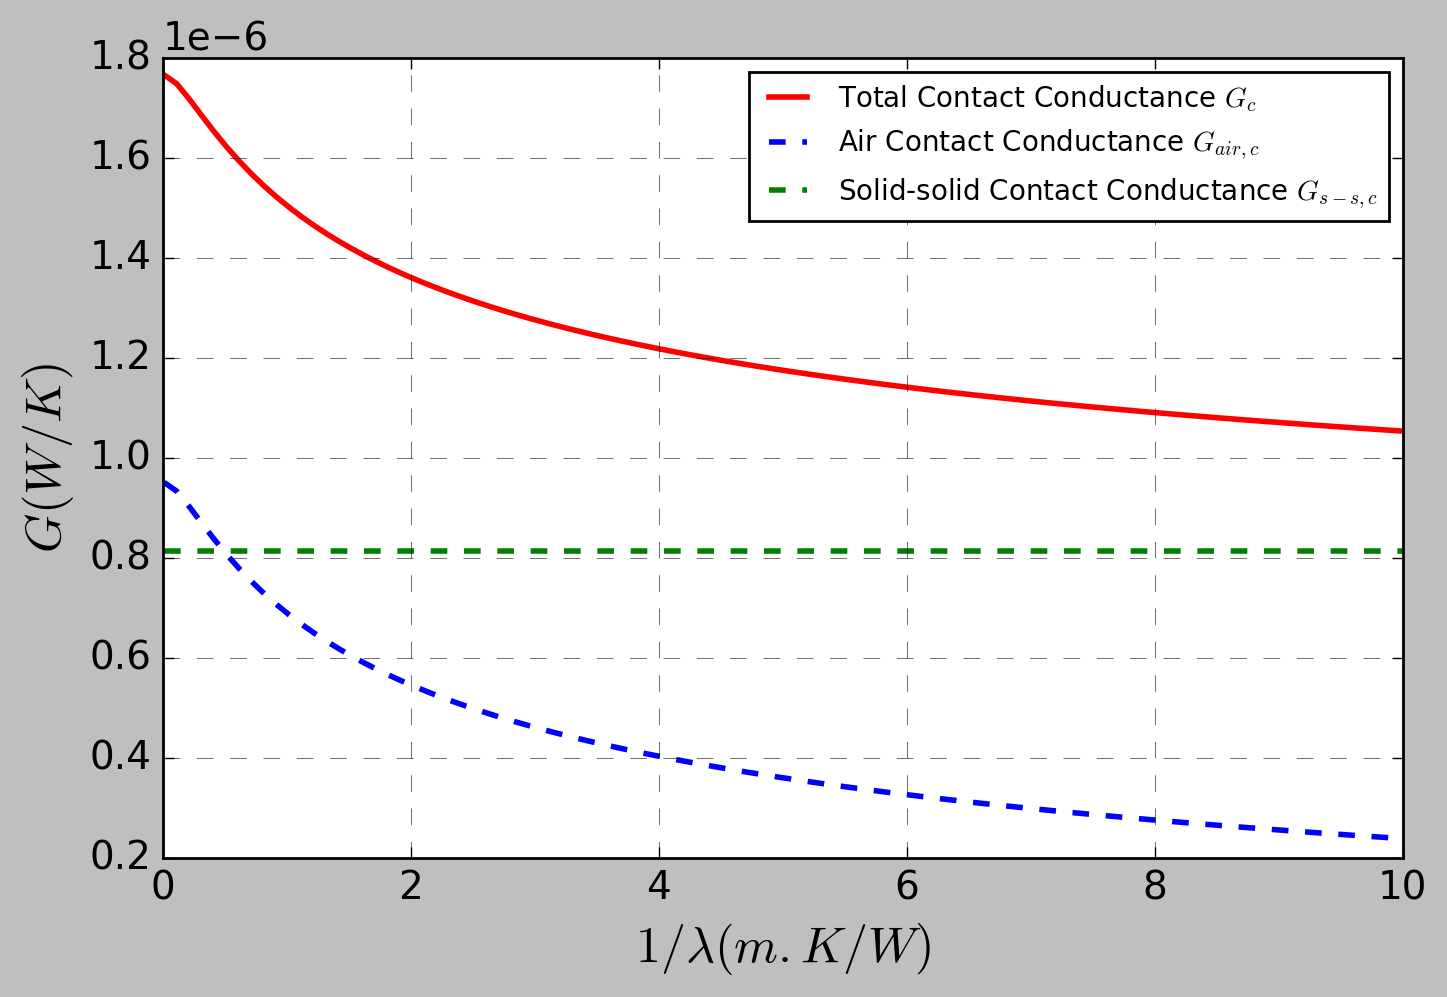

In [436]:
def fit_log(x,A,B,C):
    return A*log(x+B)+C

def dfit_log(x,A,B):
    return A/(x+B)


xfine = linspace(0.01, 10,100)

fig, (( ax2)) = plt.subplots()

#for i in range(0,11):
    #ax1.errorbar((1/k[i]), K_convair*mean(data_air_2w[i]/(V_nc_air-data_air_2w[i])),yerr=std(K_convair*data_air_2w[i]/(V_nc_air-data_air_2w[i])),fmt=data_shape[i],markersize=7,label=label_cal[i])
#ax1.plot(xfine, K_convair*peval(xfine,plsq), 'r-',label='Equivalent Resistance',linewidth=2)
ax1.plot(xfine, (dfit_log(xfine,K_convair*plsq[0],plsq[1])*xfine), 'b-.',label='Sample Resistance',linewidth=2)
ax1.plot(xfine, (xfine*popt_v[0]), 'b-.',label='Sample Resistance',linewidth=2)
ax1.plot(xfine, (1/(dfit_log(xfine,K_convair*plsq[0],plsq[1])*xfine)-1/(xfine*popt_v[0]))**(-1), 'b-.',label='Sample Resistance',linewidth=2)

#ax1.plot(xfine, K_convair*peval(xfine,plsq)-dfit_log(xfine,K_convair*plsq[0],plsq[1])*xfine, 'g--',label='Contact Resistance',linewidth=2)
ax1.legend(loc='best',prop={'size':10}) 
#ax1.set_yscale('log')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax1.set_xlabel('$1/\lambda(m.K/W)$')
ax1.set_ylabel('$R (K/W)$')
ax1.set_xlim([0, 6])
ax1.grid(color='k', linestyle='--', linewidth=0.2)



ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

ax2.plot(xfine, 1/(K_convair*peval(xfine,plsq)-dfit_log(xfine,K_convair*plsq[0],plsq[1])*xfine), 'r-',label='Total Contact Conductance '+'$G_c$',linewidth=2)
ax2.plot(xfine, 1/(K_convair*peval(xfine,plsq)-dfit_log(xfine,K_convair*plsq[0],plsq[1])*xfine)-8.15e-7, 'b--',label='Air Contact Conductance '+'$G_{air,c}$',linewidth=2)
ax2.plot(xfine, 8.15e-7*ones(100), 'g--',label='Solid-solid Contact Conductance '+'$G_{s-s,c}$',linewidth=2)
ax2.legend(loc='best',prop={'size':10}) 

ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#ax2.set_xlim([0, 6])
#ax2.set_ylim([0, 40])
ax2.set_xlabel('$1/\lambda(m.K/W)$')
ax2.set_ylabel('$G(W/K)$')
ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax1.set_title('a', fontsize=18)
#ax2.set_title('b', fontsize=18)
fig.set_size_inches(8,5)
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.savefig("R_b_Air_contact_newSubtrate.png", dpi=400,bbox_inches="tight")
plt.savefig('R_b_Air_contact_newSubtrate.pdf',format = 'pdf', transparent=True,bbox_inches='tight')
popt_v[0]
#ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

# Simulation probe

In [2]:
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

k1_const = 71.6; k2_const = 38.0
k_const = (k1_const + k2_const)/2
rho1_const = 21500.0; rho2_const = 19970.0
rho_const = (rho1_const + rho2_const)/2
c1 = 133.0; c2 = 144.1; c = (c1 + c2)/2
L_const = 360e-6; R_const = 0.64e-6
#S_const = pi*R_const**2
#p_const = 2*pi*R_const
f_const = 57
alpha = 0.0028
#w = 2*pi*f_const
sigma1_const = 9.81e-8; sigma2_const = 19.0e-8; sigma_const = (sigma1_const+sigma2_const)/2
G_const = 5e-7

#measurement under vacumm
I0_vide = 1e-3; h_vide = 0.1; f_vide = 57; G_vide = 5e-7

#ambient condition
h_air = 6500; I0_air = 3.4e-3; f_air = 57; G_air = 1.5e-6

#sonde 1.3 µm
R_1 = 0.65e-6; Rj_1 = 2

#sonde 5µm
R_5 = 2.5e-6; j_1 = 3

Rj_const = 2; alpha = 0.0025; T_amb = 293
N_x = 101
N = 2**6+1 #number of nodes in X
J = 2**10 #number of nodes in t
time = 20 / f_const
dt = float(time) / float(J - 1)

In [11]:
Rj_const

5

In [3]:
[T,T2w,T2w0,T3w0,x_grid,t_grid] = solve_tc_numerique(k1_const,k2_const,rho1_const,rho2_const,c1,c2,L_const*2,R_const,f_const,sigma1_const,sigma2_const,h_air,Rj_const,I0_air,alpha,0,T_amb,N,J)
[T_c,T2w_c,T2w0_c,T3w0_c,x_grid,t_grid] = solve_tc_numerique(k1_const,k2_const,rho1_const,rho2_const,c1,c2,L_const*2,R_const,f_const,sigma1_const,sigma2_const,h_air,Rj_const,I0_air,alpha,G_air,T_amb,N,J)
[T2w_2f,T2w0_2f,T3w0_2f,x_array] = solve_tc_anlytique_2f(k1_const, k2_const, rho1_const, rho2_const, c1, c2, L_const, R_const, f_const, sigma1_const, sigma2_const, h_air, Rj_const, I0_air, 0, T_amb,N_x)
[T2w_1f,T2w0_1f,T3w0_1f,x_array] = solve_tc_anlytique_1f(k_const, rho_const, c, L_const, R_const, f_const, sigma_const, h_air, Rj_const, I0_air, 0, T_amb,N_x)
[T2w_2f_c,T2w0_2f_c,T3w0_2f_c, x_array] = solve_tc_anlytique_2f(k1_const, k2_const, rho1_const, rho2_const, c1, c2, L_const, R_const, f_const, sigma1_const, sigma2_const, h_air, Rj_const, I0_air, G_air, T_amb,N_x)
[T2w_1f_c,T2w0_1f_c,T3w0_1f_c, x_array] = solve_tc_anlytique_1f(k_const, rho_const, c, L_const, R_const, f_const, sigma_const, h_air, Rj_const, I0_air, G_air, T_amb,N_x)

[T,T2w_v,T2w0,T3w0,x_grid,t_grid] = solve_tc_numerique(k1_const,k2_const,rho1_const,rho2_const,c1,c2,L_const*2,R_const,f_const,sigma1_const,sigma2_const,h_vide,Rj_const,I0_vide,alpha,0,T_amb,N,J)
[T_c,T2w_c_v,T2w0_c_v,T3w0_c_v,x_grid,t_grid] = solve_tc_numerique(k1_const,k2_const,rho1_const,rho2_const,c1,c2,L_const*2,R_const,f_const,sigma1_const,sigma2_const,h_vide,Rj_const,I0_vide,alpha,G_vide,T_amb,N,J)
[T2w_2f_v,T2w0_2f_v,T3w0_2f_v,x_array] = solve_tc_anlytique_2f(k1_const, k2_const, rho1_const, rho2_const, c1, c2, L_const, R_const, f_const, sigma1_const, sigma2_const, h_vide, Rj_const, I0_vide, 0, T_amb,N_x)
[T2w_1f_v,T2w0_1f_v,T3w0_1f_v,x_array] = solve_tc_anlytique_1f(k_const, rho_const, c, L_const, R_const, f_const, sigma_const, h_vide, Rj_const, I0_vide, 0, T_amb,N_x)
[T2w_2f_c_v,T2w0_2f_c_v,T3w0_2f_c_v,x_array] = solve_tc_anlytique_2f(k1_const, k2_const, rho1_const, rho2_const, c1, c2, L_const, R_const, f_const, sigma1_const, sigma2_const, h_vide, Rj_const, I0_vide, G_vide, T_amb,N_x)
[T2w_1f_c_v,T2w0_1f_c_v,T3w0_1f_c_v,x_array] = solve_tc_anlytique_1f(k_const, rho_const, c, L_const, R_const, f_const, sigma_const, h_vide, Rj_const, I0_vide, G_vide, T_amb,N_x)

ratio1 = (T2w0_2f-T2w0_2f_c)/T2w0_2f_c
ratio2 = (T2w0_1f-T2w0_1f_c)/T2w0_1f_c
ratio1_v = (T2w0_2f_v-T2w0_2f_c_v)/T2w0_2f_c_v
ratio2_v = (T2w0_1f_v-T2w0_1f_c_v)/T2w0_1f_c_v
ratio3_v = (T2w0-T2w0_c_v)/T2w0_c_v

print(ratio1_v); print(ratio2_v); print(ratio3_v)

0.578878071849
0.569696771288
0.656888826762


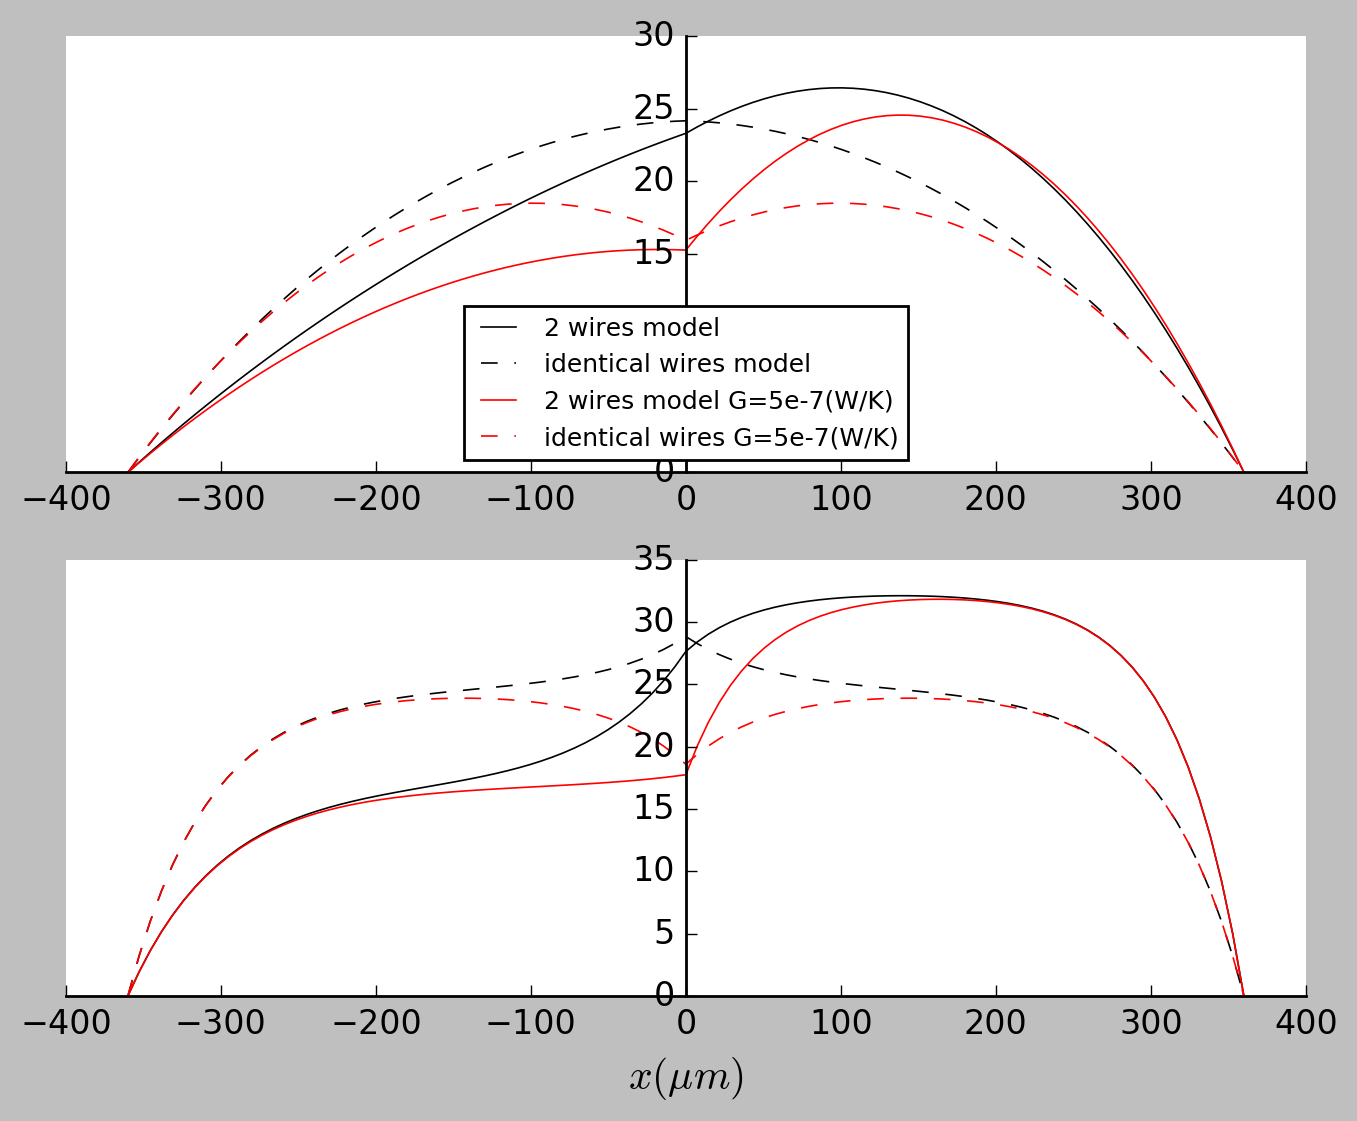

In [9]:
fig, (ax,ax2) = plt.subplots(2,1)

ax.plot(x_array*1e6, T2w_2f_v,'k-',linewidth=0.6,label="2 wires model")
#ax.plot(x_grid*1e6-360, T2w_v,'b-',label="numerical")
ax.plot(x_array*1e6, T2w_1f_v,'k--',linewidth=0.6,label="identical wires model")
ax.plot(x_array*1e6, T2w_2f_c_v,'r-',linewidth=0.6,label="2 wires model G=5e-7(W/K)")
#ax.plot(x_grid*1e6-360, T2w_c_v,'b-.',label="num-ccontact")
ax.plot(x_array*1e6, T2w_1f_c_v,'r--',linewidth=0.6,label="identical wires G=5e-7(W/K)")
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.legend(loc='best',prop={'size':9}) 


ax2.plot(x_array*1e6, T2w_2f,'k-',linewidth=0.6,label="2 wires model")
#ax.plot(x_grid*1e6-360, T2w_v,'b-',label="numerical")
ax2.plot(x_array*1e6, T2w_1f,'k--',linewidth=0.6,label="identical wires model")
ax2.plot(x_array*1e6, T2w_2f_c,'r-',linewidth=0.6,label="2 wires G=5e-7(W/K)")
#ax.plot(x_grid*1e6-360, T2w_c_v,'b-.',label="num-ccontact")
ax2.plot(x_array*1e6, T2w_1f_c,'r--',linewidth=0.6,label="identical wires G=5e-7")
ax2.spines['left'].set_position('zero')
ax2.spines['right'].set_color('none')
ax2.spines['bottom'].set_position('zero')
ax2.spines['top'].set_color('none')
ax2.spines['left'].set_smart_bounds(True)
ax2.spines['bottom'].set_smart_bounds(True)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')


#ax.legend(loc='lower center',prop={'size':11}) 
ax2.set_xlabel('$x(\mu m)$')
#ax.set_ylabel('$\Theta$ (K)')
#ax.set_title('Temmperature profile')
fig.set_size_inches(8, 6)
fig.savefig("Model_analytique_numerique_alpha.png", dpi=400,bbox_inches='tight')
plt.savefig('Model_analytique_numerique_alpha.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

# Probe approach curve

In [236]:
dataApp1_vide=readDataFile_2('2017_9_27_1827\S-TH T6 vide.txt')
dataApp2_vide=readDataFile_2('2017_9_27_1837\S-TH T6 vide.txt')
dataApp3_vide=readDataFile_2('2017_9_27_2341\S-TH T6 vide.txt')
dataApp4_vide=readDataFile_2('2017_9_27_232\S-TH T6 vide.txt')
dataApp4_k_vide=readDataFile('2017_9_27_232\Fast.txt')


In [243]:
import scipy.signal as signal

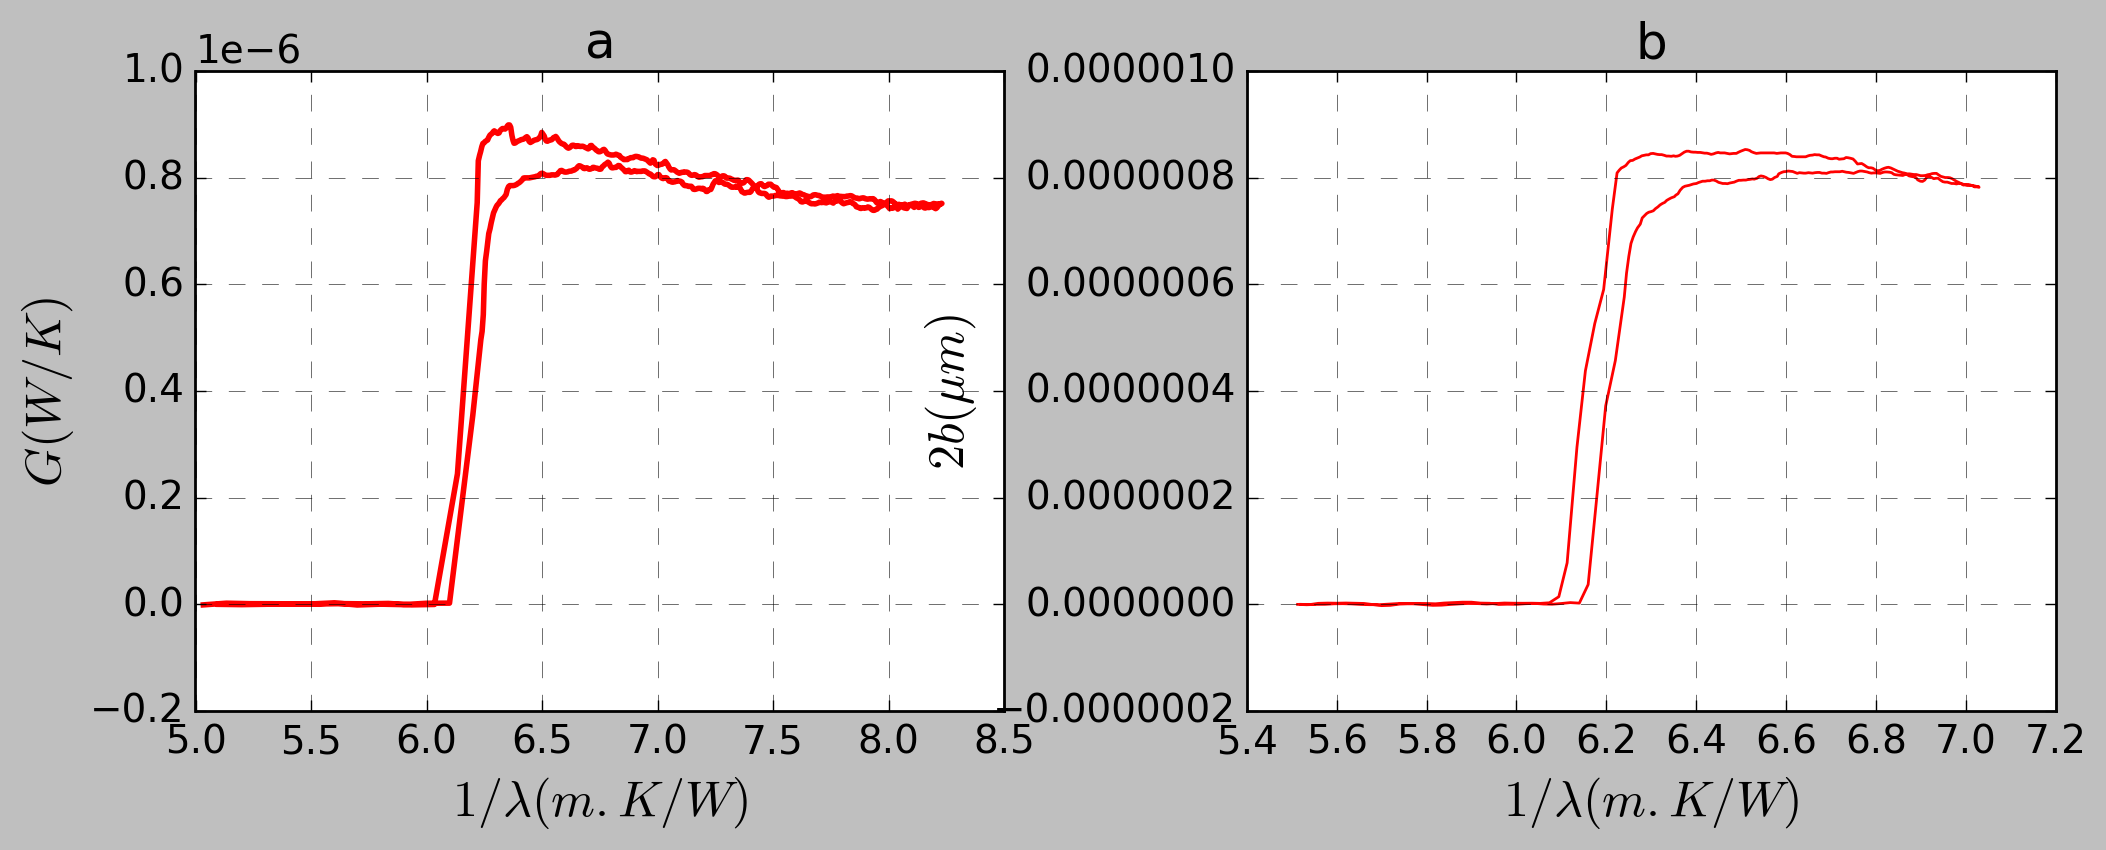

In [219]:
fig, ((ax1, ax2)) = plt.subplots(1, 2)

ax1.plot(dataApp1_vide[:,15], (dataApp1_vide[0,5]-dataApp1_vide[:,5])/(dataApp1_vide[:,5]*K_convide), 'r-',label='Equivalent Resistance',linewidth=2)
#ax1.legend(loc='best',prop={'size':10}) 

ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax1.set_xlabel('$1/\lambda(m.K/W)$')
ax1.set_ylabel('$G (W/K)$')
#ax1.set_xlim([0, 6])
ax1.grid(color='k', linestyle='--', linewidth=0.2)
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

ax2.plot(dataApp2_vide[:,15], (dataApp2_vide[0,5]-dataApp2_vide[:,5])/(dataApp2_vide[:,5]*K_convide), 'r-')
#ax2.set_xlim([0, 6])
#ax2.set_ylim([0, 40])
ax2.set_xlabel('$1/\lambda(m.K/W)$')
ax2.set_ylabel('$2b(\mu m)$')
ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax1.set_title('a', fontsize=18)
ax2.set_title('b', fontsize=18)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.savefig("R_b_Air_newSubtrate.png", dpi=400,bbox_inches="tight")
plt.savefig('R_b_Air_newSubtrate.pdf',format = 'pdf', transparent=True,bbox_inches='tight')


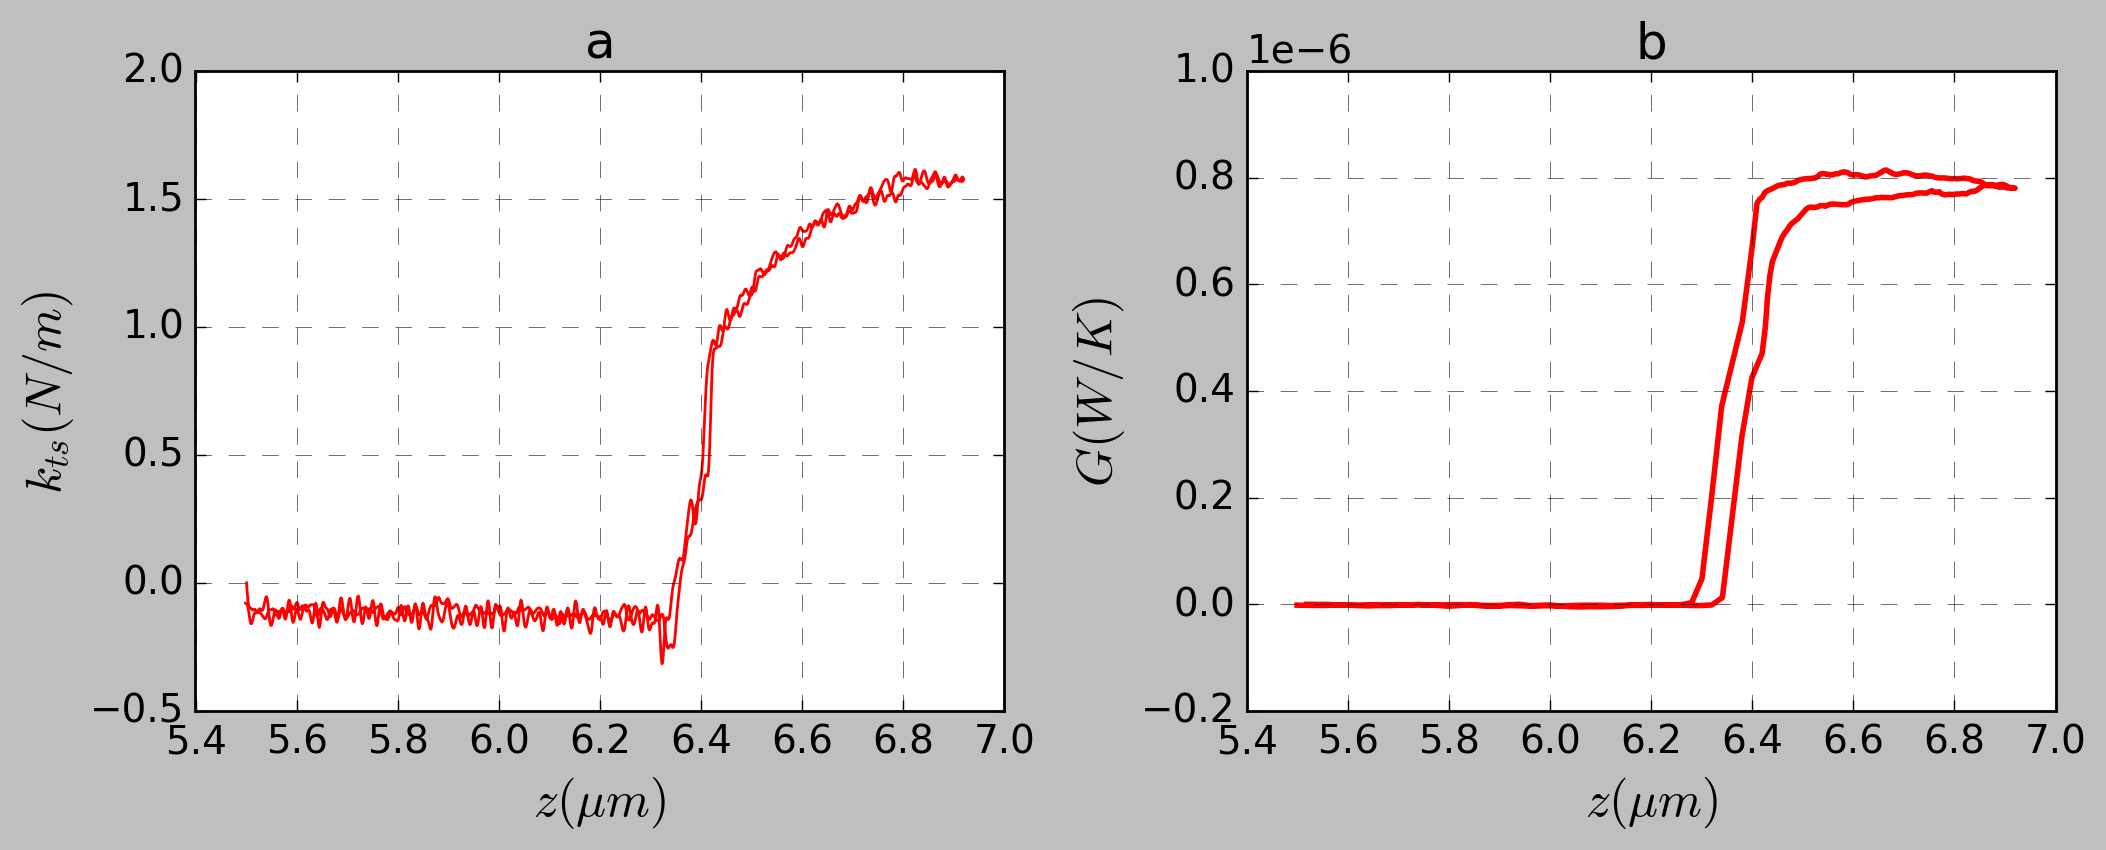

In [323]:
fig, ((ax1, ax2)) = plt.subplots(1, 2)

# First, design the Buterworth filter
N  = 3    # Filter order
Wn = 0.15 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
data_filre = signal.filtfilt(B,A, -(dataApp4_k_vide[:,1]-dataApp4_k_vide[0,1])*2.7)


ax1.plot(dataApp4_k_vide[:,0], data_filre, 'r-',label='Equivalent Resistance',linewidth=1)
#ax1.legend(loc='best',prop={'size':10}) 

#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax1.set_xlabel('$z(\mu m)$')
ax1.set_ylabel('$k_{ts}(N/m)$')
#ax1.set_xlim([0, 6])
ax1.grid(color='k', linestyle='--', linewidth=0.2)
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

ax2.plot(dataApp4_vide[:,15], (dataApp4_vide[0,5]-dataApp4_vide[:,5])/(dataApp4_vide[:,5]*K_convide), 'r-',linewidth=2)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#ax2.set_ylim([0, 40])
ax2.set_xlabel('$z(\mu m)$')
ax2.set_ylabel('$G(W/K)$')
ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax1.set_title('a', fontsize=18)
ax2.set_title('b', fontsize=18)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.savefig("R_b_Vide_app.png", dpi=400,bbox_inches="tight")
plt.savefig('R_b_Vide_app.pdf',format = 'pdf', transparent=True,bbox_inches='tight')




## Air

In [260]:
dataApp1_air=readDataFile_2('2017_9_28_1149\S-TH T6 vide.txt')
dataApp1_k_air=readDataFile('2017_9_28_1149\Fast.txt')
dataApp_air_motor=readDataFile_2('2017_9_28_1221\S-TH _motor.txt')

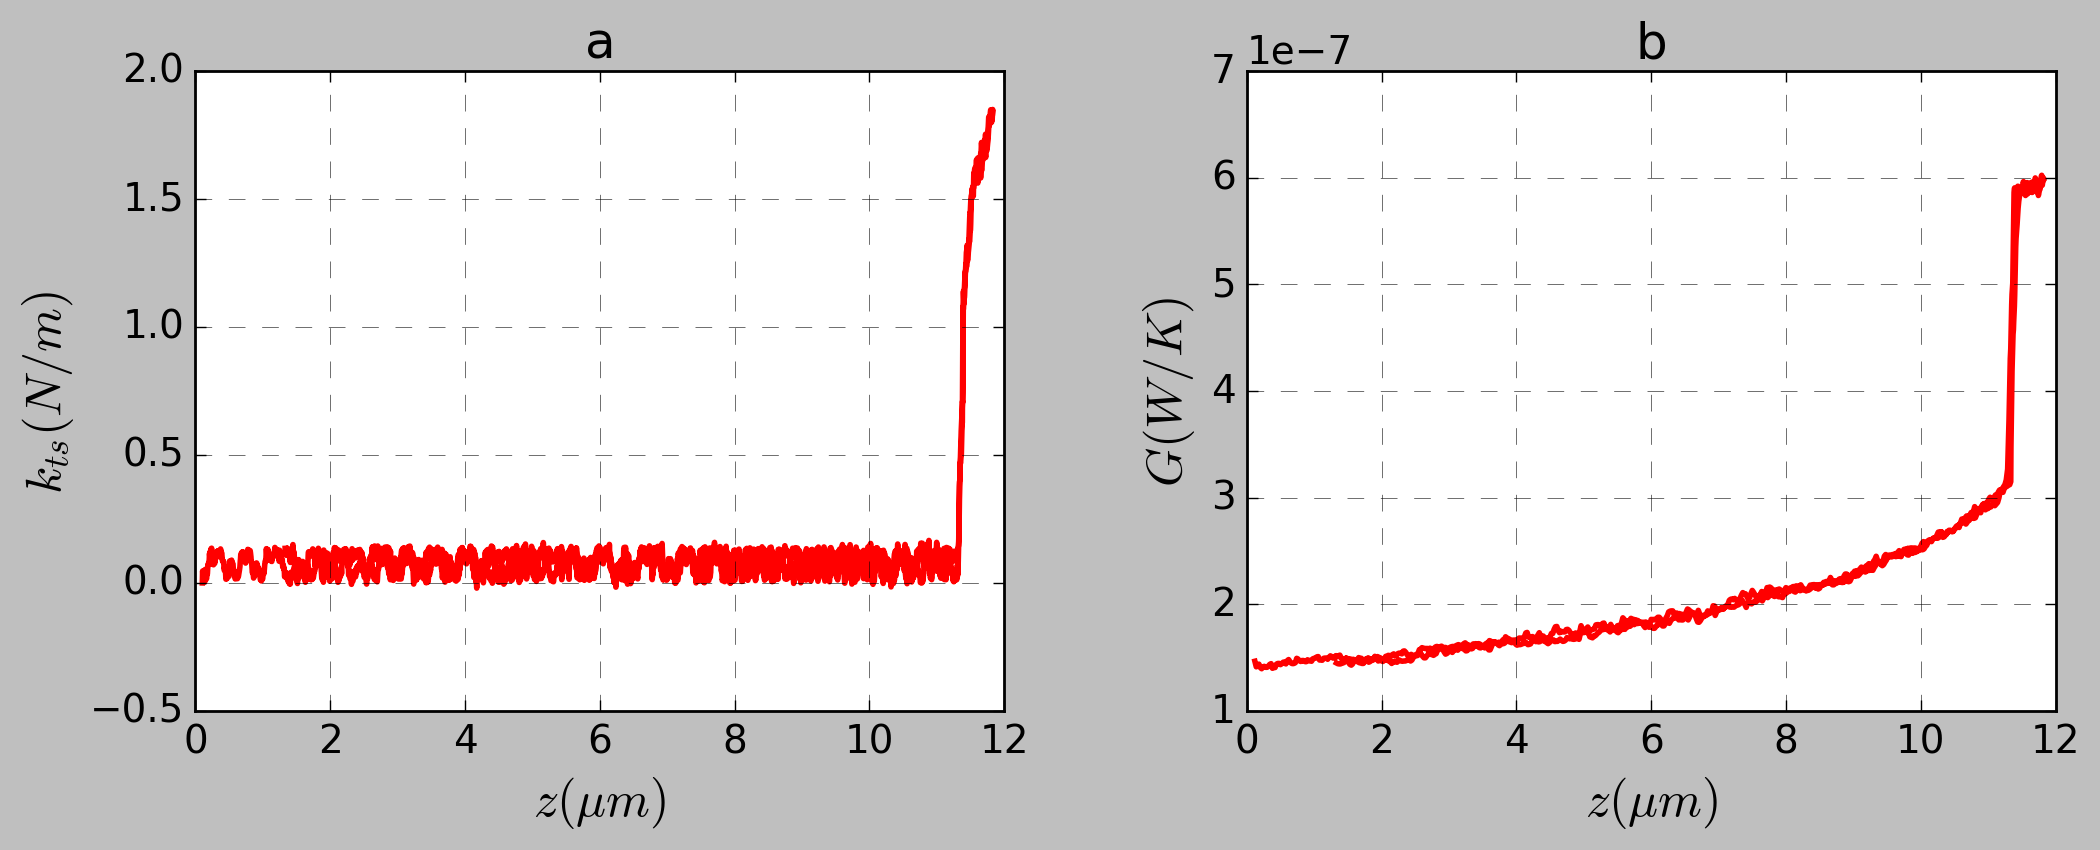

In [262]:
V0 = 149.5
fig, ((ax1, ax2)) = plt.subplots(1, 2)

# First, design the Buterworth filter
N  = 3    # Filter order
Wn = 0.18 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
data_filre = signal.filtfilt(B,A, -(dataApp1_k_air[:,1]-dataApp1_k_air[0,1])*2.7)


ax1.plot(dataApp1_k_air[:,0], data_filre, 'r-',label='Equivalent Resistance',linewidth=2)
#ax1.legend(loc='best',prop={'size':10}) 

#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax1.set_xlabel('$z(\mu m)$')
ax1.set_ylabel('$k_{ts}(N/m)$')

#ax1.set_xlim([0, 6])
ax1.grid(color='k', linestyle='--', linewidth=0.2)
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

ax2.plot(dataApp1_air[:,15], (V0-dataApp1_air[:,5])/(dataApp1_air[:,5]*K_convide), 'r-',linewidth=2)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#ax2.set_ylim([0, 40])
ax2.set_xlabel('$z(\mu m)$')
ax2.set_ylabel('$G(W/K)$')
ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax1.set_title('a', fontsize=18)
ax2.set_title('b', fontsize=18)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.savefig("R_b_Air_newSubtrate.png", dpi=400,bbox_inches="tight")
plt.savefig('R_b_Air_newSubtrate.pdf',format = 'pdf', transparent=True,bbox_inches='tight')


In [268]:
-(dataApp_air_motor[:,18]-dataApp_air_motor[0,18])*1000

array([  -0.  ,   -0.99,   -1.98,   -2.97,   -3.95,   -4.94,   -5.93,
         -6.92,   -7.91,   -8.9 ,   -9.89,  -10.88,  -11.86,  -12.85,
        -13.84,  -14.83,  -15.82,  -16.81,  -17.8 ,  -18.79,  -19.77,
        -20.76,  -21.75,  -22.74,  -23.73,  -24.72,  -25.71,  -26.7 ,
        -27.68,  -28.67,  -29.66,  -30.65,  -31.64,  -32.63,  -33.62,
        -34.61,  -35.59,  -36.58,  -37.57,  -38.56,  -39.55,  -40.54,
        -41.53,  -42.52,  -47.53,  -52.55,  -57.57,  -62.58,  -67.6 ,
        -72.62,  -77.64,  -82.65,  -87.67,  -92.69,  -97.7 , -102.72])

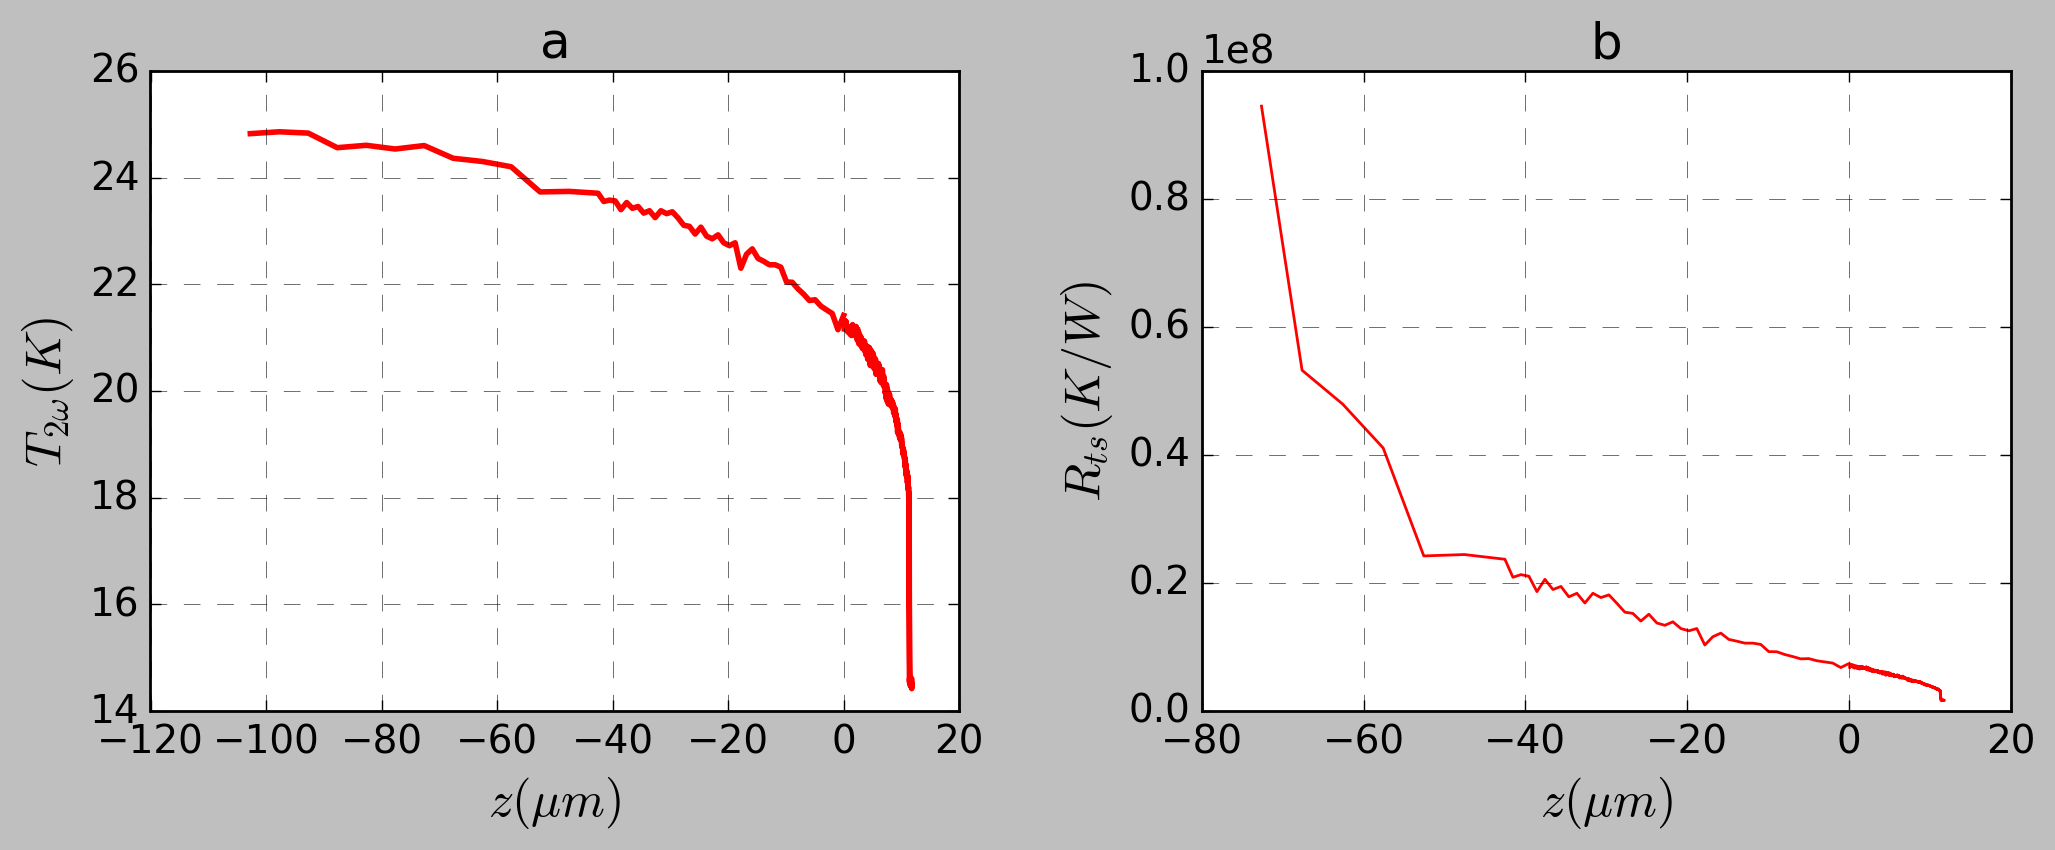

In [362]:
fig, ((ax2, ax1)) = plt.subplots(1, 2)
a=concatenate((dataApp1_air[:,15],-(dataApp_air_motor[:,18]-dataApp_air_motor[0,18])*1000),axis=0)
b=concatenate((1/((V0-dataApp1_air[:,5])/(dataApp1_air[:,5]*K_convide)),1/((V0-dataApp_air_motor[:,5])/(dataApp_air_motor[:,5]*K_convide))),axis=0)
ax1.plot(a[:len(a)-6],b[:len(a)-6],'r-',linewidth=1)
#ax1.plot(-(dataApp_air_motor[:,18]-dataApp_air_motor[0,18])*1000, 1/((V0-dataApp_air_motor[:,5])/(dataApp_air_motor[:,5]*K_convide)), 'r-',label='Equivalent Resistance',linewidth=2)
#ax1.legend(loc='best',prop={'size':10}) 
#ax1.set_xlim([-75, 20])
#ax1.set_ylim([0, 1e8])
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax1.set_xlabel('$z(\mu m)$')
ax1.set_ylabel('$R_{ts}(K/W)$')
#ax1.text(-67,0.8e8,'convection')
#ax1.set_xlim([0, 6])
ax1.grid(color='k', linestyle='--', linewidth=0.2)
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

ax2.plot(dataApp1_air[:,15], dataApp1_air[:,5]/6, 'r-',linewidth=2)
ax2.plot(-(dataApp_air_motor[:,18]-dataApp_air_motor[0,18])*1000, dataApp_air_motor[:,5]/6, 'r-',label='Equivalent Resistance',linewidth=2)

ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#ax2.set_ylim([0, 40])
ax2.set_xlabel('$z(\mu m)$')
ax2.set_ylabel('$T_{2\omega}(K)$')
ax2.grid(color='k', linestyle='--', linewidth=0.2)
ax1.set_title('b', fontsize=18)
ax2.set_title('a', fontsize=18)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.savefig("R_b_Air_app.png", dpi=400,bbox_inches="tight")
plt.savefig('R_b_Air_app.pdf',format = 'pdf', transparent=True,bbox_inches='tight')


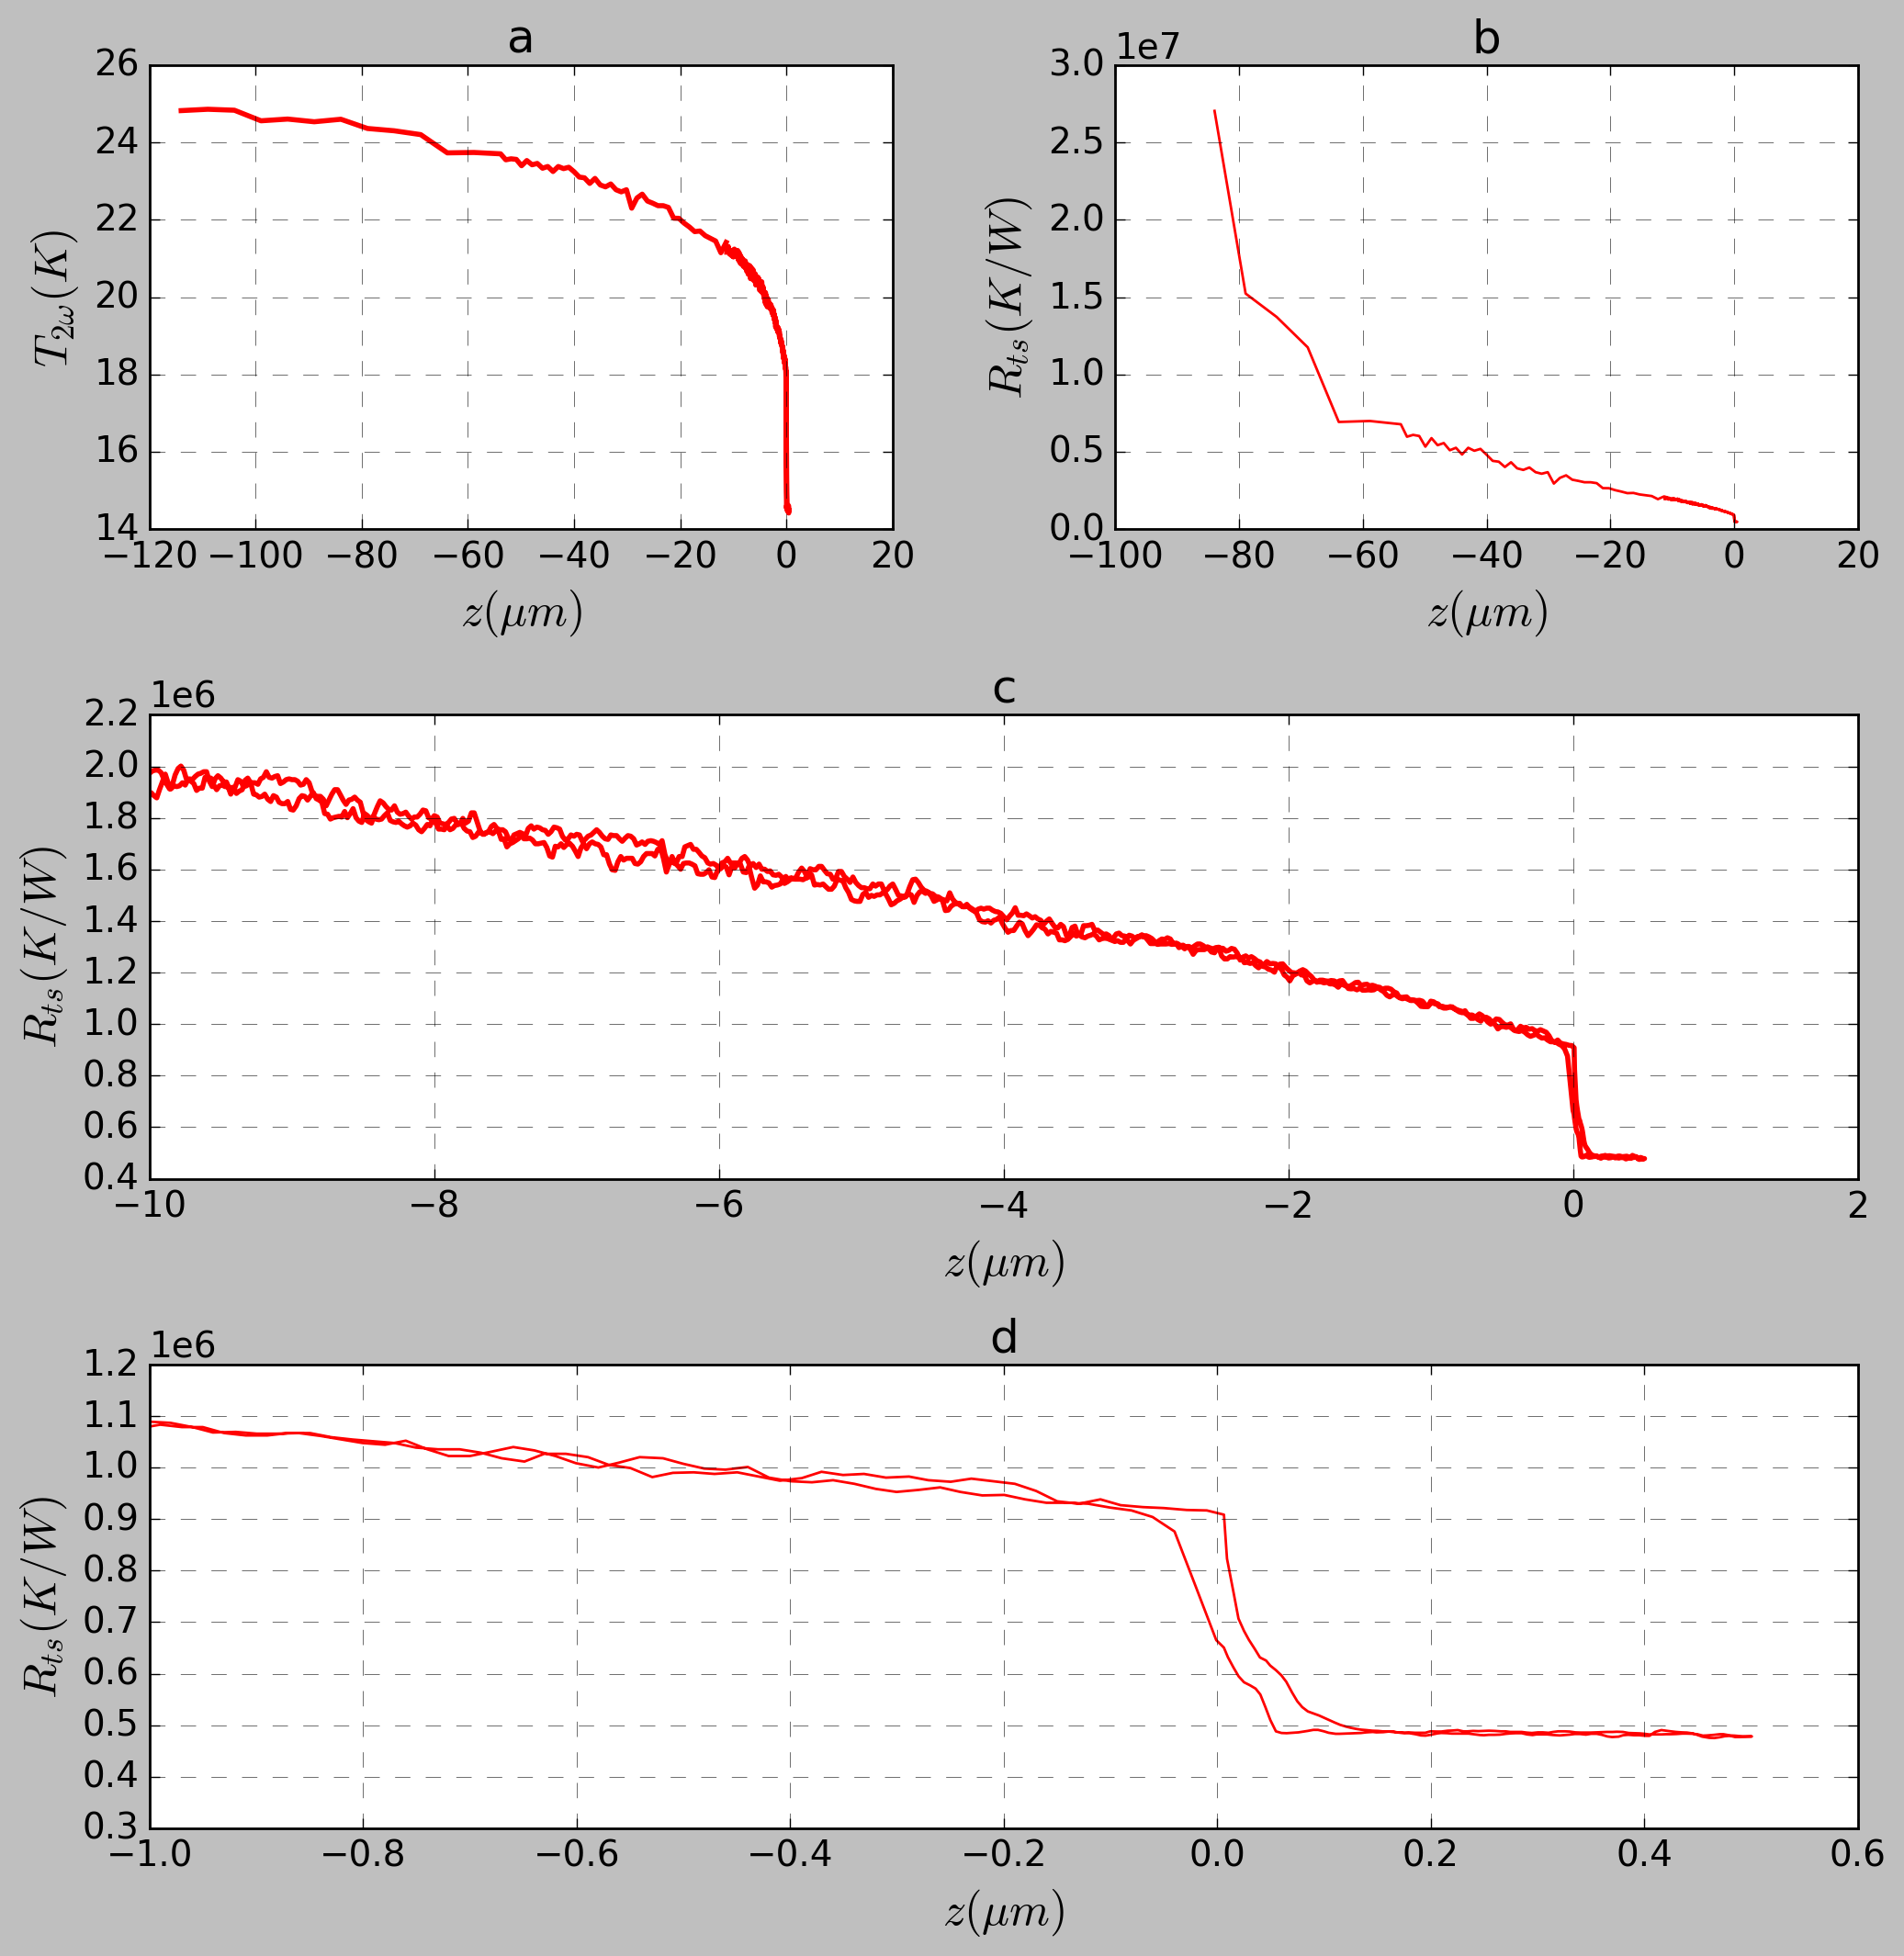

In [391]:
fig = plt.figure()

ax2 = plt.subplot2grid((3,2), (0,0))
ax1 = plt.subplot2grid((3,2), (0,1))
ax3 = plt.subplot2grid((3,2), (1,0),colspan=2)
ax4 = plt.subplot2grid((3,2), (2,0),colspan=2)
zshift=11.33
a=concatenate((dataApp1_air[:,15],-(dataApp_air_motor[:,18]-dataApp_air_motor[0,18])*1000),axis=0)
b=concatenate((1/((V0-dataApp1_air[:,5])/(dataApp1_air[:,5]*K_convair)),1/((V0-dataApp_air_motor[:,5])/(dataApp_air_motor[:,5]*K_convair))),axis=0)
ax1.plot(a[:len(a)-6]-zshift,b[:len(a)-6],'r-',linewidth=1)
ax1.set_xlabel('$z(\mu m)$')
ax1.set_ylabel('$R_{ts}(K/W)$')
#ax1.text(-67,0.8e8,'convection')
#ax1.set_xlim([0, 6])
ax1.grid(color='k', linestyle='--', linewidth=0.2)
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

ax2.plot(dataApp1_air[:,15]-zshift, dataApp1_air[:,5]/6, 'r-',linewidth=2)
ax2.plot(-(dataApp_air_motor[:,18]-dataApp_air_motor[0,18])*1000-zshift, dataApp_air_motor[:,5]/6, 'r-',label='Equivalent Resistance',linewidth=2)

ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#ax2.set_ylim([0, 40])
ax2.set_xlabel('$z(\mu m)$')
ax2.set_ylabel('$T_{2\omega}(K)$')
ax2.grid(color='k', linestyle='--', linewidth=0.2)

ax3.plot(dataApp1_air[:,15]-zshift, 1/((V0-dataApp1_air[:,5])/(dataApp1_air[:,5]*K_convair)), 'r-',linewidth=2)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax3.set_xlim([-10, 2])
ax3.set_xlabel('$z(\mu m)$')
ax3.set_ylabel('$R_{ts}(K/W)$')
ax3.grid(color='k', linestyle='--', linewidth=0.2)

ax4.plot(dataApp1_air[:,15]-zshift, 1/((V0-dataApp1_air[:,5])/(dataApp1_air[:,5]*K_convair)), 'r-',linewidth=1)
ax4.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax4.set_xlim([-1, 0.6])
ax4.set_ylim([0.3e6, 1.2e6])
ax4.set_xlabel('$z(\mu m)$')
ax4.set_ylabel('$R_{ts}(K/W)$')
ax4.grid(color='k', linestyle='--', linewidth=0.2)

ax1.set_title('b', fontsize=18)
ax2.set_title('a', fontsize=18)
ax3.set_title('c', fontsize=18)
ax4.set_title('d', fontsize=18)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.3,hspace=0.4)
fig.savefig("R_b_Air_app.png", dpi=400,bbox_inches="tight")
plt.savefig('R_b_Air_app.pdf',format = 'pdf', transparent=True,bbox_inches='tight')


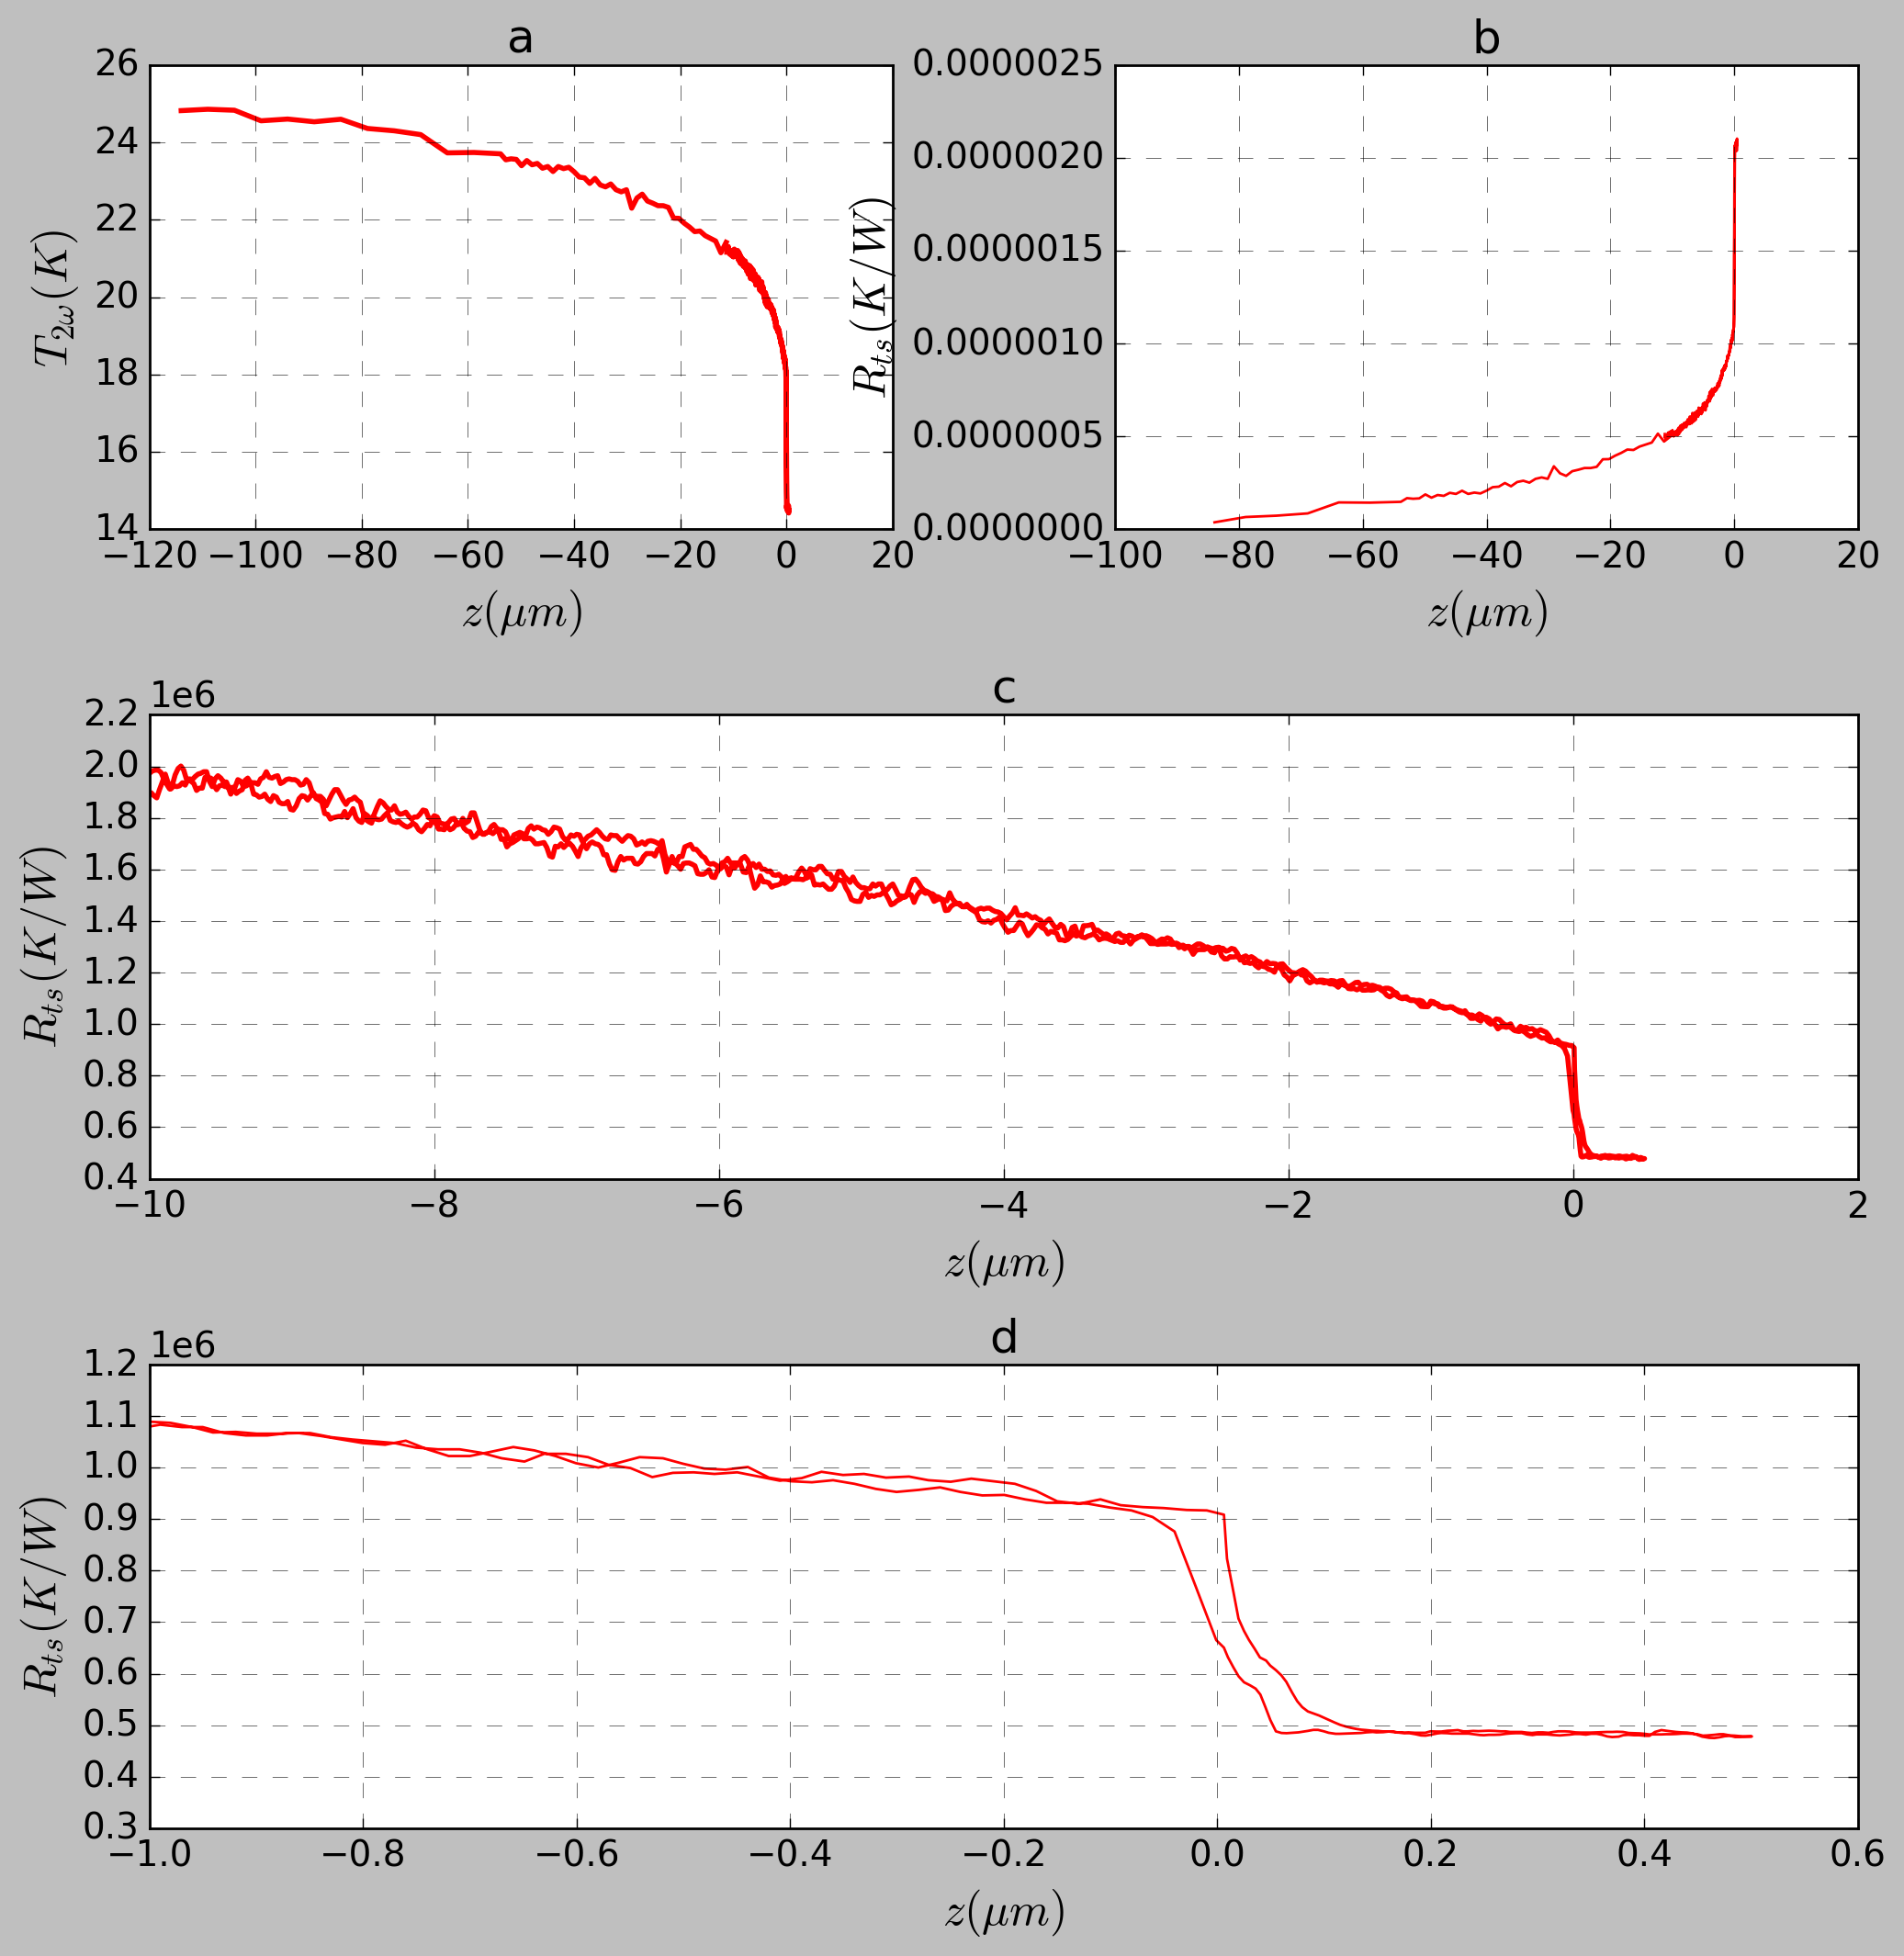

In [478]:
fig = plt.figure()

ax2 = plt.subplot2grid((3,2), (0,0))
ax1 = plt.subplot2grid((3,2), (0,1))
ax3 = plt.subplot2grid((3,2), (1,0),colspan=2)
ax4 = plt.subplot2grid((3,2), (2,0),colspan=2)
zshift=11.33
a=concatenate((dataApp1_air[:,15],-(dataApp_air_motor[:,18]-dataApp_air_motor[0,18])*1000),axis=0)
b=concatenate((1/((V0-dataApp1_air[:,5])/(dataApp1_air[:,5]*K_convair)),1/((V0-dataApp_air_motor[:,5])/(dataApp_air_motor[:,5]*K_convair))),axis=0)
ax1.plot(a[:len(a)-6]-zshift,1/b[:len(a)-6],'r-',linewidth=1)
ax1.set_xlabel('$z(\mu m)$')
ax1.set_ylabel('$R_{ts}(K/W)$')
#ax1.text(-67,0.8e8,'convection')
#ax1.set_xlim([0, 6])
ax1.grid(color='k', linestyle='--', linewidth=0.2)
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

ax2.plot(dataApp1_air[:,15]-zshift, dataApp1_air[:,5]/6, 'r-',linewidth=2)
ax2.plot(-(dataApp_air_motor[:,18]-dataApp_air_motor[0,18])*1000-zshift, dataApp_air_motor[:,5]/6, 'r-',label='Equivalent Resistance',linewidth=2)

ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#ax2.set_ylim([0, 40])
ax2.set_xlabel('$z(\mu m)$')
ax2.set_ylabel('$T_{2\omega}(K)$')
ax2.grid(color='k', linestyle='--', linewidth=0.2)

ax3.plot(dataApp1_air[:,15]-zshift, 1/((V0-dataApp1_air[:,5])/(dataApp1_air[:,5]*K_convair)), 'r-',linewidth=2)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax3.set_xlim([-10, 2])
ax3.set_xlabel('$z(\mu m)$')
ax3.set_ylabel('$R_{ts}(K/W)$')
ax3.grid(color='k', linestyle='--', linewidth=0.2)

ax4.plot(dataApp1_air[:,15]-zshift, 1/((V0-dataApp1_air[:,5])/(dataApp1_air[:,5]*K_convair)), 'r-',linewidth=1)
ax4.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax4.set_xlim([-1, 0.6])
ax4.set_ylim([0.3e6, 1.2e6])
ax4.set_xlabel('$z(\mu m)$')
ax4.set_ylabel('$R_{ts}(K/W)$')
ax4.grid(color='k', linestyle='--', linewidth=0.2)

ax1.set_title('b', fontsize=18)
ax2.set_title('a', fontsize=18)
ax3.set_title('c', fontsize=18)
ax4.set_title('d', fontsize=18)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.3,hspace=0.4)
fig.savefig("R_b_Air_app.png", dpi=400,bbox_inches="tight")
plt.savefig('R_b_Air_app.pdf',format = 'pdf', transparent=True,bbox_inches='tight')


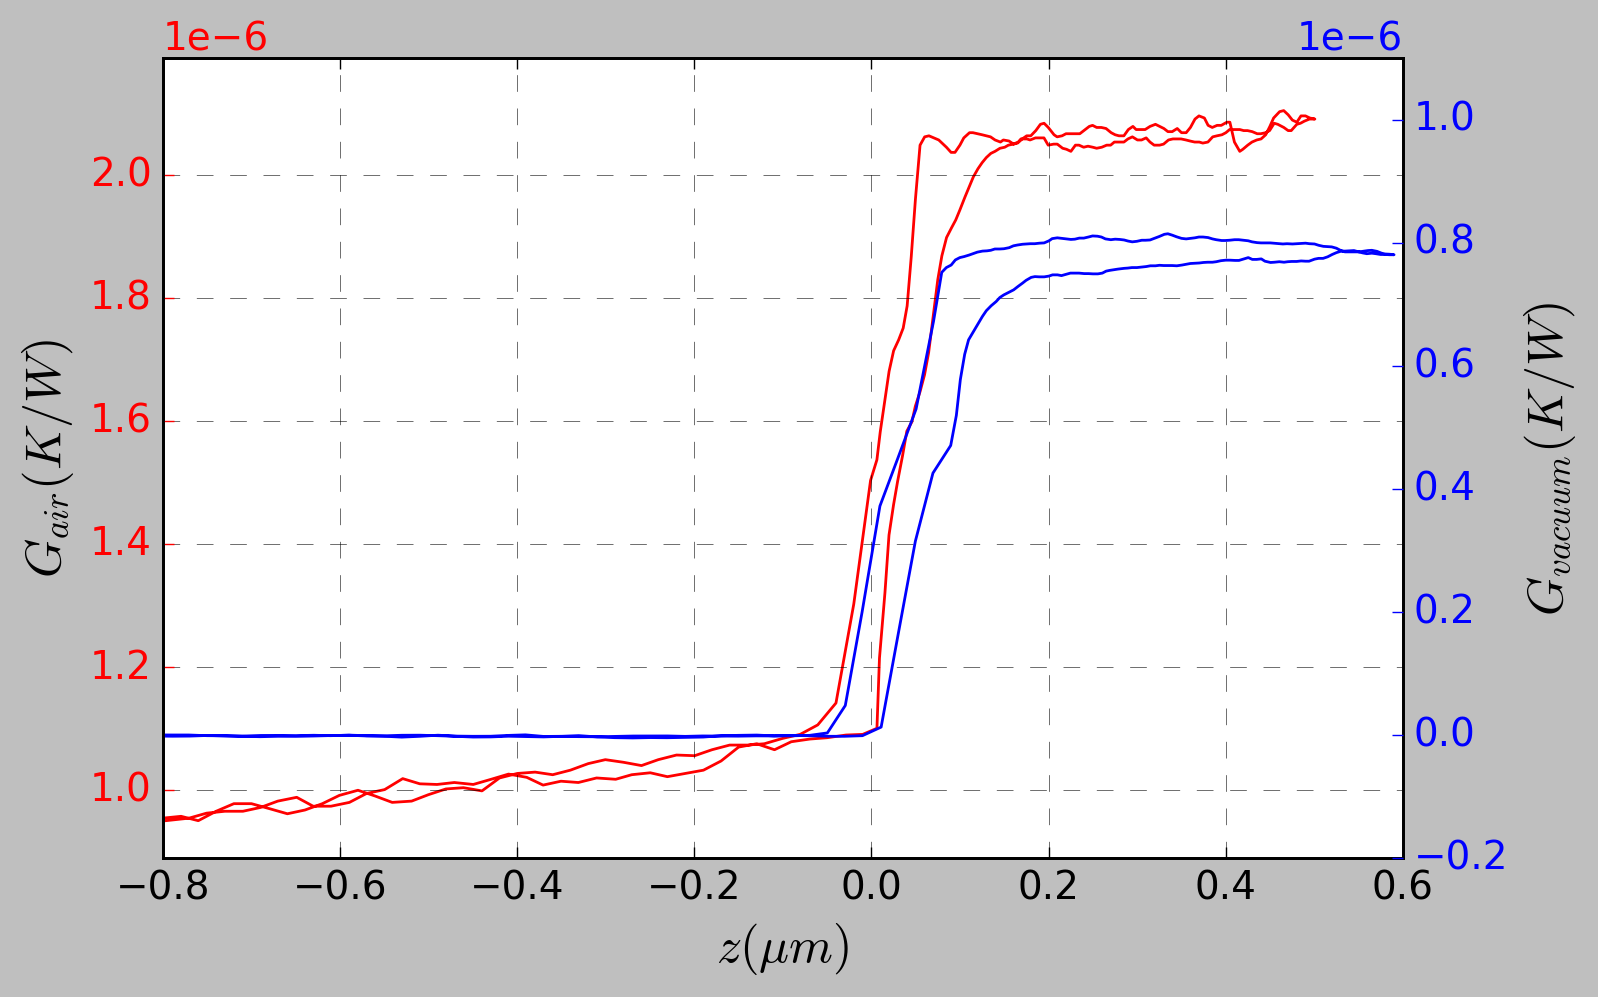

In [477]:
fig, (ax4) = plt.subplots()

ax4.plot(dataApp1_air[:,15]-zshift, ((V0-dataApp1_air[:,5])/(dataApp1_air[:,5]*K_convair)), 'r-',linewidth=1)
#ax4.plot(dataApp4_vide[:,15]-6.33, (dataApp4_vide[0,5]-dataApp4_vide[:,5])/(dataApp4_vide[:,5]*K_convide), 'b-',linewidth=1)

ax4.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax4.set_xlim([-1, 0.6])
ax4.set_ylim([0.89e-6, 2.19e-6])
ax4.set_xlabel('$z(\mu m)$')
ax4.set_ylabel('$G_{air}(K/W)$')
ax4.tick_params('y', colors='r')
ax4.grid(color='k', linestyle='--', linewidth=0.2)

ax3 = ax4.twinx()
#ax3.plot(C2_air_2mA[:,16]+1, T_RTD_2mA_sp,'g-' ,label='2mA')
ax3.plot(dataApp4_vide[:,15]-6.33, (dataApp4_vide[0,5]-dataApp4_vide[:,5])/(dataApp4_vide[:,5]*K_convide), 'b-',linewidth=1)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

ax3.set_ylabel('$G_{vacuum}(K/W)$')
ax3.set_xlim([-0.8, 0.6])
#ax3.set_yscale('log')
ax3.tick_params('y', colors='b')
ax3.set_ylim([-0.2e-6, 1.1e-6])

fig.set_size_inches(8, 5)
fig.subplots_adjust(wspace=0.3,hspace=0.4)
fig.savefig("App_solid_conduction.png", dpi=400,bbox_inches="tight")
plt.savefig('App_solid_conduction.pdf',format = 'pdf', transparent=True,bbox_inches='tight')

#ax3.set_xlim([0,9])
#ax3.set_ylim([0.2, 1.2])
#ax3.legend(loc='best',prop={'size':9}) 
#ax1.legend(loc='lower right',prop={'size':9}) 

In [388]:
(6*200e-9*10e-9/100e9)**(1/3)

4.9324241486609454e-09